In [50]:
!jupyter kernelspec list

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Available kernels:
  python3    /home/arc/miniconda3/envs/showo/share/jupyter/kernels/python3


In [51]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from PIL import Image

from models import Showo, MAGVITv2
from training.prompting_utils import UniversalPrompting, create_attention_mask_for_mmu, create_attention_mask_for_mmu_vit
from training.utils import get_config, flatten_omega_conf, image_transform
from transformers import AutoTokenizer
from models.clip_encoder import CLIPVisionTower
from transformers import CLIPImageProcessor
from llava.llava import conversation as conversation_lib

conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]

In [52]:
import os

# # os.environ['https_proxy'] = 'http://bj-rd-proxy.byted.org:3128'
# # os.environ['http_proxy'] = 'http://bj-rd-proxy.byted.org:3128'
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['HF_HOME'] = '/home/arc/.cache/huggingface'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [53]:
from omegaconf import DictConfig, ListConfig, OmegaConf
config = OmegaConf.load('configs/showo_demo_w_clip_vit.yaml')
# device setup
device = torch.device("cuda:7")

In [54]:
config

{'wandb': {'entity': None, 'resume': 'auto'}, 'experiment': {'project': 'demo', 'name': 'show-o-demo', 'output_dir': 'show-o-demo'}, 'model': {'vq_model': {'type': 'magvitv2', 'vq_model_name': '/home/arc/.cache/huggingface/hub/models--showlab--magvitv2/snapshots/5c3fa78f8b3523347c5cd1a4c97f3c4e96f33d5d'}, 'showo': {'pretrained_model_path': '/home/arc/.cache/huggingface/hub/models--showlab--show-o-w-clip-vit/snapshots/31a9d79fb8a1649f4e8919b924a7106c06e4a609', 'w_clip_vit': True, 'vocab_size': 58498, 'llm_vocab_size': 50295, 'llm_model_path': '/home/arc/.cache/huggingface/hub/models--microsoft--phi-1_5/snapshots/675aa382d814580b22651a30acb1a585d7c25963', 'codebook_size': 8192, 'num_vq_tokens': 256, 'num_new_special_tokens': 10}, 'gradient_checkpointing': True}, 'dataset': {'gen_type': 't2i', 'und_type': 'captioning', 'params': {'batch_size': '${training.batch_size}', 'shuffle_buffer_size': 1000, 'num_workers': 32, 'resolution': 256, 'pin_memory': True, 'persistent_workers': True}, 'prep

In [55]:
# config load -  'showo_demo_w_clip_vit.yaml'

# device = "cpu"

# show o tokenizer setup and adding special tokens to universal prompting
# llm model : 'microsoft/phi-1_5'
tokenizer = AutoTokenizer.from_pretrained(config.model.showo.llm_model_path, padding_side ="left")
uni_prompting = UniversalPrompting(tokenizer, max_text_len=config.dataset.preprocessing.max_seq_length,
                                       special_tokens=("<|soi|>", "<|eoi|>", "<|sov|>", "<|eov|>", "<|t2i|>", "<|mmu|>", "<|t2v|>", "<|v2v|>", "<|lvg|>"),
                                       ignore_id=-100, cond_dropout_prob=config.training.cond_dropout_prob)

# setting up the visual question answering model: magvit-v2
vq_model = MAGVITv2
vq_model = vq_model.from_pretrained(config.model.vq_model.vq_model_name).to(device)
vq_model.requires_grad_(False)
vq_model.eval()

# setting up vision tower: clip-vit
vision_tower_name =config.clip_path
vision_tower = CLIPVisionTower(vision_tower_name).to(device)
clip_image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name)

# setting up the showo model 
model = Showo.from_pretrained(config.model.showo.pretrained_model_path).to(device)
# model.eval()

# setting up the parameters
temperature = 0.8  # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 1  # retain only the top_k most likely tokens, clamp others to have 0 probability
SYSTEM_PROMPT = "A chat between a curious user and an artificial intelligence assistant. " \
                "The assistant gives helpful, detailed, and polite answers to the user's questions."
SYSTEM_PROMPT_LEN = 28

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/arc/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:


attention implementation:  sdpa


In [56]:
clip_image_processor

CLIPImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_center_crop",
    "crop_size",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

In [57]:
import json


class PersonalizedShowoDataset(Dataset):
    def __init__(
        self,
        data_root: str,
        concept_name: str,
        showo_image_transform,
        clip_image_processor,
        config,
        device: str = "cuda"
    ):
        self.data_root = data_root
        self.concept_name = concept_name
        self.clip_image_processor = clip_image_processor
        self.showo_image_transform = showo_image_transform
        self.config = config
        self.device = device

        conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]
        # /home/arc/MulBench/llama_fact_data/train
        with open(os.path.join(data_root, f"llama_fact_data/train/{concept_name}_train.json")) as f:
            conversations = json.load(f)
        self.conversations = conversations

    def __len__(self):
        return len(self.conversations)

    def __getitem__(self, idx):
        conv_item = self.conversations[idx]
        # {
        #     "messages": [
        #         {
        #             "content": "<image>How would you describe <BaGu>'s attire?",
        #             "role": "user"
        #         },
        #         {
        #             "content": "The image does not provide enough information to describe <BaGu>'s attire.",
        #             "role": "assistant"
        #         }
        #     ],
        #     "images": [
        #         "/home/arc/MulBench/two_concept/concept/train/BaGu/6.png"
        #     ]
        # }
        image_path = conv_item["images"][0]
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.clip_image_processor(image, return_tensors="pt")['pixel_values'][0]
        
        question = conv_item["messages"][0]["content"].replace("<image>", "")
        answer = conv_item["messages"][1]["content"]
        
        conv = conversation_lib.default_conversation.copy()
        conv.append_message(conv.roles[0], question)
        prompt_w_o_answer = conv.get_prompt()
        conv.append_message(conv.roles[1], answer)
        prompt_w_answer = conv.get_prompt()
        
        return {
            "image": image,
            "pixel_values": pixel_values,   # [3, 336, 336]
            "question": question,
            "answer": answer,
            "prompt_w_answer": prompt_w_answer,
            "prompt_w_o_answer": prompt_w_o_answer
        }

In [58]:
train_dataset = PersonalizedShowoDataset('/home/arc/MulBench', 
                                         'BaGu', 
                                         showo_image_transform=image_transform, 
                                         clip_image_processor=clip_image_processor, 
                                         config=config,
                                         device=device)
len(train_dataset)

349

In [59]:
train_dataset[1]

{'image': <PIL.Image.Image image mode=RGB size=655x353>,
 'pixel_values': tensor([[[ 0.6895,  0.7041,  0.7333,  ...,  0.6749,  0.6165,  0.5581],
          [ 0.6895,  0.6895,  0.7041,  ...,  0.6749,  0.6165,  0.5581],
          [ 0.6749,  0.6603,  0.6603,  ...,  0.6749,  0.6165,  0.5581],
          ...,
          [-0.0842, -0.0842, -0.0696,  ...,  0.3099,  0.3245,  0.3099],
          [-0.0842, -0.0696, -0.0842,  ...,  0.2515,  0.2807,  0.2807],
          [-0.0842, -0.0842, -0.0988,  ...,  0.2223,  0.2223,  0.2807]],
 
         [[ 0.3340,  0.3340,  0.3490,  ...,  0.4240,  0.3640,  0.3190],
          [ 0.3340,  0.3190,  0.3040,  ...,  0.4240,  0.3640,  0.3190],
          [ 0.3190,  0.2890,  0.2740,  ...,  0.4240,  0.3790,  0.3040],
          ...,
          [-1.0167, -1.0017, -0.9867,  ..., -1.2418, -1.1968, -1.1818],
          [-1.0167, -1.0017, -0.9867,  ..., -1.3469, -1.2869, -1.2268],
          [-1.0167, -1.0017, -0.9867,  ..., -1.3769, -1.3319, -1.2418]],
 
         [[-0.1578, -0.1578

In [60]:
model.showo.get_input_embeddings()

Embedding(58498, 2048)

In [65]:
class PersonalizedShowoTrainer:
    def __init__(
        self,
        concept_name,
        model,
        tokenizer,
        vq_model,
        vision_tower,
        clip_processor,
        uni_prompting,
        config,
        device="cuda"
    ):
        self.concept_name = concept_name
        self.model = model
        self.tokenizer = tokenizer
        self.vq_model = vq_model
        self.vision_tower = vision_tower
        self.clip_processor = clip_processor
        self.config = config
        self.device = device
        self.uni_prompting = uni_prompting
        
        new_tokens = [f"<{concept_name}>"] 
        num_added_tokens = self.tokenizer.add_tokens(new_tokens)
        
        self.model.showo.resize_token_embeddings(len(self.tokenizer))
        
        with torch.no_grad():
            for token in new_tokens:
                token_id = self.tokenizer.convert_tokens_to_ids(token)
                torch.nn.init.normal_(
                    self.model.showo.get_input_embeddings().weight[token_id],
                    mean=0.0,
                    std=0.02
                )
        
        self.placeholder_token_ids = [
            self.tokenizer.convert_tokens_to_ids(token)
            for token in new_tokens
        ]
        
        with torch.no_grad():
            self.orig_embeds = self.model.showo.get_input_embeddings().weight.data.clone()
            self.orig_lm_head = self.model.showo.lm_head.weight.data.clone()
            
        trainable_params = [self.model.showo.get_input_embeddings().weight, self.model.showo.lm_head.weight]
        self.optimizer = torch.optim.AdamW(
            trainable_params, # for optimize the embeddings and the head
            lr=1e-3,
            betas=(0.9, 0.999),
            weight_decay=1e-2,
            eps=1e-08,
        )

    def get_embedding_attention_mask(self, batch, train=False):
        """获取输入的embedding和attention mask"""
        pixel_values = batch['pixel_values'].to(self.device)
        
        with torch.no_grad():
            images_embeddings = self.vision_tower(pixel_values[None])
            images_embeddings = self.model.mm_projector(images_embeddings)  # [1, 576, 2048]
        
        conv = conversation_lib.default_conversation.copy()
        prompt_w_o_answer = batch['prompt_w_o_answer']
        
        input_ids_system = self.uni_prompting.text_tokenizer(
            SYSTEM_PROMPT,
            return_tensors="pt",
            padding="longest"
        ).input_ids.to(self.device)[0]
        
        input_ids = self.uni_prompting.text_tokenizer(
            prompt_w_o_answer.strip(),
            return_tensors="pt",
            padding="longest"
        ).input_ids.to(self.device)
        
        input_ids_full = torch.cat([
            (torch.ones(input_ids.shape[0], 1) * self.uni_prompting.sptids_dict['<|mmu|>']).to(self.device),
            input_ids_system.unsqueeze(0),
            (torch.ones(input_ids.shape[0], 1) * self.uni_prompting.sptids_dict['<|soi|>']).to(self.device),
            (torch.ones(input_ids.shape[0], 1) * self.uni_prompting.sptids_dict['<|eoi|>']).to(self.device),
            input_ids,
        ], dim=1).long()
        
        text_embeddings = self.model.showo.model.embed_tokens(input_ids_full)
        
        part1 = text_embeddings[:, :2+SYSTEM_PROMPT_LEN, :]
        part2 = text_embeddings[:, 2+SYSTEM_PROMPT_LEN:, :]
        input_embeddings = torch.cat([part1, images_embeddings, part2], dim=1)
        
        attention_mask = create_attention_mask_for_mmu_vit(
            input_embeddings,
            system_prompt_len=SYSTEM_PROMPT_LEN
        )
        
        target_ids_only_answer = self.uni_prompting.text_tokenizer(
            batch['answer'],
            return_tensors="pt",
            padding="longest"
        ).input_ids.to(self.device)            
        
        return input_embeddings, attention_mask[0].unsqueeze(0), target_ids_only_answer

    def train_step(self, batch):
        self.optimizer.zero_grad()

        # # 构建完整对话,但answer部分用特殊token填充
        # conv = conversation_lib.default_conversation.copy()
        # conv.append_message(conv.roles[0], batch['question'])
        # # 用特殊token填充answer位置,长度与真实answer相同
        # target_ids = self.uni_prompting.text_tokenizer(
        #     batch['answer'],
        #     return_tensors="pt",
        #     padding="longest"
        # ).input_ids.to(self.device)
        
        # # 创建一个填充序列,长度与answer相同
        # padding_answer = " ".join(["[MASK]"] * target_ids.size(1))
        # conv.append_message(conv.roles[1], padding_answer)
        
        # 获取输入embedding和attention mask
        input_embeddings, attention_mask_llava, target_ids_only_answer = self.get_embedding_attention_mask(batch)
        
        # 获取模型输出
        outputs = self.model.showo(
            inputs_embeds=input_embeddings,
            attention_mask=attention_mask_llava
        )
        logits = outputs['logits']  # [1, seq_len, vocab_size]
        
        # # 计算answer开始的位置
        # system_len = SYSTEM_PROMPT_LEN
        # image_len = 576  # 从images_embeddings.shape[1]获取
        # special_tokens_len = 3  # <|mmu|>, <|soi|>, <|eoi|>
        # question_len = self.uni_prompting.text_tokenizer(
        #     batch['question'],
        #     return_tensors="pt"
        # ).input_ids.shape[1]
        
        # # 定位answer部分的logits
        # answer_start_idx = system_len + image_len + special_tokens_len + question_len
        # answer_logits = logits[:, answer_start_idx:answer_start_idx + target_ids.size(1)]
        
        # # 获取答案部分的logits
        answer_logits = logits[:, -target_ids_only_answer.size(1):] # 倒着取，可以不用算上面的
        # print(f"answer_logits shape: {answer_logits.shape}, target_ids shape: {target_ids.shape}")

        # 计算loss - 直接使用reshape后的维度
        loss = F.cross_entropy(
            answer_logits.reshape(-1, logits.size(-1)),  # [target_ids.shape[1], 50306]
            target_ids_only_answer.reshape(-1),  # target_ids.shape[1]
            ignore_index=-100
        )
        print(loss)
        loss.backward()
        self.optimizer.step()
        
        # 恢复非subject token的参数
        with torch.no_grad():
            index_no_updates = torch.ones((len(self.tokenizer),), dtype=torch.bool)
            index_no_updates[self.placeholder_token_ids] = False
            
            self.model.showo.get_input_embeddings().weight.data[index_no_updates] = \
                self.orig_embeds[index_no_updates]
            self.model.showo.lm_head.weight.data[index_no_updates] = \
                self.orig_lm_head[index_no_updates]
        
        return loss.item()

    def train(self, train_dataset, num_epochs=15):
        losses = []
        self.model.train()
        self.model.requires_grad_(False)   
        self.model.showo.get_input_embeddings().weight.requires_grad_(True)
        self.model.showo.lm_head.weight.requires_grad_(True)
        for names, p in model.named_parameters():
            if p.requires_grad:
                print(f"{names} requires_grad")
                
        for epoch in range(num_epochs):
            epoch_losses = []
            
            pbar = tqdm(
                enumerate(train_dataset),
                total=len(train_dataset),
                desc=f'Epoch {epoch+1}/{num_epochs}'
            )
            
            self.model.train()
            for batch_idx, batch in pbar:
                loss = self.train_step(batch)
                epoch_losses.append(loss)
                
                pbar.set_postfix({
                    'loss': f'{loss:.4f}',
                    'avg_loss': f'{np.mean(epoch_losses):.4f}'
                })
                
            avg_epoch_loss = np.mean(epoch_losses)
            losses.append(avg_epoch_loss)
            
            print(f'\nEpoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}')
            
            self.save_checkpoint(
                epoch=epoch,
                loss=avg_epoch_loss,
            )
        
        return losses

    def save_checkpoint(self, epoch, loss):

        save_path = os.path.join(self.config.training.checkpoint_dir, self.concept_name)
        os.makedirs(save_path, exist_ok=True)
        save_path_token = os.path.join(save_path, f'{epoch+1}-token')
        save_path_lmhead = os.path.join(save_path, f'{epoch+1}-lmhead')
        torch.save(model.showo.get_input_embeddings().weight.data[self.placeholder_token_ids], save_path_token)
        torch.save(model.showo.lm_head.weight.data[self.placeholder_token_ids], save_path_lmhead)
        
        print(f'Checkpoint saved: {save_path}')

showo.model.embed_tokens.weight requires_grad
showo.lm_head.weight requires_grad


Epoch 1/10:   0%|          | 1/349 [00:00<02:54,  1.99it/s, loss=10.4256, avg_loss=10.4256]

tensor(10.4256, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   1%|          | 3/349 [00:00<01:16,  4.53it/s, loss=7.9878, avg_loss=9.0310]  

tensor(8.6796, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9878, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   1%|▏         | 5/349 [00:01<00:56,  6.07it/s, loss=11.4139, avg_loss=9.3419]

tensor(8.2025, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4139, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   2%|▏         | 7/349 [00:01<00:49,  6.84it/s, loss=10.0849, avg_loss=9.6633]

tensor(10.8488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0849, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   2%|▏         | 8/349 [00:01<00:48,  6.98it/s, loss=7.0591, avg_loss=9.3378] 

tensor(7.0591, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.3566, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   3%|▎         | 11/349 [00:01<00:45,  7.35it/s, loss=9.3545, avg_loss=9.5443]

tensor(9.5744, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3545, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   4%|▎         | 13/349 [00:02<00:45,  7.36it/s, loss=8.6437, avg_loss=9.5308] 

tensor(10.2693, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6437, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   4%|▍         | 15/349 [00:02<00:44,  7.58it/s, loss=9.9924, avg_loss=9.4821]

tensor(8.3384, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9924, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   5%|▍         | 16/349 [00:02<00:43,  7.57it/s, loss=10.7916, avg_loss=9.5639]

tensor(10.7916, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7811, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   5%|▌         | 18/349 [00:02<00:46,  7.11it/s, loss=10.1033, avg_loss=9.6060]

tensor(10.1033, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7529, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   6%|▌         | 20/349 [00:03<00:46,  7.07it/s, loss=5.8588, avg_loss=9.4260] 

tensor(5.8588, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6075, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   7%|▋         | 23/349 [00:03<00:43,  7.49it/s, loss=9.5077, avg_loss=9.3614]

tensor(9.6777, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5077, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   7%|▋         | 25/349 [00:03<00:42,  7.64it/s, loss=10.3577, avg_loss=9.3963]

tensor(9.2366, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3577, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   7%|▋         | 26/349 [00:03<00:42,  7.68it/s, loss=10.1573, avg_loss=9.3944]

tensor(8.5852, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1573, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   8%|▊         | 28/349 [00:04<00:42,  7.47it/s, loss=8.6444, avg_loss=9.3676] 

tensor(8.6444, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0713, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   9%|▊         | 30/349 [00:04<00:43,  7.26it/s, loss=7.4070, avg_loss=9.3138] 

tensor(11.9566, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4070, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:   9%|▉         | 32/349 [00:04<00:44,  7.18it/s, loss=7.4368, avg_loss=9.1434]

tensor(5.5662, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4368, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  10%|█         | 35/349 [00:05<00:43,  7.26it/s, loss=11.1632, avg_loss=9.1752]

tensor(8.2379, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1632, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  10%|█         | 36/349 [00:05<00:43,  7.23it/s, loss=9.3032, avg_loss=9.1788] 

tensor(9.3032, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(13.2515, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  11%|█         | 38/349 [00:05<00:43,  7.20it/s, loss=9.7001, avg_loss=9.2997] 

tensor(9.7001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1303, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  12%|█▏        | 41/349 [00:05<00:42,  7.23it/s, loss=9.4680, avg_loss=9.3063] 

tensor(11.5718, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4680, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  12%|█▏        | 42/349 [00:06<00:41,  7.31it/s, loss=9.7319, avg_loss=9.3164]

tensor(9.7319, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.9610, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  13%|█▎        | 44/349 [00:06<00:41,  7.42it/s, loss=9.7066, avg_loss=9.3854] 

tensor(9.7066, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2024, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  13%|█▎        | 47/349 [00:06<00:40,  7.54it/s, loss=8.9140, avg_loss=9.2968]

tensor(5.8768, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9140, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  14%|█▍        | 49/349 [00:07<00:39,  7.50it/s, loss=12.6355, avg_loss=9.3966]

tensor(10.8496, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.6355, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  14%|█▍        | 50/349 [00:07<00:39,  7.50it/s, loss=10.8965, avg_loss=9.4266]

tensor(10.8965, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6301, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  15%|█▌        | 53/349 [00:07<00:39,  7.58it/s, loss=10.8276, avg_loss=9.3915]

tensor(6.9626, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8276, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  16%|█▌        | 55/349 [00:07<00:37,  7.78it/s, loss=11.0774, avg_loss=9.4022]

tensor(8.2904, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0774, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  16%|█▌        | 56/349 [00:07<00:39,  7.48it/s, loss=9.0319, avg_loss=9.3956] 

tensor(9.0319, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2747, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  17%|█▋        | 58/349 [00:08<00:38,  7.47it/s, loss=9.2853, avg_loss=9.3916]

tensor(9.2853, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1492, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  17%|█▋        | 61/349 [00:08<00:37,  7.74it/s, loss=9.1589, avg_loss=9.3866] 

tensor(10.5631, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1589, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  18%|█▊        | 63/349 [00:08<00:37,  7.57it/s, loss=10.0810, avg_loss=9.3758]

tensor(8.0097, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0810, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  19%|█▊        | 65/349 [00:09<00:37,  7.55it/s, loss=8.8495, avg_loss=9.3675] 

tensor(9.3627, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8495, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  19%|█▉        | 66/349 [00:09<00:37,  7.57it/s, loss=5.6146, avg_loss=9.3106]

tensor(5.6146, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3608, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  20%|█▉        | 69/349 [00:09<00:36,  7.62it/s, loss=5.5416, avg_loss=9.1717]

tensor(7.4424, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5416, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  20%|██        | 71/349 [00:09<00:37,  7.48it/s, loss=9.6154, avg_loss=9.1728]

tensor(8.8084, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6154, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  21%|██        | 73/349 [00:10<00:35,  7.72it/s, loss=7.1351, avg_loss=9.1628] 

tensor(10.4802, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1351, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  21%|██        | 74/349 [00:10<00:36,  7.50it/s, loss=11.1802, avg_loss=9.1901]

tensor(11.1802, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8697, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  22%|██▏       | 76/349 [00:10<00:36,  7.39it/s, loss=10.2551, avg_loss=9.2130]

tensor(11.2129, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2551, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  23%|██▎       | 79/349 [00:11<00:35,  7.70it/s, loss=7.7192, avg_loss=9.1776] 

tensor(7.9061, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7192, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  23%|██▎       | 80/349 [00:11<00:34,  7.79it/s, loss=7.8326, avg_loss=9.1608]

tensor(7.8326, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4166, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  24%|██▍       | 83/349 [00:11<00:35,  7.44it/s, loss=9.4202, avg_loss=9.1954] 

tensor(11.5186, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4202, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  24%|██▍       | 84/349 [00:11<00:35,  7.45it/s, loss=7.4744, avg_loss=9.1749]

tensor(7.4744, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8644, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  25%|██▍       | 86/349 [00:11<00:34,  7.53it/s, loss=9.3355, avg_loss=9.1848]

tensor(9.3355, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1326, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  25%|██▌       | 88/349 [00:12<00:34,  7.48it/s, loss=8.6693, avg_loss=9.1783]

tensor(8.6693, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8513, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  26%|██▌       | 90/349 [00:12<00:34,  7.48it/s, loss=11.4426, avg_loss=9.1998]

tensor(11.4426, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.2053, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  26%|██▋       | 92/349 [00:12<00:34,  7.46it/s, loss=9.2776, avg_loss=9.2334] 

tensor(9.2776, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  27%|██▋       | 93/349 [00:12<00:41,  6.21it/s, loss=9.2396, avg_loss=9.2334]

tensor(9.2396, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.3389, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  27%|██▋       | 95/349 [00:13<00:39,  6.49it/s, loss=8.3207, avg_loss=9.2565] 

tensor(8.3207, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9912, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  28%|██▊       | 97/349 [00:13<00:36,  6.85it/s, loss=9.3433, avg_loss=9.2340]

tensor(9.3433, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2047, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  28%|██▊       | 99/349 [00:13<00:35,  7.12it/s, loss=9.4273, avg_loss=9.1953]

tensor(9.4273, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  29%|██▉       | 102/349 [00:14<00:33,  7.45it/s, loss=8.9107, avg_loss=9.1912]

tensor(9.9692, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9107, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  30%|██▉       | 103/349 [00:14<00:33,  7.35it/s, loss=7.7754, avg_loss=9.1775]

tensor(7.7754, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8536, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  30%|███       | 106/349 [00:14<00:32,  7.48it/s, loss=10.2199, avg_loss=9.1736]

tensor(10.0479, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2199, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  31%|███       | 107/349 [00:14<00:33,  7.25it/s, loss=12.1338, avg_loss=9.2012]

tensor(12.1338, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4282, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  31%|███       | 109/349 [00:15<00:33,  7.16it/s, loss=8.2929, avg_loss=9.1433] 

tensor(6.5045, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2929, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  32%|███▏      | 111/349 [00:15<00:32,  7.37it/s, loss=7.9418, avg_loss=9.1324]

tensor(7.9418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2989, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  32%|███▏      | 113/349 [00:15<00:31,  7.51it/s, loss=6.9245, avg_loss=9.1232] 

tensor(6.9245, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  33%|███▎      | 115/349 [00:16<00:36,  6.46it/s, loss=9.8657, avg_loss=9.1340]

tensor(9.6248, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8657, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  33%|███▎      | 116/349 [00:16<00:34,  6.72it/s, loss=5.3051, avg_loss=9.1010]

tensor(5.3051, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0198, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  34%|███▍      | 119/349 [00:16<00:31,  7.19it/s, loss=8.3129, avg_loss=9.0928] 

tensor(7.9929, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3129, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  34%|███▍      | 120/349 [00:16<00:32,  7.12it/s, loss=6.2295, avg_loss=9.0690]

tensor(6.2295, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8400, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  35%|███▌      | 123/349 [00:17<00:30,  7.43it/s, loss=8.2406, avg_loss=9.0310]

tensor(6.4530, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2406, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  36%|███▌      | 124/349 [00:17<00:29,  7.56it/s, loss=4.4941, avg_loss=8.9953]

tensor(9.1041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4941, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  36%|███▌      | 126/349 [00:17<00:29,  7.68it/s, loss=8.4744, avg_loss=8.9911]

tensor(8.4744, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3487, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  37%|███▋      | 128/349 [00:17<00:29,  7.37it/s, loss=8.4576, avg_loss=8.9599]

tensor(8.1394, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4576, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  38%|███▊      | 131/349 [00:18<00:28,  7.60it/s, loss=7.9420, avg_loss=8.9418]

tensor(7.6030, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9420, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  38%|███▊      | 132/349 [00:18<00:29,  7.39it/s, loss=8.5388, avg_loss=8.9387]

tensor(8.5388, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9993, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  38%|███▊      | 134/349 [00:18<00:29,  7.40it/s, loss=7.9565, avg_loss=8.9244]

tensor(7.9565, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4623, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  39%|███▉      | 136/349 [00:18<00:30,  7.09it/s, loss=7.6131, avg_loss=8.9040]

tensor(7.6131, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6187, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  40%|███▉      | 138/349 [00:19<00:29,  7.16it/s, loss=6.5973, avg_loss=8.8852]

tensor(6.5973, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8483, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  40%|████      | 140/349 [00:19<00:29,  7.14it/s, loss=7.8258, avg_loss=8.8417]

tensor(7.8258, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0202, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  41%|████      | 142/349 [00:19<00:29,  7.13it/s, loss=7.8709, avg_loss=8.8290]

tensor(7.8709, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3456, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  42%|████▏     | 145/349 [00:20<00:27,  7.45it/s, loss=6.8841, avg_loss=8.7850]

tensor(7.8707, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8841, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  42%|████▏     | 147/349 [00:20<00:28,  7.00it/s, loss=11.7755, avg_loss=8.8004]

tensor(8.0547, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.7755, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  43%|████▎     | 149/349 [00:20<00:27,  7.25it/s, loss=6.9966, avg_loss=8.8121] 

tensor(12.3498, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9966, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  43%|████▎     | 150/349 [00:20<00:26,  7.47it/s, loss=7.2887, avg_loss=8.8019]

tensor(7.2887, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1053, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  44%|████▎     | 152/349 [00:21<00:27,  7.13it/s, loss=6.1185, avg_loss=8.7665]

tensor(6.1185, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5949, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  44%|████▍     | 154/349 [00:21<00:28,  6.94it/s, loss=11.1869, avg_loss=8.7811]

tensor(11.1869, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5995, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  45%|████▍     | 156/349 [00:21<00:27,  7.14it/s, loss=9.3630, avg_loss=8.7901] 

tensor(9.3630, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2237, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  46%|████▌     | 159/349 [00:22<00:25,  7.46it/s, loss=9.9630, avg_loss=8.7742]

tensor(7.6592, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9630, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  46%|████▌     | 161/349 [00:22<00:24,  7.63it/s, loss=7.6013, avg_loss=8.7774] 

tensor(10.4493, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6013, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  46%|████▋     | 162/349 [00:22<00:24,  7.63it/s, loss=7.9017, avg_loss=8.7719]

tensor(7.9017, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4186, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  47%|████▋     | 165/349 [00:22<00:24,  7.53it/s, loss=9.0982, avg_loss=8.7730]

tensor(8.9808, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0982, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  48%|████▊     | 166/349 [00:23<00:24,  7.43it/s, loss=7.3042, avg_loss=8.7642]

tensor(7.3042, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4839, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  48%|████▊     | 169/349 [00:23<00:24,  7.41it/s, loss=6.6943, avg_loss=8.7717] 

tensor(9.3869, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6943, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  49%|████▊     | 170/349 [00:23<00:23,  7.53it/s, loss=4.9586, avg_loss=8.7493]

tensor(4.9586, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8569, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  49%|████▉     | 172/349 [00:23<00:24,  7.09it/s, loss=12.8150, avg_loss=8.7619]

tensor(12.8150, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8066, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  50%|████▉     | 174/349 [00:24<00:25,  6.99it/s, loss=10.0831, avg_loss=8.7755]

tensor(10.0831, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2112, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  50%|█████     | 176/349 [00:24<00:24,  7.12it/s, loss=6.4838, avg_loss=8.7536] 

tensor(6.4838, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3981, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  51%|█████     | 178/349 [00:24<00:24,  6.94it/s, loss=6.7641, avg_loss=8.7292]

tensor(6.7641, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5311, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  52%|█████▏    | 181/349 [00:25<00:22,  7.34it/s, loss=8.7866, avg_loss=8.7215]

tensor(9.4739, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7866, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  52%|█████▏    | 182/349 [00:25<00:23,  7.22it/s, loss=5.4041, avg_loss=8.7033]

tensor(5.4041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8941, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.62it/s, loss=7.0225, avg_loss=8.6677]

tensor(3.6044, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0225, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  53%|█████▎    | 186/349 [00:25<00:22,  7.30it/s, loss=6.5266, avg_loss=8.6561]

tensor(6.5266, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1028, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  54%|█████▍    | 189/349 [00:26<00:21,  7.54it/s, loss=6.9874, avg_loss=8.6412]

tensor(9.0530, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9874, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  54%|█████▍    | 190/349 [00:26<00:21,  7.30it/s, loss=7.8229, avg_loss=8.6369]

tensor(7.8229, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7256, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  55%|█████▌    | 192/349 [00:26<00:21,  7.15it/s, loss=7.2728, avg_loss=8.6355]

tensor(7.2728, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1807, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  56%|█████▌    | 194/349 [00:26<00:21,  7.19it/s, loss=4.7002, avg_loss=8.5922]

tensor(4.7002, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5727, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  56%|█████▋    | 197/349 [00:27<00:20,  7.52it/s, loss=6.8037, avg_loss=8.5527]

tensor(6.6207, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8037, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.73it/s, loss=6.0786, avg_loss=8.5143]

tensor(3.3904, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0786, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  57%|█████▋    | 200/349 [00:27<00:19,  7.59it/s, loss=7.0745, avg_loss=8.5071]

tensor(7.0745, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  58%|█████▊    | 202/349 [00:28<00:21,  6.86it/s, loss=6.7932, avg_loss=8.4910]

tensor(6.9577, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7932, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  58%|█████▊    | 203/349 [00:28<00:20,  6.98it/s, loss=10.8451, avg_loss=8.5026]

tensor(10.8451, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8360, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  59%|█████▊    | 205/349 [00:28<00:19,  7.26it/s, loss=5.9089, avg_loss=8.4769] 

tensor(5.9089, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3416, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  59%|█████▉    | 207/349 [00:28<00:19,  7.21it/s, loss=9.3530, avg_loss=8.4805]

tensor(9.3530, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1874, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  60%|██████    | 210/349 [00:29<00:18,  7.50it/s, loss=5.7453, avg_loss=8.4605]

tensor(6.3021, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7453, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  60%|██████    | 211/349 [00:29<00:18,  7.32it/s, loss=10.5696, avg_loss=8.4705]

tensor(10.5696, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0772, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  61%|██████    | 213/349 [00:29<00:18,  7.52it/s, loss=8.8549, avg_loss=8.4751] 

tensor(8.8549, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7526, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  62%|██████▏   | 215/349 [00:29<00:18,  7.29it/s, loss=3.9163, avg_loss=8.4459]

tensor(3.9163, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3470, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  62%|██████▏   | 217/349 [00:30<00:18,  7.27it/s, loss=9.3236, avg_loss=8.4536] 

tensor(11.3385, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3236, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.47it/s, loss=6.3472, avg_loss=8.4440]

tensor(6.3472, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0967, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  63%|██████▎   | 221/349 [00:30<00:17,  7.32it/s, loss=6.4174, avg_loss=8.4196]

tensor(6.4174, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8284, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  64%|██████▍   | 224/349 [00:31<00:16,  7.53it/s, loss=6.5030, avg_loss=8.4017]

tensor(7.9066, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5030, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  64%|██████▍   | 225/349 [00:31<00:16,  7.41it/s, loss=11.2966, avg_loss=8.4146]

tensor(11.2966, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0319, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  65%|██████▌   | 227/349 [00:31<00:16,  7.18it/s, loss=6.8915, avg_loss=8.3895] 

tensor(6.6193, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8915, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  66%|██████▌   | 229/349 [00:31<00:16,  7.25it/s, loss=6.5309, avg_loss=8.3814]

tensor(6.5309, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9785, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  66%|██████▋   | 232/349 [00:32<00:16,  7.25it/s, loss=9.6588, avg_loss=8.3761]

tensor(9.2744, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6588, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  67%|██████▋   | 234/349 [00:32<00:15,  7.32it/s, loss=5.6346, avg_loss=8.3722] 

tensor(10.1940, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6346, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  67%|██████▋   | 235/349 [00:32<00:15,  7.36it/s, loss=6.7675, avg_loss=8.3653]

tensor(6.7675, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8321, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  68%|██████▊   | 237/349 [00:33<00:19,  5.78it/s, loss=10.2374, avg_loss=8.3808]

tensor(6.7146, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2374, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  68%|██████▊   | 239/349 [00:33<00:17,  6.39it/s, loss=5.1985, avg_loss=8.3675] 

tensor(5.1985, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6392, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  69%|██████▉   | 242/349 [00:33<00:15,  7.01it/s, loss=5.7080, avg_loss=8.3294]

tensor(3.5413, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7080, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  70%|██████▉   | 243/349 [00:33<00:15,  6.86it/s, loss=6.4116, avg_loss=8.3216]

tensor(6.4116, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0314, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  70%|███████   | 246/349 [00:34<00:14,  7.35it/s, loss=7.2972, avg_loss=8.3355] 

tensor(11.0551, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2972, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  71%|███████   | 247/349 [00:34<00:13,  7.37it/s, loss=6.2892, avg_loss=8.3272]

tensor(6.2892, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8938, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  72%|███████▏  | 250/349 [00:34<00:13,  7.60it/s, loss=6.2723, avg_loss=8.3098] 

tensor(3.4612, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2723, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.71it/s, loss=6.5354, avg_loss=8.3027]

tensor(6.5354, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6289, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  73%|███████▎  | 254/349 [00:35<00:12,  7.73it/s, loss=5.7025, avg_loss=8.2762]

tensor(5.8487, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7025, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.82it/s, loss=6.4957, avg_loss=8.2692]

tensor(6.4957, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6224, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  74%|███████▎  | 257/349 [00:35<00:12,  7.60it/s, loss=8.5625, avg_loss=8.2639]

tensor(8.5625, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4397, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  74%|███████▍  | 259/349 [00:35<00:12,  7.46it/s, loss=6.5194, avg_loss=8.2502]

tensor(6.5194, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1292, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  75%|███████▍  | 261/349 [00:36<00:11,  7.50it/s, loss=5.3924, avg_loss=8.2503] 

tensor(5.3924, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4617, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  75%|███████▌  | 263/349 [00:36<00:11,  7.49it/s, loss=5.4137, avg_loss=8.2289]

tensor(5.4137, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7591, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  76%|███████▌  | 265/349 [00:36<00:11,  7.08it/s, loss=5.4659, avg_loss=8.2091]

tensor(5.4659, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1549, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  77%|███████▋  | 267/349 [00:37<00:11,  7.18it/s, loss=5.6499, avg_loss=8.1918]

tensor(5.6499, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6893, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  77%|███████▋  | 269/349 [00:37<00:12,  6.58it/s, loss=6.1415, avg_loss=8.1786]

tensor(6.1415, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2418, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  78%|███████▊  | 272/349 [00:37<00:10,  7.29it/s, loss=8.6595, avg_loss=8.1661]

tensor(6.2321, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6595, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  79%|███████▊  | 274/349 [00:38<00:11,  6.74it/s, loss=3.1358, avg_loss=8.1389]

tensor(5.7461, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1358, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  79%|███████▉  | 276/349 [00:38<00:10,  7.17it/s, loss=7.6345, avg_loss=8.1295]

tensor(6.0417, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6345, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  79%|███████▉  | 277/349 [00:38<00:09,  7.29it/s, loss=5.7913, avg_loss=8.1211]

tensor(5.7913, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7969, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.14it/s, loss=7.4401, avg_loss=8.1103]

tensor(7.4401, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8821, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  81%|████████  | 281/349 [00:39<00:09,  7.27it/s, loss=4.6314, avg_loss=8.1007]

tensor(4.6314, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4988, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  81%|████████▏ | 284/349 [00:39<00:08,  7.35it/s, loss=10.3430, avg_loss=8.1226]

tensor(10.6939, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3430, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.33it/s, loss=6.7235, avg_loss=8.1177] 

tensor(6.7235, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5315, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  82%|████████▏ | 287/349 [00:39<00:09,  6.87it/s, loss=6.4523, avg_loss=8.1064]

tensor(6.4523, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4337, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.21it/s, loss=7.6581, avg_loss=8.1060]

tensor(7.6581, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4029, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  84%|████████▎ | 292/349 [00:40<00:07,  7.42it/s, loss=3.9720, avg_loss=8.0749]

tensor(2.8850, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9720, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.31it/s, loss=4.3690, avg_loss=8.0639]

tensor(8.5335, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3690, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  85%|████████▍ | 295/349 [00:41<00:08,  6.23it/s, loss=6.2658, avg_loss=8.0578]

tensor(6.2658, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3158, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  85%|████████▌ | 297/349 [00:41<00:07,  6.72it/s, loss=5.7038, avg_loss=8.0507]

tensor(5.7038, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5947, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.36it/s, loss=6.5278, avg_loss=8.0325]

tensor(6.5701, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5278, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  87%|████████▋ | 302/349 [00:42<00:07,  6.51it/s, loss=4.0178, avg_loss=8.0152]

tensor(6.8221, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0178, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  87%|████████▋ | 303/349 [00:42<00:06,  6.79it/s, loss=2.8063, avg_loss=7.9980]

tensor(2.8063, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3712, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  88%|████████▊ | 306/349 [00:42<00:05,  7.31it/s, loss=7.3697, avg_loss=7.9952]

tensor(8.3815, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3697, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.52it/s, loss=9.4896, avg_loss=8.0001]

tensor(9.4896, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0615, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  89%|████████▊ | 309/349 [00:43<00:05,  7.34it/s, loss=9.3218, avg_loss=7.9916]

tensor(9.3218, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.6878, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  89%|████████▉ | 311/349 [00:43<00:05,  7.24it/s, loss=8.0834, avg_loss=8.0070] 

tensor(8.0834, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7816, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  90%|████████▉ | 313/349 [00:43<00:04,  7.23it/s, loss=6.2492, avg_loss=8.0006]

tensor(6.2492, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3669, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  90%|█████████ | 315/349 [00:43<00:04,  7.20it/s, loss=4.1335, avg_loss=7.9832]

tensor(4.1335, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3930, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  91%|█████████ | 317/349 [00:44<00:04,  7.45it/s, loss=5.1089, avg_loss=7.9691]

tensor(5.1089, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5708, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  91%|█████████▏| 319/349 [00:44<00:03,  7.54it/s, loss=9.8243, avg_loss=7.9705]

tensor(9.8243, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7736, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  92%|█████████▏| 321/349 [00:44<00:03,  7.29it/s, loss=9.9332, avg_loss=7.9698]

tensor(9.9332, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1244, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  93%|█████████▎| 323/349 [00:45<00:03,  7.22it/s, loss=6.6885, avg_loss=7.9601]

tensor(6.6885, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4100, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  93%|█████████▎| 325/349 [00:45<00:03,  7.16it/s, loss=7.9537, avg_loss=7.9646]

tensor(7.9537, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  94%|█████████▎| 327/349 [00:45<00:03,  7.13it/s, loss=5.5758, avg_loss=7.9469]

tensor(5.5758, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8901, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.63it/s, loss=2.8270, avg_loss=7.9046]

tensor(4.1634, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8270, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  95%|█████████▍| 331/349 [00:46<00:02,  7.58it/s, loss=7.6639, avg_loss=7.9039]

tensor(7.6639, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.9839, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.63it/s, loss=6.7984, avg_loss=7.9062] 

tensor(5.7044, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7984, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  96%|█████████▌| 335/349 [00:46<00:01,  7.57it/s, loss=6.6627, avg_loss=7.8966]

tensor(5.9215, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6627, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  97%|█████████▋| 338/349 [00:47<00:01,  7.63it/s, loss=2.2796, avg_loss=7.8899] 

tensor(11.2704, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.2796, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  97%|█████████▋| 339/349 [00:47<00:01,  7.69it/s, loss=9.0657, avg_loss=7.8934]

tensor(9.0657, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3553, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  98%|█████████▊| 342/349 [00:47<00:00,  7.64it/s, loss=9.0736, avg_loss=7.8961] 

tensor(10.1664, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0736, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  99%|█████████▊| 344/349 [00:47<00:00,  7.81it/s, loss=7.0601, avg_loss=7.8994]

tensor(9.8603, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0601, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  99%|█████████▉| 345/349 [00:47<00:00,  7.70it/s, loss=6.3709, avg_loss=7.8949]

tensor(6.3709, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5650, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10:  99%|█████████▉| 347/349 [00:48<00:00,  7.42it/s, loss=5.4189, avg_loss=7.8868]

tensor(5.4189, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1287, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 1/10: 100%|██████████| 349/349 [00:48<00:00,  7.20it/s, loss=6.4405, avg_loss=7.8920] 


tensor(6.4405, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 1 Average Loss: 7.8920
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 2/10:   0%|          | 0/349 [00:00<?, ?it/s]

tensor(9.8275, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   0%|          | 1/349 [00:00<00:53,  6.54it/s, loss=9.8275, avg_loss=9.8275]

tensor(5.8203, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   1%|          | 3/349 [00:00<00:47,  7.32it/s, loss=7.5260, avg_loss=7.7246]

tensor(7.5260, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   1%|          | 4/349 [00:00<00:46,  7.47it/s, loss=3.7499, avg_loss=6.7309]

tensor(3.7499, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7753, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   1%|▏         | 5/349 [00:00<00:46,  7.45it/s, loss=6.7753, avg_loss=6.7398]

tensor(9.5606, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   2%|▏         | 6/349 [00:00<00:47,  7.27it/s, loss=9.3245, avg_loss=7.5120]

tensor(9.3245, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   2%|▏         | 7/349 [00:00<00:46,  7.36it/s, loss=9.3245, avg_loss=7.5120]

tensor(6.2081, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   2%|▏         | 8/349 [00:01<00:47,  7.19it/s, loss=6.2081, avg_loss=7.3490]

tensor(9.4105, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   3%|▎         | 9/349 [00:01<00:47,  7.08it/s, loss=9.4105, avg_loss=7.5781]

tensor(8.0522, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   3%|▎         | 11/349 [00:01<00:47,  7.11it/s, loss=6.8248, avg_loss=7.5527]

tensor(6.8248, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6047, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   3%|▎         | 12/349 [00:01<00:47,  7.12it/s, loss=6.6047, avg_loss=7.4737]

tensor(7.7934, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   4%|▎         | 13/349 [00:01<00:47,  7.14it/s, loss=7.7934, avg_loss=7.4983]

tensor(6.4657, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   4%|▍         | 15/349 [00:02<00:45,  7.34it/s, loss=5.4244, avg_loss=7.2912]

tensor(5.4244, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1748, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   5%|▍         | 16/349 [00:02<00:45,  7.30it/s, loss=10.1748, avg_loss=7.4714]

tensor(7.5373, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   5%|▍         | 17/349 [00:02<00:46,  7.14it/s, loss=7.5373, avg_loss=7.4753] 

tensor(5.1690, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   5%|▌         | 18/349 [00:02<00:48,  6.89it/s, loss=9.1741, avg_loss=7.4433]

tensor(9.1741, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   5%|▌         | 19/349 [00:02<00:46,  7.03it/s, loss=9.1741, avg_loss=7.4433]

tensor(5.1580, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   6%|▌         | 20/349 [00:02<00:46,  7.05it/s, loss=5.1580, avg_loss=7.3290]

tensor(6.2287, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   6%|▋         | 22/349 [00:03<00:44,  7.33it/s, loss=6.8456, avg_loss=7.2571]

tensor(6.8456, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   7%|▋         | 23/349 [00:03<00:43,  7.56it/s, loss=5.2936, avg_loss=7.1717]

tensor(5.2936, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   7%|▋         | 24/349 [00:03<00:42,  7.71it/s, loss=6.7843, avg_loss=7.1556]

tensor(6.7843, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   7%|▋         | 25/349 [00:03<00:42,  7.67it/s, loss=5.5714, avg_loss=7.0922]

tensor(5.5714, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   7%|▋         | 26/349 [00:03<00:41,  7.76it/s, loss=8.0168, avg_loss=7.1277]

tensor(8.0168, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   8%|▊         | 27/349 [00:03<00:41,  7.70it/s, loss=9.3804, avg_loss=7.2112]

tensor(9.3804, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9188, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   8%|▊         | 29/349 [00:03<00:41,  7.69it/s, loss=5.0764, avg_loss=7.1620]

tensor(5.0764, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   9%|▊         | 30/349 [00:04<00:41,  7.62it/s, loss=11.1194, avg_loss=7.2939]

tensor(11.1194, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   9%|▉         | 31/349 [00:04<00:41,  7.58it/s, loss=6.6107, avg_loss=7.2718] 

tensor(6.6107, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6660, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:   9%|▉         | 33/349 [00:04<00:41,  7.62it/s, loss=3.3555, avg_loss=7.0742]

tensor(3.3555, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4893, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  10%|█         | 35/349 [00:04<00:41,  7.58it/s, loss=9.0948, avg_loss=7.1152]

tensor(9.0948, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  10%|█         | 36/349 [00:04<00:40,  7.67it/s, loss=6.7508, avg_loss=7.1051]

tensor(6.7508, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  10%|█         | 36/349 [00:05<00:40,  7.67it/s, loss=12.4676, avg_loss=7.2500]

tensor(12.4676, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  11%|█         | 38/349 [00:05<00:40,  7.66it/s, loss=7.2793, avg_loss=7.2508] 

tensor(7.2793, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4877, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  11%|█         | 39/349 [00:05<00:42,  7.35it/s, loss=4.4877, avg_loss=7.1800]

tensor(10.4021, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  12%|█▏        | 41/349 [00:05<00:42,  7.30it/s, loss=6.9260, avg_loss=7.2523] 

tensor(6.9260, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3577, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  12%|█▏        | 42/349 [00:05<00:41,  7.33it/s, loss=5.3577, avg_loss=7.2072]

tensor(10.9569, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  13%|█▎        | 44/349 [00:05<00:41,  7.39it/s, loss=5.3461, avg_loss=7.2502] 

tensor(5.3461, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  13%|█▎        | 45/349 [00:06<00:40,  7.45it/s, loss=6.8207, avg_loss=7.2406]

tensor(6.8207, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8606, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  13%|█▎        | 47/349 [00:06<00:40,  7.43it/s, loss=6.9147, avg_loss=7.1830]

tensor(6.9147, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0672, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  14%|█▍        | 48/349 [00:06<00:41,  7.28it/s, loss=10.0672, avg_loss=7.2431]

tensor(11.2970, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  14%|█▍        | 50/349 [00:06<00:40,  7.36it/s, loss=8.9647, avg_loss=7.3586] 

tensor(8.9647, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2382, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  15%|█▍        | 51/349 [00:06<00:41,  7.25it/s, loss=8.2382, avg_loss=7.3759]

tensor(3.1405, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  15%|█▍        | 52/349 [00:07<00:41,  7.23it/s, loss=9.0467, avg_loss=7.3275]

tensor(9.0467, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  15%|█▌        | 54/349 [00:07<00:39,  7.56it/s, loss=5.6394, avg_loss=7.2962]

tensor(5.6394, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  16%|█▌        | 55/349 [00:07<00:38,  7.69it/s, loss=8.9583, avg_loss=7.3265]

tensor(8.9583, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  16%|█▌        | 56/349 [00:07<00:39,  7.43it/s, loss=6.3443, avg_loss=7.3089]

tensor(6.1549, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  16%|█▋        | 57/349 [00:07<00:40,  7.28it/s, loss=6.1549, avg_loss=7.2887]

tensor(8.6660, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  17%|█▋        | 58/349 [00:07<00:39,  7.32it/s, loss=8.6660, avg_loss=7.3124]

tensor(5.5511, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  17%|█▋        | 60/349 [00:08<00:38,  7.42it/s, loss=8.5690, avg_loss=7.3040]

tensor(8.5690, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3293, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  18%|█▊        | 62/349 [00:08<00:45,  6.33it/s, loss=5.4827, avg_loss=7.2589]

tensor(5.4827, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4699, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  19%|█▊        | 65/349 [00:08<00:40,  7.09it/s, loss=5.9780, avg_loss=7.2503]

tensor(6.7675, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9780, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  19%|█▉        | 66/349 [00:09<00:39,  7.24it/s, loss=2.1251, avg_loss=7.1726]

tensor(2.1251, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6371, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  19%|█▉        | 68/349 [00:09<00:39,  7.09it/s, loss=1.9024, avg_loss=7.0497]

tensor(6.4967, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.9024, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  20%|██        | 70/349 [00:09<00:38,  7.17it/s, loss=8.5643, avg_loss=7.0713]

tensor(8.5643, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6203, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  21%|██        | 73/349 [00:09<00:36,  7.54it/s, loss=6.7121, avg_loss=7.0975]

tensor(8.7934, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7121, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  21%|██        | 74/349 [00:10<00:37,  7.39it/s, loss=10.3521, avg_loss=7.1415]

tensor(10.3521, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3501, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  22%|██▏       | 77/349 [00:10<00:37,  7.25it/s, loss=9.8447, avg_loss=7.1977] 

tensor(10.5563, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8447, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  23%|██▎       | 79/349 [00:10<00:34,  7.78it/s, loss=7.5612, avg_loss=7.1785]

tensor(5.3181, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5612, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  23%|██▎       | 80/349 [00:11<00:33,  7.94it/s, loss=8.8367, avg_loss=7.1739]

tensor(5.1472, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8367, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  24%|██▍       | 83/349 [00:11<00:34,  7.65it/s, loss=7.6610, avg_loss=7.2177] 

tensor(10.3258, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6610, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  24%|██▍       | 84/349 [00:11<00:34,  7.65it/s, loss=5.5488, avg_loss=7.1979]

tensor(5.5488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2542, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  25%|██▍       | 86/349 [00:11<00:36,  7.23it/s, loss=4.7044, avg_loss=7.1928]

tensor(4.7044, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4233, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  25%|██▌       | 88/349 [00:12<00:35,  7.38it/s, loss=5.2713, avg_loss=7.1736]

tensor(5.2713, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6928, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  26%|██▌       | 90/349 [00:12<00:34,  7.41it/s, loss=10.5633, avg_loss=7.2059]

tensor(10.5633, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0518, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  26%|██▋       | 92/349 [00:12<00:34,  7.39it/s, loss=8.8620, avg_loss=7.2657] 

tensor(8.8620, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2011, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  27%|██▋       | 95/349 [00:12<00:33,  7.69it/s, loss=6.4961, avg_loss=7.2672]

tensor(9.2403, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4961, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  28%|██▊       | 96/349 [00:13<00:32,  7.69it/s, loss=3.0922, avg_loss=7.2237]

tensor(3.0922, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3755, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  28%|██▊       | 99/349 [00:13<00:33,  7.52it/s, loss=6.4003, avg_loss=7.1767]

tensor(2.2441, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4003, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  29%|██▉       | 101/349 [00:13<00:32,  7.68it/s, loss=8.5409, avg_loss=7.1865]

tensor(6.7976, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5409, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  29%|██▉       | 102/349 [00:13<00:31,  7.73it/s, loss=8.3171, avg_loss=7.1975]

tensor(8.3171, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0140, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  30%|███       | 105/349 [00:14<00:32,  7.60it/s, loss=8.6369, avg_loss=7.1634]

tensor(5.3557, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6369, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  30%|███       | 106/349 [00:14<00:31,  7.66it/s, loss=9.9537, avg_loss=7.1897]

tensor(9.9537, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0131, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  31%|███       | 109/349 [00:14<00:33,  7.22it/s, loss=4.9054, avg_loss=7.1825] 

tensor(4.8686, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9054, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  32%|███▏      | 111/349 [00:15<00:31,  7.47it/s, loss=7.6313, avg_loss=7.1795]

tensor(6.3918, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6313, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  32%|███▏      | 113/349 [00:15<00:31,  7.60it/s, loss=6.4295, avg_loss=7.1845]

tensor(8.5035, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4295, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  33%|███▎      | 115/349 [00:15<00:35,  6.56it/s, loss=9.3346, avg_loss=7.2143]

tensor(8.4529, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3346, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  33%|███▎      | 116/349 [00:15<00:34,  6.84it/s, loss=1.6275, avg_loss=7.1661]

tensor(1.6275, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2184, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  34%|███▍      | 119/349 [00:16<00:31,  7.33it/s, loss=6.5874, avg_loss=7.1696]

tensor(7.1127, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5874, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  34%|███▍      | 120/349 [00:16<00:31,  7.23it/s, loss=4.0340, avg_loss=7.1435]

tensor(4.0340, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0486, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  35%|███▌      | 123/349 [00:16<00:30,  7.49it/s, loss=6.1677, avg_loss=7.1105]

tensor(5.1611, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1677, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  36%|███▌      | 125/349 [00:17<00:29,  7.63it/s, loss=1.5483, avg_loss=7.0666]

tensor(7.1742, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5483, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  36%|███▌      | 126/349 [00:17<00:29,  7.67it/s, loss=6.5482, avg_loss=7.0624]

tensor(6.5482, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5445, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  37%|███▋      | 128/349 [00:17<00:30,  7.34it/s, loss=6.5564, avg_loss=7.0232]

tensor(6.5564, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9213, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  38%|███▊      | 131/349 [00:17<00:28,  7.55it/s, loss=4.9851, avg_loss=7.0010]

tensor(5.2491, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9851, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  38%|███▊      | 132/349 [00:17<00:29,  7.36it/s, loss=7.4985, avg_loss=7.0047]

tensor(7.4985, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7528, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  38%|███▊      | 134/349 [00:18<00:28,  7.53it/s, loss=6.1549, avg_loss=6.9890]

tensor(6.1549, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  39%|███▊      | 135/349 [00:18<00:36,  5.87it/s, loss=4.9990, avg_loss=6.9743]

tensor(4.9990, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4429, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  40%|███▉      | 138/349 [00:18<00:30,  6.82it/s, loss=6.1438, avg_loss=6.9668]

tensor(7.3055, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1438, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  40%|████      | 140/349 [00:19<00:28,  7.23it/s, loss=6.2206, avg_loss=6.9199]

tensor(1.1409, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2206, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  40%|████      | 141/349 [00:19<00:28,  7.42it/s, loss=5.9880, avg_loss=6.9133]

tensor(5.9880, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2748, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  41%|████      | 143/349 [00:19<00:28,  7.25it/s, loss=6.4999, avg_loss=6.8727]

tensor(2.1223, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4999, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  42%|████▏     | 145/349 [00:19<00:28,  7.08it/s, loss=4.1602, avg_loss=6.8540]

tensor(4.1602, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8781, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  42%|████▏     | 147/349 [00:20<00:29,  6.75it/s, loss=10.7132, avg_loss=6.8872]

tensor(10.7132, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.0502, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  43%|████▎     | 150/349 [00:20<00:27,  7.18it/s, loss=6.1905, avg_loss=6.9092] 

tensor(5.7183, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1905, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  43%|████▎     | 151/349 [00:20<00:27,  7.17it/s, loss=5.6074, avg_loss=6.9006]

tensor(5.6074, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4454, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  44%|████▍     | 154/349 [00:21<00:28,  6.85it/s, loss=10.1386, avg_loss=6.9190]

tensor(7.9599, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1386, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  44%|████▍     | 155/349 [00:21<00:28,  6.89it/s, loss=9.0546, avg_loss=6.9328] 

tensor(9.0546, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0210, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  45%|████▍     | 157/349 [00:21<00:28,  6.74it/s, loss=4.9413, avg_loss=6.9334]

tensor(4.9413, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5935, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  46%|████▌     | 159/349 [00:21<00:26,  7.07it/s, loss=9.8326, avg_loss=6.9558]

tensor(9.8326, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8796, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  46%|████▋     | 162/349 [00:22<00:25,  7.47it/s, loss=7.2792, avg_loss=6.9703]

tensor(6.0595, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2792, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  47%|████▋     | 163/349 [00:22<00:25,  7.19it/s, loss=7.8943, avg_loss=6.9760]

tensor(7.8943, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4143, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  47%|████▋     | 165/349 [00:22<00:24,  7.44it/s, loss=8.2745, avg_loss=6.9926]

tensor(8.2745, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5399, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  48%|████▊     | 167/349 [00:22<00:24,  7.34it/s, loss=11.0990, avg_loss=7.0145]

tensor(11.0990, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0631, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  49%|████▊     | 170/349 [00:23<00:23,  7.54it/s, loss=2.4988, avg_loss=6.9937] 

tensor(5.9584, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4988, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  49%|████▉     | 171/349 [00:23<00:24,  7.40it/s, loss=6.5133, avg_loss=6.9909]

tensor(6.5133, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.6714, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  50%|████▉     | 173/349 [00:23<00:24,  7.27it/s, loss=9.8508, avg_loss=7.0403] 

tensor(9.8508, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9717, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  50%|█████     | 175/349 [00:24<00:23,  7.30it/s, loss=6.1186, avg_loss=7.0518]

tensor(6.1186, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2265, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  51%|█████     | 177/349 [00:24<00:24,  6.98it/s, loss=5.3277, avg_loss=7.0261]

tensor(5.3277, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0197, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  51%|█████▏    | 179/349 [00:24<00:23,  7.21it/s, loss=5.3165, avg_loss=7.0109]

tensor(5.3165, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6570, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  52%|█████▏    | 181/349 [00:24<00:22,  7.44it/s, loss=8.0702, avg_loss=7.0258]

tensor(8.0702, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7542, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  53%|█████▎    | 184/349 [00:25<00:21,  7.55it/s, loss=1.4009, avg_loss=6.9916]

tensor(8.6271, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.4009, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.69it/s, loss=5.5878, avg_loss=6.9840]

tensor(5.5878, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0794, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  54%|█████▍    | 188/349 [00:25<00:21,  7.50it/s, loss=8.4790, avg_loss=6.9836]

tensor(6.3119, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4790, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  54%|█████▍    | 189/349 [00:25<00:21,  7.61it/s, loss=6.1524, avg_loss=6.9792]

tensor(6.1524, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3464, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  55%|█████▍    | 191/349 [00:26<00:21,  7.26it/s, loss=9.2665, avg_loss=6.9931]

tensor(9.2665, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0680, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  55%|█████▌    | 193/349 [00:26<00:22,  7.01it/s, loss=2.7073, avg_loss=6.9661]

tensor(2.7073, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4365, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  56%|█████▌    | 196/349 [00:26<00:20,  7.41it/s, loss=5.9457, avg_loss=6.9246]

tensor(3.3903, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9457, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  57%|█████▋    | 198/349 [00:27<00:19,  7.58it/s, loss=0.9466, avg_loss=6.8893]

tensor(5.8964, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9466, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.63it/s, loss=4.6066, avg_loss=6.8778]

tensor(4.6066, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3281, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  58%|█████▊    | 202/349 [00:27<00:19,  7.62it/s, loss=5.9599, avg_loss=6.8675]

tensor(6.2761, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9599, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  58%|█████▊    | 203/349 [00:27<00:19,  7.46it/s, loss=10.6206, avg_loss=6.8860]

tensor(10.6206, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3577, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  59%|█████▊    | 205/349 [00:28<00:18,  7.58it/s, loss=4.3012, avg_loss=6.8611] 

tensor(4.3012, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0392, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  59%|█████▉    | 207/349 [00:28<00:23,  5.96it/s, loss=9.0129, avg_loss=6.8772]

tensor(9.0129, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2904, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  60%|█████▉    | 209/349 [00:28<00:21,  6.51it/s, loss=5.3303, avg_loss=6.8765]

tensor(5.3303, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6871, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  60%|██████    | 211/349 [00:29<00:20,  6.78it/s, loss=10.0653, avg_loss=6.8813]

tensor(10.0653, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3560, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  61%|██████    | 213/349 [00:29<00:19,  7.06it/s, loss=8.0324, avg_loss=6.8936] 

tensor(8.0324, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2013, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  62%|██████▏   | 215/349 [00:29<00:19,  6.82it/s, loss=2.3973, avg_loss=6.8695]

tensor(2.3973, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2089, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  62%|██████▏   | 218/349 [00:30<00:18,  7.21it/s, loss=9.4981, avg_loss=6.8946] 

tensor(11.3762, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4981, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.36it/s, loss=5.0378, avg_loss=6.8861]

tensor(5.0378, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8326, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  63%|██████▎   | 221/349 [00:30<00:17,  7.13it/s, loss=5.4982, avg_loss=6.8705]

tensor(5.4982, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0593, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.38it/s, loss=5.1998, avg_loss=6.8640]

tensor(7.8965, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1998, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  64%|██████▍   | 225/349 [00:31<00:16,  7.29it/s, loss=10.8017, avg_loss=6.8815]

tensor(10.8017, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9049, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  65%|██████▌   | 228/349 [00:31<00:16,  7.41it/s, loss=6.1055, avg_loss=6.8662] 

tensor(6.1483, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1055, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  66%|██████▌   | 229/349 [00:31<00:16,  7.31it/s, loss=6.2178, avg_loss=6.8634]

tensor(6.2178, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6902, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  66%|██████▋   | 232/349 [00:31<00:15,  7.42it/s, loss=9.4404, avg_loss=6.8700]

tensor(8.9928, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4404, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  67%|██████▋   | 233/349 [00:32<00:15,  7.31it/s, loss=10.1553, avg_loss=6.8841]

tensor(10.1553, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9045, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  67%|██████▋   | 235/349 [00:32<00:15,  7.23it/s, loss=6.1314, avg_loss=6.8682] 

tensor(6.1314, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.3179, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  68%|██████▊   | 237/349 [00:32<00:15,  7.18it/s, loss=10.0541, avg_loss=6.8986]

tensor(6.4480, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0541, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  68%|██████▊   | 239/349 [00:32<00:15,  7.20it/s, loss=4.6323, avg_loss=6.8891] 

tensor(4.6323, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0680, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  69%|██████▉   | 242/349 [00:33<00:14,  7.39it/s, loss=3.7768, avg_loss=6.8552]

tensor(2.6370, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7768, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  70%|██████▉   | 243/349 [00:33<00:14,  7.22it/s, loss=6.0510, avg_loss=6.8519]

tensor(6.0510, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8628, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  70%|███████   | 246/349 [00:33<00:13,  7.47it/s, loss=6.6455, avg_loss=6.8796] 

tensor(10.8402, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6455, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  71%|███████   | 247/349 [00:34<00:13,  7.58it/s, loss=5.9936, avg_loss=6.8760]

tensor(5.9936, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8816, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  72%|███████▏  | 250/349 [00:34<00:12,  7.62it/s, loss=5.9352, avg_loss=6.8698] 

tensor(2.2718, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9352, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.59it/s, loss=6.1567, avg_loss=6.8670]

tensor(6.1567, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0864, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  73%|███████▎  | 254/349 [00:34<00:12,  7.70it/s, loss=4.8398, avg_loss=6.8498]

tensor(5.3222, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8398, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.79it/s, loss=5.6880, avg_loss=6.8453]

tensor(5.6880, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9060, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  74%|███████▎  | 257/349 [00:35<00:12,  7.60it/s, loss=8.2226, avg_loss=6.8470]

tensor(8.2226, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8220, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  74%|███████▍  | 259/349 [00:35<00:12,  7.40it/s, loss=6.1946, avg_loss=6.8405]

tensor(6.1946, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0397, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  75%|███████▍  | 261/349 [00:35<00:12,  7.26it/s, loss=4.8025, avg_loss=6.8488] 

tensor(4.8025, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7731, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  75%|███████▌  | 263/349 [00:36<00:11,  7.45it/s, loss=4.8440, avg_loss=6.8333]

tensor(4.8440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1150, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  76%|███████▌  | 265/349 [00:36<00:11,  7.13it/s, loss=4.8680, avg_loss=6.8194]

tensor(4.8680, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2844, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.19it/s, loss=4.8684, avg_loss=6.8063]

tensor(4.8684, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0786, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  77%|███████▋  | 269/349 [00:37<00:11,  6.72it/s, loss=5.5209, avg_loss=6.7988]

tensor(5.5209, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9965, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  78%|███████▊  | 271/349 [00:37<00:10,  7.18it/s, loss=5.4037, avg_loss=6.7907]

tensor(5.4037, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5329, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  78%|███████▊  | 273/349 [00:37<00:12,  6.12it/s, loss=4.8510, avg_loss=6.7900]

tensor(4.8510, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.9622, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  79%|███████▉  | 276/349 [00:38<00:10,  6.90it/s, loss=7.4756, avg_loss=6.7701]

tensor(5.4396, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4756, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  79%|███████▉  | 277/349 [00:38<00:10,  7.11it/s, loss=5.1449, avg_loss=6.7642]

tensor(5.1449, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1253, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.28it/s, loss=7.3523, avg_loss=6.7605]

tensor(7.3523, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4727, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  81%|████████  | 281/349 [00:38<00:09,  7.05it/s, loss=4.5519, avg_loss=6.7587]

tensor(4.5519, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1552, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  81%|████████  | 283/349 [00:39<00:09,  6.88it/s, loss=10.4024, avg_loss=6.7800]

tensor(10.4024, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6264, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  82%|████████▏ | 285/349 [00:39<00:09,  6.99it/s, loss=4.9147, avg_loss=6.7870] 

tensor(4.9147, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4334, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  82%|████████▏ | 287/349 [00:39<00:09,  6.57it/s, loss=5.7726, avg_loss=6.7753]

tensor(5.7726, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1790, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  83%|████████▎ | 289/349 [00:39<00:08,  6.97it/s, loss=7.4473, avg_loss=6.7824]

tensor(7.4473, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0675, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  83%|████████▎ | 291/349 [00:40<00:08,  6.84it/s, loss=1.1376, avg_loss=6.7675]

tensor(1.1376, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.9341, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.32it/s, loss=3.2236, avg_loss=6.7430]

tensor(7.9562, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2236, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  85%|████████▍ | 296/349 [00:41<00:07,  6.89it/s, loss=7.8308, avg_loss=6.7441]

tensor(5.9659, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8308, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  85%|████████▌ | 297/349 [00:41<00:07,  7.06it/s, loss=4.7364, avg_loss=6.7373]

tensor(4.7364, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3883, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.51it/s, loss=4.2669, avg_loss=6.7193]

tensor(6.1466, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2669, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  87%|████████▋ | 302/349 [00:41<00:06,  7.77it/s, loss=1.5815, avg_loss=6.6992]

tensor(5.7925, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5815, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  87%|████████▋ | 304/349 [00:42<00:05,  7.78it/s, loss=6.4146, avg_loss=6.6781]

tensor(0.5842, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4146, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  88%|████████▊ | 306/349 [00:42<00:05,  8.02it/s, loss=6.0843, avg_loss=6.6797]

tensor(7.7593, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0843, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  88%|████████▊ | 308/349 [00:42<00:05,  7.91it/s, loss=1.7099, avg_loss=6.6708]

tensor(8.9079, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.7099, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  89%|████████▊ | 309/349 [00:42<00:05,  7.58it/s, loss=9.0092, avg_loss=6.6784]

tensor(9.0092, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.2204, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  89%|████████▉ | 311/349 [00:42<00:05,  7.38it/s, loss=7.3504, avg_loss=6.6984] 

tensor(7.3504, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5815, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  90%|████████▉ | 313/349 [00:43<00:04,  7.37it/s, loss=4.4009, avg_loss=6.6938]

tensor(4.4009, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  90%|████████▉ | 314/349 [00:43<00:06,  5.69it/s, loss=4.3608, avg_loss=6.6864]

tensor(4.3608, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0783, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  91%|█████████ | 317/349 [00:43<00:04,  6.86it/s, loss=4.5371, avg_loss=6.6648]

tensor(5.5966, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5371, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  91%|█████████▏| 319/349 [00:44<00:04,  7.25it/s, loss=9.5823, avg_loss=6.6703]

tensor(5.5075, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5823, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  92%|█████████▏| 320/349 [00:44<00:03,  7.33it/s, loss=4.8687, avg_loss=6.6647]

tensor(4.8687, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9267, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  92%|█████████▏| 322/349 [00:44<00:03,  7.33it/s, loss=4.4923, avg_loss=6.6681]

tensor(4.4923, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8448, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  93%|█████████▎| 324/349 [00:44<00:03,  7.23it/s, loss=9.3328, avg_loss=6.6738]

tensor(9.3328, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2747, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  93%|█████████▎| 326/349 [00:45<00:03,  7.10it/s, loss=4.0272, avg_loss=6.6675]

tensor(4.0272, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4489, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  94%|█████████▍| 328/349 [00:45<00:02,  7.09it/s, loss=0.8205, avg_loss=6.6429]

tensor(0.8205, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4913, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.36it/s, loss=0.9838, avg_loss=6.6132]

tensor(0.9838, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5085, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  95%|█████████▌| 333/349 [00:46<00:02,  7.47it/s, loss=3.9751, avg_loss=6.6237] 

tensor(11.8434, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.61it/s, loss=5.6752, avg_loss=6.6208]

tensor(5.6752, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8752, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  97%|█████████▋| 337/349 [00:46<00:01,  7.63it/s, loss=10.7288, avg_loss=6.6254]

tensor(5.8041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7288, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  97%|█████████▋| 339/349 [00:46<00:01,  7.72it/s, loss=8.6766, avg_loss=6.6127] 

tensor(0.2565, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6766, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  97%|█████████▋| 340/349 [00:47<00:01,  7.32it/s, loss=4.2122, avg_loss=6.6056]

tensor(4.2122, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1793, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  98%|█████████▊| 343/349 [00:47<00:00,  7.58it/s, loss=9.5928, avg_loss=6.6321] 

tensor(9.1301, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5928, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  99%|█████████▊| 344/349 [00:47<00:00,  7.47it/s, loss=6.1121, avg_loss=6.6306]

tensor(6.1121, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6426, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10:  99%|█████████▉| 347/349 [00:47<00:00,  7.50it/s, loss=3.7631, avg_loss=6.6215]

tensor(7.3455, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7631, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10: 100%|█████████▉| 348/349 [00:48<00:00,  7.37it/s, loss=10.8890, avg_loss=6.6338]

tensor(10.8890, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9613, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 2/10: 100%|██████████| 349/349 [00:48<00:00,  7.23it/s, loss=5.9613, avg_loss=6.6319] 



Epoch 2 Average Loss: 6.6319
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 3/10:   0%|          | 1/349 [00:00<00:47,  7.33it/s, loss=9.7651, avg_loss=9.7651]

tensor(9.7651, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   1%|          | 2/349 [00:00<00:46,  7.43it/s, loss=5.5824, avg_loss=7.6737]

tensor(5.5824, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3036, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   1%|          | 4/349 [00:00<00:45,  7.57it/s, loss=2.1890, avg_loss=6.2100]

tensor(2.1890, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   1%|▏         | 5/349 [00:00<00:45,  7.60it/s, loss=5.8040, avg_loss=6.1288]

tensor(5.8040, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5002, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   2%|▏         | 7/349 [00:00<00:45,  7.54it/s, loss=9.1411, avg_loss=7.0408]

tensor(9.1411, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9720, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   2%|▏         | 8/349 [00:01<00:46,  7.38it/s, loss=5.9720, avg_loss=6.9072]

tensor(8.9991, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   3%|▎         | 9/349 [00:01<00:46,  7.34it/s, loss=8.9991, avg_loss=7.1396]

tensor(7.8172, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   3%|▎         | 10/349 [00:01<00:46,  7.30it/s, loss=7.8172, avg_loss=7.2074]

tensor(6.3256, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   3%|▎         | 11/349 [00:01<00:46,  7.28it/s, loss=6.3256, avg_loss=7.1272]

tensor(5.8614, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   3%|▎         | 12/349 [00:01<00:46,  7.22it/s, loss=5.8614, avg_loss=7.0217]

tensor(8.2434, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   4%|▎         | 13/349 [00:01<00:46,  7.18it/s, loss=8.2434, avg_loss=7.1157]

tensor(5.8773, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   4%|▍         | 15/349 [00:02<00:45,  7.32it/s, loss=4.0982, avg_loss=6.8320]

tensor(4.0982, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1115, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   5%|▍         | 16/349 [00:02<00:46,  7.21it/s, loss=10.1115, avg_loss=7.0369]

tensor(7.4347, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   5%|▍         | 17/349 [00:02<00:46,  7.12it/s, loss=7.4347, avg_loss=7.0603] 

tensor(3.8276, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   5%|▌         | 18/349 [00:02<00:49,  6.74it/s, loss=3.8276, avg_loss=6.8807]

tensor(8.9652, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   5%|▌         | 19/349 [00:02<00:47,  6.88it/s, loss=8.9652, avg_loss=6.9905]

tensor(4.8427, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   6%|▌         | 20/349 [00:02<00:47,  6.92it/s, loss=4.8427, avg_loss=6.8831]

tensor(5.7556, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   6%|▋         | 22/349 [00:03<00:44,  7.33it/s, loss=6.3019, avg_loss=6.8054]

tensor(6.3019, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   7%|▋         | 23/349 [00:03<00:43,  7.51it/s, loss=3.8444, avg_loss=6.6767]

tensor(3.8444, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   7%|▋         | 24/349 [00:03<00:42,  7.63it/s, loss=5.8302, avg_loss=6.6414]

tensor(5.8302, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   7%|▋         | 25/349 [00:03<00:42,  7.71it/s, loss=3.2839, avg_loss=6.5071]

tensor(3.2839, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   7%|▋         | 26/349 [00:03<00:41,  7.78it/s, loss=7.6481, avg_loss=6.5510]

tensor(7.6481, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   7%|▋         | 26/349 [00:03<00:41,  7.78it/s, loss=9.0946, avg_loss=6.6452]

tensor(9.0946, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   8%|▊         | 27/349 [00:03<00:41,  7.69it/s, loss=9.0946, avg_loss=6.6452]

tensor(7.8934, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   8%|▊         | 29/349 [00:03<00:42,  7.61it/s, loss=4.7286, avg_loss=6.6221]

tensor(4.7286, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8961, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   9%|▊         | 30/349 [00:04<00:42,  7.45it/s, loss=10.8961, avg_loss=6.7646]

tensor(6.4078, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   9%|▉         | 31/349 [00:04<00:42,  7.41it/s, loss=6.4078, avg_loss=6.7531] 

tensor(4.3783, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:   9%|▉         | 33/349 [00:04<00:42,  7.51it/s, loss=2.3099, avg_loss=6.5465]

tensor(2.3099, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5033, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  10%|█         | 35/349 [00:04<00:41,  7.60it/s, loss=8.6933, avg_loss=6.5780]

tensor(8.6933, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1296, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  10%|█         | 36/349 [00:04<00:41,  7.55it/s, loss=6.1296, avg_loss=6.5656]

tensor(12.0092, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  11%|█         | 38/349 [00:05<00:40,  7.67it/s, loss=6.8771, avg_loss=6.7170] 

tensor(6.8771, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6357, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  11%|█         | 39/349 [00:05<00:42,  7.37it/s, loss=4.6357, avg_loss=6.6636]

tensor(10.4399, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  12%|█▏        | 41/349 [00:05<00:42,  7.28it/s, loss=5.6186, avg_loss=6.7303] 

tensor(5.6186, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8973, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  12%|█▏        | 42/349 [00:05<00:42,  7.29it/s, loss=3.8973, avg_loss=6.6628]

tensor(10.9650, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  13%|█▎        | 44/349 [00:05<00:41,  7.39it/s, loss=3.7799, avg_loss=6.6951] 

tensor(3.7799, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9961, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  13%|█▎        | 45/349 [00:06<00:41,  7.41it/s, loss=5.9961, avg_loss=6.6795]

tensor(4.3537, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  13%|█▎        | 47/349 [00:06<00:40,  7.42it/s, loss=6.4471, avg_loss=6.6251]

tensor(6.4471, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1170, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  14%|█▍        | 48/349 [00:06<00:40,  7.37it/s, loss=10.1170, avg_loss=6.6979]

tensor(11.1997, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  14%|█▍        | 49/349 [00:06<00:40,  7.35it/s, loss=11.1997, avg_loss=6.7897]

tensor(8.1471, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  14%|█▍        | 50/349 [00:06<00:40,  7.32it/s, loss=8.1471, avg_loss=6.8169] 

tensor(8.0510, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  15%|█▍        | 51/349 [00:06<00:41,  7.22it/s, loss=8.0510, avg_loss=6.8411]

tensor(2.4946, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  15%|█▌        | 53/349 [00:07<00:39,  7.40it/s, loss=8.7652, avg_loss=6.7954]

tensor(8.7652, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  15%|█▌        | 54/349 [00:07<00:38,  7.60it/s, loss=4.8919, avg_loss=6.7601]

tensor(4.8919, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  16%|█▌        | 55/349 [00:07<00:38,  7.68it/s, loss=8.2019, avg_loss=6.7863]

tensor(8.2019, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9783, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  16%|█▌        | 56/349 [00:07<00:39,  7.35it/s, loss=5.9783, avg_loss=6.7719]

tensor(5.4762, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  17%|█▋        | 58/349 [00:07<00:38,  7.50it/s, loss=8.5930, avg_loss=6.7810]

tensor(8.5930, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  17%|█▋        | 58/349 [00:07<00:38,  7.50it/s, loss=5.4048, avg_loss=6.7576]

tensor(5.4048, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  17%|█▋        | 60/349 [00:08<00:37,  7.61it/s, loss=8.3592, avg_loss=6.7843]

tensor(8.3592, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  17%|█▋        | 61/349 [00:08<00:37,  7.74it/s, loss=5.8396, avg_loss=6.7688]

tensor(5.8396, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1436, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  18%|█▊        | 62/349 [00:08<00:37,  7.62it/s, loss=8.3390, avg_loss=6.7680]

tensor(8.3390, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  18%|█▊        | 64/349 [00:08<00:37,  7.56it/s, loss=5.8692, avg_loss=6.7539]

tensor(5.8692, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  19%|█▊        | 65/349 [00:08<00:37,  7.63it/s, loss=5.4072, avg_loss=6.7332]

tensor(5.4072, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  19%|█▊        | 65/349 [00:08<00:37,  7.63it/s, loss=0.5061, avg_loss=6.6389]

tensor(0.5061, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  19%|█▉        | 66/349 [00:08<00:37,  7.59it/s, loss=0.5061, avg_loss=6.6389]

tensor(4.6323, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  19%|█▉        | 67/349 [00:09<00:37,  7.47it/s, loss=4.6323, avg_loss=6.6089]

tensor(5.9914, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  20%|█▉        | 69/349 [00:09<00:37,  7.56it/s, loss=0.3220, avg_loss=6.5088]

tensor(0.3220, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2219, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  20%|██        | 70/349 [00:09<00:37,  7.43it/s, loss=7.5204, avg_loss=6.5472]

tensor(7.5204, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  21%|██        | 72/349 [00:09<00:37,  7.48it/s, loss=8.3435, avg_loss=6.5722]

tensor(8.3435, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4332, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  21%|██        | 73/349 [00:09<00:36,  7.54it/s, loss=6.4332, avg_loss=6.5703]

tensor(10.9123, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  21%|██        | 74/349 [00:09<00:36,  7.43it/s, loss=10.9123, avg_loss=6.6289]

tensor(4.8109, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  21%|██▏       | 75/349 [00:10<00:37,  7.37it/s, loss=4.8109, avg_loss=6.6047] 

tensor(10.6269, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  22%|██▏       | 76/349 [00:10<00:37,  7.27it/s, loss=10.6269, avg_loss=6.6576]

tensor(10.0071, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  22%|██▏       | 78/349 [00:10<00:36,  7.41it/s, loss=4.5495, avg_loss=6.6735] 

tensor(4.5495, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  23%|██▎       | 79/349 [00:10<00:35,  7.54it/s, loss=7.3564, avg_loss=6.6822]

tensor(7.3564, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  23%|██▎       | 80/349 [00:10<00:34,  7.72it/s, loss=4.4250, avg_loss=6.6540]

tensor(4.4250, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7120, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  23%|██▎       | 81/349 [00:10<00:35,  7.49it/s, loss=8.7120, avg_loss=6.6794]

tensor(10.2173, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  23%|██▎       | 82/349 [00:11<00:35,  7.43it/s, loss=10.2173, avg_loss=6.7225]

tensor(7.1809, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  24%|██▍       | 83/349 [00:11<00:36,  7.36it/s, loss=7.1809, avg_loss=6.7280] 

tensor(5.1667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  24%|██▍       | 84/349 [00:11<00:36,  7.31it/s, loss=5.1667, avg_loss=6.7095]

tensor(9.1767, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  25%|██▍       | 86/349 [00:11<00:34,  7.58it/s, loss=3.6430, avg_loss=6.7025]

tensor(3.6430, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  25%|██▍       | 87/349 [00:11<00:34,  7.54it/s, loss=7.4287, avg_loss=6.7108]

tensor(7.4287, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  25%|██▌       | 88/349 [00:11<00:34,  7.56it/s, loss=4.5212, avg_loss=6.6860]

tensor(4.5212, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8809, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  26%|██▌       | 90/349 [00:12<00:35,  7.39it/s, loss=10.3091, avg_loss=6.7173]

tensor(10.3091, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0110, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  26%|██▌       | 91/349 [00:12<00:35,  7.24it/s, loss=8.8971, avg_loss=6.7876] 

tensor(8.8971, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  26%|██▋       | 92/349 [00:12<00:35,  7.32it/s, loss=8.8971, avg_loss=6.7876]

tensor(5.6123, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  27%|██▋       | 93/349 [00:12<00:35,  7.17it/s, loss=5.6123, avg_loss=6.7750]

tensor(8.8964, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  27%|██▋       | 95/349 [00:12<00:34,  7.34it/s, loss=6.0819, avg_loss=6.7900]

tensor(6.0819, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3373, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  28%|██▊       | 96/349 [00:12<00:34,  7.37it/s, loss=1.3373, avg_loss=6.7332]

tensor(8.2778, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  28%|██▊       | 97/349 [00:13<00:34,  7.31it/s, loss=8.2778, avg_loss=6.7491]

tensor(1.1508, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  28%|██▊       | 99/349 [00:13<00:33,  7.36it/s, loss=5.6699, avg_loss=6.6817]

tensor(5.6699, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8190, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  29%|██▉       | 101/349 [00:13<00:33,  7.44it/s, loss=8.1945, avg_loss=6.6980]

tensor(8.1945, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  29%|██▉       | 102/349 [00:13<00:32,  7.53it/s, loss=8.1324, avg_loss=6.7121]

tensor(8.1324, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8873, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  30%|██▉       | 103/349 [00:13<00:33,  7.43it/s, loss=2.8873, avg_loss=6.6750]

tensor(4.6684, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  30%|███       | 105/349 [00:14<00:32,  7.45it/s, loss=8.3856, avg_loss=6.6721]

tensor(8.3856, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9664, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  30%|███       | 106/349 [00:14<00:32,  7.44it/s, loss=9.9664, avg_loss=6.7032]

tensor(10.8722, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  31%|███       | 107/349 [00:14<00:32,  7.35it/s, loss=10.8722, avg_loss=6.7422]

tensor(4.4090, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  31%|███       | 108/349 [00:14<00:34,  7.06it/s, loss=4.4603, avg_loss=6.6998] 

tensor(4.4603, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  31%|███       | 109/349 [00:14<00:33,  7.20it/s, loss=4.4603, avg_loss=6.6998]

tensor(5.9516, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  32%|███▏      | 111/349 [00:15<00:31,  7.47it/s, loss=7.5128, avg_loss=6.7004]

tensor(7.5128, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1332, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  32%|███▏      | 113/349 [00:15<00:31,  7.53it/s, loss=5.8621, avg_loss=6.7057]

tensor(5.8621, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  33%|███▎      | 115/349 [00:15<00:36,  6.42it/s, loss=9.2164, avg_loss=6.7412]

tensor(8.2817, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2164, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  33%|███▎      | 116/349 [00:15<00:34,  6.74it/s, loss=0.6456, avg_loss=6.6887]

tensor(0.6456, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9337, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  34%|███▍      | 118/349 [00:16<00:34,  6.70it/s, loss=6.4032, avg_loss=6.6968]

tensor(6.4032, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9727, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  34%|███▍      | 120/349 [00:16<00:33,  6.89it/s, loss=3.2364, avg_loss=6.6619]

tensor(3.2364, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5915, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  35%|███▌      | 123/349 [00:16<00:31,  7.13it/s, loss=5.5620, avg_loss=6.6350]

tensor(5.5153, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5620, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  36%|███▌      | 125/349 [00:17<00:30,  7.43it/s, loss=0.4343, avg_loss=6.5870]

tensor(6.8345, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4343, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  36%|███▌      | 126/349 [00:17<00:30,  7.29it/s, loss=5.5859, avg_loss=6.5790]

tensor(5.5859, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.4400, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  37%|███▋      | 128/349 [00:17<00:31,  7.13it/s, loss=6.0416, avg_loss=6.5347]

tensor(6.0416, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8136, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  38%|███▊      | 131/349 [00:17<00:29,  7.46it/s, loss=3.5583, avg_loss=6.5083]

tensor(4.7737, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5583, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  38%|███▊      | 132/349 [00:18<00:29,  7.34it/s, loss=7.2608, avg_loss=6.5140]

tensor(7.2608, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2653, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  38%|███▊      | 134/349 [00:18<00:28,  7.50it/s, loss=5.6293, avg_loss=6.4980]

tensor(5.6293, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9300, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  39%|███▉      | 136/349 [00:18<00:29,  7.19it/s, loss=6.0818, avg_loss=6.4761]

tensor(6.0818, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1684, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  40%|███▉      | 138/349 [00:18<00:28,  7.33it/s, loss=5.4419, avg_loss=6.4736]

tensor(5.4419, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4062, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  40%|████      | 141/349 [00:19<00:27,  7.63it/s, loss=5.1351, avg_loss=6.4164]

tensor(5.8035, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1351, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  41%|████      | 142/349 [00:19<00:27,  7.46it/s, loss=5.6398, avg_loss=6.4109]

tensor(5.6398, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0378, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  41%|████▏     | 144/349 [00:19<00:27,  7.37it/s, loss=5.8721, avg_loss=6.3698]

tensor(5.8721, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  42%|████▏     | 146/349 [00:19<00:30,  6.62it/s, loss=7.6977, avg_loss=6.3575]

tensor(7.6977, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4617, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  43%|████▎     | 149/349 [00:20<00:27,  7.24it/s, loss=5.1255, avg_loss=6.4150] 

tensor(12.0452, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1255, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  43%|████▎     | 150/349 [00:20<00:26,  7.39it/s, loss=5.6210, avg_loss=6.4097]

tensor(5.6210, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1673, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  44%|████▎     | 152/349 [00:20<00:27,  7.20it/s, loss=5.2939, avg_loss=6.3942]

tensor(5.2939, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9579, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  44%|████▍     | 155/349 [00:21<00:26,  7.21it/s, loss=8.8854, avg_loss=6.4428]

tensor(9.8777, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8854, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  45%|████▍     | 156/349 [00:21<00:26,  7.18it/s, loss=9.0558, avg_loss=6.4595]

tensor(9.0558, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3200, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  46%|████▌     | 159/349 [00:21<00:25,  7.46it/s, loss=9.7714, avg_loss=6.4730]

tensor(7.4197, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7714, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  46%|████▌     | 161/349 [00:22<00:24,  7.54it/s, loss=5.2443, avg_loss=6.4853]

tensor(9.6958, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  46%|████▋     | 162/349 [00:22<00:24,  7.55it/s, loss=7.0763, avg_loss=6.4890]

tensor(7.0763, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  47%|████▋     | 163/349 [00:22<00:30,  6.04it/s, loss=7.5942, avg_loss=6.4958]

tensor(7.5942, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1125, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  47%|████▋     | 165/349 [00:22<00:27,  6.72it/s, loss=7.8627, avg_loss=6.5139]

tensor(7.8627, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1138, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  48%|████▊     | 167/349 [00:22<00:26,  6.93it/s, loss=11.0369, avg_loss=6.5385]

tensor(11.0369, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9898, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  48%|████▊     | 169/349 [00:23<00:25,  7.12it/s, loss=2.0061, avg_loss=6.5224] 

tensor(5.8836, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.0061, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  49%|████▉     | 171/349 [00:23<00:25,  7.09it/s, loss=6.1367, avg_loss=6.5202]

tensor(6.1367, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.6532, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  50%|████▉     | 173/349 [00:23<00:25,  6.93it/s, loss=10.0822, avg_loss=6.5762]

tensor(10.0822, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1537, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  50%|█████     | 175/349 [00:24<00:24,  7.03it/s, loss=5.3349, avg_loss=6.5896] 

tensor(5.3349, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6354, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  51%|█████     | 177/349 [00:24<00:25,  6.77it/s, loss=4.6287, avg_loss=6.5618]

tensor(4.6287, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5570, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  51%|█████▏    | 179/349 [00:24<00:24,  6.89it/s, loss=4.8956, avg_loss=6.5469]

tensor(4.8956, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0954, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  52%|█████▏    | 181/349 [00:24<00:24,  6.90it/s, loss=7.7584, avg_loss=6.5621]

tensor(7.7584, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7987, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  53%|█████▎    | 184/349 [00:25<00:23,  7.16it/s, loss=0.5187, avg_loss=6.5306]

tensor(8.5627, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5187, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  53%|█████▎    | 185/349 [00:25<00:22,  7.37it/s, loss=4.4797, avg_loss=6.5195]

tensor(4.4797, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6018, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  54%|█████▍    | 188/349 [00:25<00:21,  7.46it/s, loss=8.0509, avg_loss=6.5224]

tensor(5.4440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0509, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  54%|█████▍    | 189/349 [00:26<00:21,  7.59it/s, loss=5.7011, avg_loss=6.5180]

tensor(5.7011, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3177, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  55%|█████▍    | 191/349 [00:26<00:21,  7.30it/s, loss=8.9694, avg_loss=6.5350]

tensor(8.9694, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5593, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  55%|█████▌    | 193/349 [00:26<00:22,  7.06it/s, loss=1.7813, avg_loss=6.5053]

tensor(1.7813, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4169, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  56%|█████▌    | 196/349 [00:26<00:20,  7.39it/s, loss=5.6012, avg_loss=6.4586]

tensor(2.3325, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6012, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  57%|█████▋    | 198/349 [00:27<00:20,  7.48it/s, loss=0.2568, avg_loss=6.4210]

tensor(5.2284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2568, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  57%|█████▋    | 199/349 [00:27<00:20,  7.43it/s, loss=3.9013, avg_loss=6.4084]

tensor(3.9013, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9999, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  58%|█████▊    | 201/349 [00:27<00:19,  7.45it/s, loss=5.5769, avg_loss=6.3996]

tensor(5.8779, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5769, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  58%|█████▊    | 203/349 [00:28<00:19,  7.43it/s, loss=3.7347, avg_loss=6.4064] 

tensor(10.4424, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7347, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  59%|█████▊    | 205/349 [00:28<00:19,  7.25it/s, loss=3.6400, avg_loss=6.3929]

tensor(3.6400, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6354, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  59%|█████▉    | 207/349 [00:28<00:20,  7.09it/s, loss=8.9772, avg_loss=6.4114]

tensor(8.9772, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0852, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  60%|██████    | 210/349 [00:28<00:18,  7.54it/s, loss=4.3012, avg_loss=6.4007]

tensor(4.6068, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3012, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  61%|██████    | 212/349 [00:29<00:18,  7.38it/s, loss=7.8517, avg_loss=6.4253] 

tensor(10.1746, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8517, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  61%|██████    | 213/349 [00:29<00:18,  7.51it/s, loss=7.6883, avg_loss=6.4313]

tensor(7.6883, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2833, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  62%|██████▏   | 215/349 [00:29<00:18,  7.25it/s, loss=1.8001, avg_loss=6.4044]

tensor(1.8001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6174, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  62%|██████▏   | 218/349 [00:30<00:18,  7.15it/s, loss=9.5460, avg_loss=6.4336] 

tensor(11.4245, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5460, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  63%|██████▎   | 219/349 [00:30<00:18,  7.22it/s, loss=4.5650, avg_loss=6.4251]

tensor(4.5650, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4510, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  63%|██████▎   | 221/349 [00:30<00:18,  6.96it/s, loss=5.2728, avg_loss=6.4110]

tensor(5.2728, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3608, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  64%|██████▍   | 223/349 [00:30<00:19,  6.48it/s, loss=7.9465, avg_loss=6.4131]

tensor(7.9465, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3323, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  64%|██████▍   | 225/349 [00:31<00:18,  6.77it/s, loss=10.6750, avg_loss=6.4228]

tensor(10.6750, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1080, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  65%|██████▌   | 227/349 [00:31<00:20,  5.92it/s, loss=5.6422, avg_loss=6.4092] 

tensor(5.6422, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  66%|██████▌   | 229/349 [00:31<00:18,  6.53it/s, loss=5.6980, avg_loss=6.4032]

tensor(5.6980, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  66%|██████▌   | 231/349 [00:32<00:19,  6.17it/s, loss=8.9292, avg_loss=6.3982]

tensor(8.9292, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6114, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  67%|██████▋   | 233/349 [00:32<00:17,  6.60it/s, loss=9.9294, avg_loss=6.4272]

tensor(9.9294, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3924, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  67%|██████▋   | 235/349 [00:32<00:16,  7.01it/s, loss=5.8373, avg_loss=6.4118]

tensor(5.8373, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.2464, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  68%|██████▊   | 237/349 [00:32<00:16,  6.92it/s, loss=6.3121, avg_loss=6.4317] 

tensor(6.3121, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9406, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  68%|██████▊   | 239/349 [00:33<00:15,  7.01it/s, loss=4.1368, avg_loss=6.4368]

tensor(4.1368, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5685, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  69%|██████▉   | 242/349 [00:33<00:14,  7.30it/s, loss=3.3817, avg_loss=6.3986]

tensor(1.1204, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3817, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  70%|██████▉   | 243/349 [00:33<00:14,  7.16it/s, loss=5.5004, avg_loss=6.3949]

tensor(5.5004, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5739, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  70%|███████   | 246/349 [00:34<00:13,  7.49it/s, loss=6.2265, avg_loss=6.4254] 

tensor(10.8713, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2265, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  71%|███████   | 247/349 [00:34<00:13,  7.61it/s, loss=5.8726, avg_loss=6.4231]

tensor(5.8726, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8088, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  72%|███████▏  | 250/349 [00:34<00:13,  7.62it/s, loss=5.7700, avg_loss=6.4162] 

tensor(0.9540, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7700, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.67it/s, loss=6.0790, avg_loss=6.4148]

tensor(6.0790, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4865, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  73%|███████▎  | 254/349 [00:35<00:12,  7.68it/s, loss=4.3821, avg_loss=6.3972]

tensor(4.8960, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3821, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.76it/s, loss=4.4413, avg_loss=6.3895]

tensor(4.4413, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7474, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  74%|███████▎  | 257/349 [00:35<00:12,  7.54it/s, loss=8.0504, avg_loss=6.3935]

tensor(8.0504, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5236, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  74%|███████▍  | 259/349 [00:35<00:12,  7.46it/s, loss=5.9731, avg_loss=6.3885]

tensor(5.9731, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.9678, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  75%|███████▍  | 261/349 [00:36<00:11,  7.47it/s, loss=4.5476, avg_loss=6.3990] 

tensor(4.5476, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2585, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  75%|███████▌  | 263/349 [00:36<00:11,  7.37it/s, loss=4.5710, avg_loss=6.3839]

tensor(4.5710, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6546, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  76%|███████▌  | 265/349 [00:36<00:11,  7.20it/s, loss=4.3156, avg_loss=6.3696]

tensor(4.3156, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0744, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.45it/s, loss=4.2779, avg_loss=6.3569]

tensor(4.2779, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7897, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  77%|███████▋  | 269/349 [00:37<00:11,  6.93it/s, loss=5.8371, avg_loss=6.3489]

tensor(5.2737, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8371, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  78%|███████▊  | 271/349 [00:37<00:10,  7.24it/s, loss=4.2969, avg_loss=6.3413]

tensor(4.2969, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3982, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  79%|███████▊  | 274/349 [00:38<00:11,  6.29it/s, loss=1.0051, avg_loss=6.3212]

tensor(4.1206, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0051, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  79%|███████▉  | 275/349 [00:38<00:11,  6.52it/s, loss=5.7398, avg_loss=6.3191]

tensor(5.7398, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2449, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  79%|███████▉  | 277/349 [00:38<00:10,  6.72it/s, loss=4.0735, avg_loss=6.3143]

tensor(4.0735, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0610, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.10it/s, loss=7.2115, avg_loss=6.3095]

tensor(7.2115, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2980, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  81%|████████  | 281/349 [00:39<00:09,  7.17it/s, loss=9.1396, avg_loss=6.3174]

tensor(3.7206, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1396, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  81%|████████▏ | 284/349 [00:39<00:08,  7.36it/s, loss=10.7408, avg_loss=6.3474]

tensor(10.4057, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7408, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.35it/s, loss=4.4663, avg_loss=6.3408] 

tensor(4.4663, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5683, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  82%|████████▏ | 287/349 [00:39<00:09,  6.77it/s, loss=5.5305, avg_loss=6.3283]

tensor(5.5305, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1148, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.13it/s, loss=7.3700, avg_loss=6.3381]

tensor(7.3700, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0196, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  84%|████████▎ | 292/349 [00:40<00:07,  7.29it/s, loss=1.4058, avg_loss=6.3085]

tensor(0.9652, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.4058, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.36it/s, loss=2.3101, avg_loss=6.3006]

tensor(7.9797, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.3101, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  85%|████████▍ | 295/349 [00:41<00:08,  6.57it/s, loss=5.5048, avg_loss=6.2979]

tensor(5.5048, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7817, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  85%|████████▌ | 297/349 [00:41<00:07,  6.81it/s, loss=4.4273, avg_loss=6.2966]

tensor(4.4273, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2230, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.36it/s, loss=3.2439, avg_loss=6.2788]

tensor(6.0725, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2439, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  87%|████████▋ | 302/349 [00:42<00:06,  7.32it/s, loss=1.1517, avg_loss=6.2595]

tensor(5.5958, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1517, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.31it/s, loss=0.4344, avg_loss=6.2403]

tensor(0.4344, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9572, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  88%|████████▊ | 306/349 [00:42<00:05,  7.43it/s, loss=5.7813, avg_loss=6.2387]

tensor(6.5021, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7813, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.58it/s, loss=8.7257, avg_loss=6.2468]

tensor(8.7257, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.8262, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  89%|████████▊ | 309/349 [00:42<00:05,  7.42it/s, loss=8.9973, avg_loss=6.2414]

tensor(8.9973, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.1099, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  89%|████████▉ | 311/349 [00:43<00:05,  7.32it/s, loss=7.1005, avg_loss=6.2631] 

tensor(7.1005, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4990, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  90%|████████▉ | 313/349 [00:43<00:05,  7.19it/s, loss=3.4252, avg_loss=6.2580]

tensor(3.4252, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5097, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  90%|█████████ | 315/349 [00:43<00:04,  6.98it/s, loss=2.1223, avg_loss=6.2361]

tensor(2.1223, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3976, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  91%|█████████ | 317/349 [00:44<00:04,  7.12it/s, loss=4.2819, avg_loss=6.2273]

tensor(4.2819, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1912, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  91%|█████████▏| 319/349 [00:44<00:04,  7.36it/s, loss=9.8848, avg_loss=6.2355]

tensor(9.8848, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4094, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  92%|█████████▏| 321/349 [00:44<00:03,  7.27it/s, loss=9.8141, avg_loss=6.2410]

tensor(9.8141, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1622, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  93%|█████████▎| 323/349 [00:44<00:03,  7.22it/s, loss=5.5705, avg_loss=6.2325]

tensor(5.5705, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6439, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  93%|█████████▎| 325/349 [00:45<00:03,  6.99it/s, loss=6.9321, avg_loss=6.2451]

tensor(6.9321, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2815, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  94%|█████████▎| 327/349 [00:45<00:03,  7.23it/s, loss=4.3130, avg_loss=6.2301]

tensor(4.3130, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4466, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.55it/s, loss=0.4767, avg_loss=6.1824]

tensor(2.0297, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4767, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  95%|█████████▍| 331/349 [00:46<00:02,  7.46it/s, loss=7.3339, avg_loss=6.1859]

tensor(7.3339, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.5524, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.63it/s, loss=5.4933, avg_loss=6.1910] 

tensor(3.2199, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4933, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  96%|█████████▋| 336/349 [00:46<00:01,  7.65it/s, loss=5.5345, avg_loss=6.1840]

tensor(4.4670, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5345, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  97%|█████████▋| 338/349 [00:46<00:01,  7.66it/s, loss=0.3667, avg_loss=6.1792] 

tensor(10.4103, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  97%|█████████▋| 339/349 [00:47<00:01,  7.76it/s, loss=8.6076, avg_loss=6.1864]

tensor(8.6076, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  98%|█████████▊| 341/349 [00:47<00:01,  7.23it/s, loss=8.8195, avg_loss=6.1993] 

tensor(10.0971, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8195, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  98%|█████████▊| 343/349 [00:47<00:00,  7.46it/s, loss=9.7889, avg_loss=6.2098]

tensor(9.7889, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5847, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  99%|█████████▉| 345/349 [00:47<00:00,  7.34it/s, loss=5.4045, avg_loss=6.2057]

tensor(5.4045, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3139, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10:  99%|█████████▉| 347/349 [00:48<00:00,  7.22it/s, loss=3.0393, avg_loss=6.1997]

tensor(3.0393, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7335, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 3/10: 100%|██████████| 349/349 [00:48<00:00,  7.20it/s, loss=5.3800, avg_loss=6.2104] 


tensor(5.3800, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 3 Average Loss: 6.2104
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 4/10:   0%|          | 0/349 [00:00<?, ?it/s]

tensor(9.7423, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   0%|          | 1/349 [00:00<00:50,  6.95it/s, loss=9.7423, avg_loss=9.7423]

tensor(5.2479, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   1%|          | 3/349 [00:00<00:45,  7.55it/s, loss=7.2009, avg_loss=7.3970]

tensor(7.2009, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   1%|          | 4/349 [00:00<00:43,  7.85it/s, loss=1.2247, avg_loss=5.8540]

tensor(1.2247, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   1%|▏         | 5/349 [00:00<00:43,  7.94it/s, loss=5.2251, avg_loss=5.7282]

tensor(5.2251, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   2%|▏         | 6/349 [00:00<00:44,  7.77it/s, loss=9.6506, avg_loss=6.3819]

tensor(9.6506, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   2%|▏         | 7/349 [00:00<00:43,  7.80it/s, loss=9.3964, avg_loss=6.8125]

tensor(9.3964, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   2%|▏         | 8/349 [00:01<00:44,  7.67it/s, loss=5.9123, avg_loss=6.7000]

tensor(5.9123, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8852, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   3%|▎         | 9/349 [00:01<00:45,  7.55it/s, loss=8.8852, avg_loss=6.9428]

tensor(7.5812, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   3%|▎         | 11/349 [00:01<00:46,  7.27it/s, loss=5.9018, avg_loss=6.9062]

tensor(5.9018, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5187, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   3%|▎         | 12/349 [00:01<00:46,  7.26it/s, loss=5.5187, avg_loss=6.7906]

tensor(8.1591, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   4%|▎         | 13/349 [00:01<00:46,  7.30it/s, loss=5.1731, avg_loss=6.7728]

tensor(5.1731, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   4%|▍         | 15/349 [00:02<00:44,  7.50it/s, loss=3.8948, avg_loss=6.5809]

tensor(3.8948, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9926, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   5%|▍         | 16/349 [00:02<00:46,  7.18it/s, loss=9.9926, avg_loss=6.7942]

tensor(7.4667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   5%|▍         | 17/349 [00:02<00:46,  7.17it/s, loss=7.4667, avg_loss=6.8337]

tensor(3.8472, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   5%|▌         | 18/349 [00:02<00:48,  6.85it/s, loss=3.8472, avg_loss=6.6678]

tensor(8.8017, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   5%|▌         | 19/349 [00:02<00:47,  6.97it/s, loss=8.8017, avg_loss=6.7801]

tensor(4.3472, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   6%|▌         | 20/349 [00:02<00:47,  6.94it/s, loss=4.3472, avg_loss=6.6585]

tensor(5.5659, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   6%|▋         | 22/349 [00:03<00:44,  7.34it/s, loss=5.8566, avg_loss=6.5724]

tensor(5.8566, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   7%|▋         | 23/349 [00:03<00:43,  7.56it/s, loss=3.6790, avg_loss=6.4466]

tensor(3.6790, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   7%|▋         | 24/349 [00:03<00:42,  7.70it/s, loss=5.6265, avg_loss=6.4124]

tensor(5.6265, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   7%|▋         | 26/349 [00:03<00:48,  6.64it/s, loss=7.5879, avg_loss=6.3282]

tensor(3.0488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5879, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   8%|▊         | 27/349 [00:03<00:46,  6.88it/s, loss=9.2451, avg_loss=6.4363]

tensor(9.2451, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5758, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   8%|▊         | 29/349 [00:04<00:44,  7.21it/s, loss=4.4135, avg_loss=6.4058]

tensor(4.4135, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7287, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   9%|▉         | 31/349 [00:04<00:43,  7.28it/s, loss=6.2667, avg_loss=6.5408] 

tensor(6.2667, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7544, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:   9%|▉         | 33/349 [00:04<00:43,  7.27it/s, loss=1.6539, avg_loss=6.3082]

tensor(1.6539, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0442, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  10%|█         | 35/349 [00:04<00:42,  7.44it/s, loss=5.6419, avg_loss=6.3024]

tensor(8.0284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6419, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  11%|█         | 37/349 [00:05<00:41,  7.54it/s, loss=6.2497, avg_loss=6.4496] 

tensor(11.9469, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2497, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  11%|█         | 39/349 [00:05<00:42,  7.24it/s, loss=3.3916, avg_loss=6.3712]

tensor(3.3916, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3501, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  12%|█▏        | 41/349 [00:05<00:43,  7.16it/s, loss=5.7336, avg_loss=6.4527] 

tensor(5.7336, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7121, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  13%|█▎        | 44/349 [00:06<00:42,  7.22it/s, loss=3.5288, avg_loss=6.4266] 

tensor(10.9695, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5288, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  13%|█▎        | 45/349 [00:06<00:41,  7.29it/s, loss=5.3038, avg_loss=6.4016]

tensor(5.3038, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5878, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  13%|█▎        | 47/349 [00:06<00:40,  7.44it/s, loss=6.1329, avg_loss=6.3360]

tensor(6.1329, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0958, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  14%|█▍        | 49/349 [00:06<00:41,  7.26it/s, loss=11.1415, avg_loss=6.5108]

tensor(11.1415, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6936, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  15%|█▍        | 51/349 [00:07<00:41,  7.22it/s, loss=7.8662, avg_loss=6.5606] 

tensor(7.8662, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9984, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  15%|█▌        | 54/349 [00:07<00:38,  7.62it/s, loss=4.9081, avg_loss=6.4647]

tensor(8.5940, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9081, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  16%|█▌        | 55/349 [00:07<00:38,  7.65it/s, loss=7.5590, avg_loss=6.4845]

tensor(7.5590, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3217, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  16%|█▋        | 57/349 [00:07<00:40,  7.16it/s, loss=8.5648, avg_loss=6.4786]

tensor(5.2205, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5648, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  17%|█▋        | 60/349 [00:08<00:39,  7.40it/s, loss=8.0905, avg_loss=6.4843]

tensor(5.2104, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0905, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  17%|█▋        | 61/349 [00:08<00:46,  6.24it/s, loss=5.2606, avg_loss=6.4642]

tensor(5.2606, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8247, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  18%|█▊        | 64/349 [00:08<00:41,  6.90it/s, loss=5.5701, avg_loss=6.4499]

tensor(8.0776, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5701, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  19%|█▉        | 66/349 [00:09<00:39,  7.22it/s, loss=0.3776, avg_loss=6.3380]

tensor(5.1379, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3776, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  19%|█▉        | 67/349 [00:09<00:40,  6.89it/s, loss=4.3137, avg_loss=6.3078]

tensor(4.3137, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4402, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  20%|█▉        | 69/349 [00:09<00:39,  7.18it/s, loss=0.2210, avg_loss=6.2070]

tensor(0.2210, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1286, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  21%|██        | 72/349 [00:10<00:38,  7.27it/s, loss=8.1469, avg_loss=6.2776]

tensor(7.4279, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1469, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  21%|██        | 73/349 [00:10<00:37,  7.42it/s, loss=6.2605, avg_loss=6.2773]

tensor(6.2605, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.3221, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  21%|██▏       | 75/349 [00:10<00:38,  7.21it/s, loss=4.7812, avg_loss=6.3247] 

tensor(4.7812, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7788, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  22%|██▏       | 78/349 [00:10<00:37,  7.23it/s, loss=4.6066, avg_loss=6.4069] 

tensor(10.0039, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6066, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  23%|██▎       | 80/349 [00:11<00:35,  7.60it/s, loss=4.4477, avg_loss=6.3949]

tensor(7.4062, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4477, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  23%|██▎       | 81/349 [00:11<00:36,  7.36it/s, loss=8.8562, avg_loss=6.4253]

tensor(8.8562, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2341, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  24%|██▍       | 83/349 [00:11<00:37,  7.08it/s, loss=7.0488, avg_loss=6.4787] 

tensor(7.0488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9599, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  25%|██▍       | 86/349 [00:11<00:36,  7.29it/s, loss=3.5414, avg_loss=6.4586]

tensor(9.2081, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5414, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  25%|██▍       | 87/349 [00:12<00:36,  7.17it/s, loss=7.5222, avg_loss=6.4708]

tensor(7.5222, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0506, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  26%|██▌       | 89/349 [00:12<00:37,  6.99it/s, loss=5.7008, avg_loss=6.4350]

tensor(5.7008, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1884, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  26%|██▋       | 92/349 [00:12<00:35,  7.19it/s, loss=8.9459, avg_loss=6.5528] 

tensor(11.0051, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9459, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  27%|██▋       | 93/349 [00:12<00:35,  7.14it/s, loss=5.0632, avg_loss=6.5367]

tensor(5.0632, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4948, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  27%|██▋       | 95/349 [00:13<00:34,  7.44it/s, loss=5.7454, avg_loss=6.5490]

tensor(5.7454, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9098, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  28%|██▊       | 97/349 [00:13<00:34,  7.39it/s, loss=8.0898, avg_loss=6.5068]

tensor(8.0898, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8398, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  28%|██▊       | 99/349 [00:13<00:34,  7.33it/s, loss=5.2743, avg_loss=6.4371]

tensor(5.2743, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7638, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  29%|██▉       | 101/349 [00:14<00:33,  7.44it/s, loss=8.0059, avg_loss=6.4558]

tensor(8.0059, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8572, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  30%|██▉       | 103/349 [00:14<00:33,  7.26it/s, loss=3.2579, avg_loss=6.4384]

tensor(3.2579, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6613, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  30%|███       | 105/349 [00:14<00:33,  7.32it/s, loss=8.0921, avg_loss=6.4372]

tensor(8.0921, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7919, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  31%|███       | 107/349 [00:14<00:34,  7.08it/s, loss=10.8578, avg_loss=6.5099]

tensor(10.8578, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3646, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  32%|███▏      | 110/349 [00:15<00:32,  7.27it/s, loss=5.4054, avg_loss=6.4609] 

tensor(4.3725, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4054, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  32%|███▏      | 111/349 [00:15<00:31,  7.44it/s, loss=7.6643, avg_loss=6.4806]

tensor(7.4570, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6643, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  32%|███▏      | 113/349 [00:15<00:30,  7.62it/s, loss=5.2414, avg_loss=6.4696]

tensor(5.2414, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  33%|███▎      | 114/349 [00:16<00:39,  5.94it/s, loss=9.3616, avg_loss=6.5084]

tensor(8.0383, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3616, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  33%|███▎      | 116/349 [00:16<00:35,  6.62it/s, loss=0.6168, avg_loss=6.4576]

tensor(0.6168, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1794, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  34%|███▍      | 119/349 [00:16<00:32,  7.03it/s, loss=5.6746, avg_loss=6.4556]

tensor(6.2831, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6746, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  35%|███▍      | 121/349 [00:16<00:31,  7.15it/s, loss=5.1439, avg_loss=6.4179]

tensor(3.2075, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1439, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  35%|███▌      | 123/349 [00:17<00:30,  7.50it/s, loss=5.1919, avg_loss=6.4023]

tensor(5.7173, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1919, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  36%|███▌      | 125/349 [00:17<00:29,  7.72it/s, loss=0.3895, avg_loss=6.3543]

tensor(6.4244, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3895, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  36%|███▌      | 126/349 [00:17<00:28,  7.82it/s, loss=5.3166, avg_loss=6.3461]

tensor(5.3166, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0681, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  37%|███▋      | 129/349 [00:17<00:29,  7.49it/s, loss=7.5160, avg_loss=6.3096]

tensor(5.7418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5160, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  38%|███▊      | 131/349 [00:18<00:28,  7.78it/s, loss=3.1414, avg_loss=6.2711]

tensor(4.4437, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1414, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  38%|███▊      | 132/349 [00:18<00:28,  7.62it/s, loss=6.9484, avg_loss=6.2763]

tensor(6.9484, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8139, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  38%|███▊      | 134/349 [00:18<00:27,  7.71it/s, loss=5.1865, avg_loss=6.2498]

tensor(5.1865, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7179, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  39%|███▉      | 136/349 [00:18<00:29,  7.34it/s, loss=6.7954, avg_loss=6.2319]

tensor(5.7872, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7954, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  40%|███▉      | 138/349 [00:19<00:29,  7.24it/s, loss=0.1821, avg_loss=6.1794]

tensor(4.9921, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1821, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  40%|████      | 141/349 [00:19<00:27,  7.56it/s, loss=4.8320, avg_loss=6.1639]

tensor(5.3293, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8320, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  41%|████      | 142/349 [00:19<00:28,  7.32it/s, loss=5.4624, avg_loss=6.1589]

tensor(5.4624, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8146, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  42%|████▏     | 145/349 [00:20<00:27,  7.51it/s, loss=3.0081, avg_loss=6.0969]

tensor(5.6592, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0081, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  42%|████▏     | 146/349 [00:20<00:30,  6.75it/s, loss=10.3863, avg_loss=6.1363]

tensor(7.5977, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3863, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  43%|████▎     | 149/349 [00:20<00:27,  7.40it/s, loss=5.0296, avg_loss=6.1678] 

tensor(11.9405, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0296, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  43%|████▎     | 151/349 [00:20<00:26,  7.57it/s, loss=5.0371, avg_loss=6.1562]

tensor(5.5395, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0371, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  44%|████▎     | 152/349 [00:21<00:26,  7.45it/s, loss=4.9206, avg_loss=6.1480]

tensor(4.9206, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9010, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  44%|████▍     | 155/349 [00:21<00:25,  7.50it/s, loss=8.7036, avg_loss=6.1999]

tensor(9.8865, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7036, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  45%|████▍     | 157/349 [00:21<00:25,  7.46it/s, loss=4.2365, avg_loss=6.2046]

tensor(8.9009, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2365, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  46%|████▌     | 159/349 [00:21<00:25,  7.58it/s, loss=9.7707, avg_loss=6.2338]

tensor(7.2782, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7707, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  46%|████▌     | 161/349 [00:22<00:24,  7.79it/s, loss=4.9711, avg_loss=6.2467]

tensor(9.5711, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9711, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  46%|████▋     | 162/349 [00:22<00:23,  7.87it/s, loss=6.7141, avg_loss=6.2496]

tensor(6.7141, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6208, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  47%|████▋     | 165/349 [00:22<00:23,  7.69it/s, loss=7.8648, avg_loss=6.2791]

tensor(8.1241, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8648, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  48%|████▊     | 167/349 [00:23<00:24,  7.58it/s, loss=10.8579, avg_loss=6.3044]

tensor(5.9253, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8579, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  48%|████▊     | 169/349 [00:23<00:23,  7.52it/s, loss=5.8878, avg_loss=6.3172] 

tensor(8.8955, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8878, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  49%|████▊     | 170/349 [00:23<00:23,  7.50it/s, loss=1.3647, avg_loss=6.2881]

tensor(1.3647, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  49%|████▉     | 172/349 [00:23<00:23,  7.38it/s, loss=12.5634, avg_loss=6.3179]

tensor(12.5634, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2016, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  50%|█████     | 175/349 [00:24<00:23,  7.35it/s, loss=4.7310, avg_loss=6.3542] 

tensor(10.3813, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7310, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  50%|█████     | 176/349 [00:24<00:23,  7.33it/s, loss=3.4578, avg_loss=6.3378]

tensor(3.4578, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3790, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  51%|█████▏    | 179/349 [00:24<00:23,  7.31it/s, loss=4.8348, avg_loss=6.3134]

tensor(5.4280, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8348, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  52%|█████▏    | 181/349 [00:24<00:22,  7.44it/s, loss=7.6801, avg_loss=6.3296]

tensor(7.8879, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6801, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  52%|█████▏    | 182/349 [00:25<00:22,  7.38it/s, loss=4.4541, avg_loss=6.3193]

tensor(4.4541, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5517, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.48it/s, loss=4.0576, avg_loss=6.2862]

tensor(0.2175, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0576, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  53%|█████▎    | 186/349 [00:25<00:22,  7.24it/s, loss=5.6182, avg_loss=6.2826]

tensor(5.6182, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0920, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  54%|█████▍    | 189/349 [00:26<00:21,  7.59it/s, loss=5.2548, avg_loss=6.2797]

tensor(7.9676, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2548, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  54%|█████▍    | 190/349 [00:26<00:21,  7.38it/s, loss=6.8091, avg_loss=6.2825]

tensor(6.8091, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7854, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  55%|█████▌    | 192/349 [00:26<00:22,  7.10it/s, loss=5.3742, avg_loss=6.2908]

tensor(5.3742, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1017, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  56%|█████▌    | 194/349 [00:26<00:21,  7.22it/s, loss=2.0037, avg_loss=6.2420]

tensor(2.0037, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.7530, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  56%|█████▋    | 197/349 [00:27<00:20,  7.44it/s, loss=4.8063, avg_loss=6.2081]

tensor(5.4996, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8063, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.68it/s, loss=3.6888, avg_loss=6.1657]

tensor(0.2734, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  58%|█████▊    | 201/349 [00:27<00:19,  7.64it/s, loss=5.5625, avg_loss=6.1611]

tensor(5.8470, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5625, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  58%|█████▊    | 202/349 [00:27<00:19,  7.67it/s, loss=5.5306, avg_loss=6.1580]

tensor(5.5306, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3140, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  59%|█████▊    | 205/349 [00:28<00:18,  7.65it/s, loss=3.3830, avg_loss=6.1514] 

tensor(3.4295, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3830, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  59%|█████▉    | 206/349 [00:28<00:23,  6.17it/s, loss=7.3255, avg_loss=6.1571]

tensor(7.3255, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9518, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  60%|█████▉    | 209/349 [00:28<00:19,  7.02it/s, loss=4.3608, avg_loss=6.1681]

tensor(7.4687, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3608, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  60%|██████    | 210/349 [00:28<00:19,  7.27it/s, loss=4.3043, avg_loss=6.1593]

tensor(4.3043, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1091, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  61%|██████    | 212/349 [00:29<00:18,  7.35it/s, loss=7.2858, avg_loss=6.1832] 

tensor(7.2858, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2803, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  61%|██████▏   | 214/349 [00:29<00:18,  7.17it/s, loss=4.8993, avg_loss=6.1823]

tensor(4.8993, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3785, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  62%|██████▏   | 216/349 [00:29<00:18,  7.27it/s, loss=4.5065, avg_loss=6.1523]

tensor(4.5065, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.5136, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  63%|██████▎   | 219/349 [00:30<00:16,  7.67it/s, loss=4.3701, avg_loss=6.1844] 

tensor(9.6055, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3701, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  63%|██████▎   | 220/349 [00:30<00:17,  7.57it/s, loss=4.2718, avg_loss=6.1758]

tensor(4.2718, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1307, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  64%|██████▎   | 222/349 [00:30<00:17,  7.45it/s, loss=5.0804, avg_loss=6.1661]

tensor(5.0804, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6102, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.60it/s, loss=3.9438, avg_loss=6.1626]

tensor(3.9438, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6159, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  65%|██████▍   | 226/349 [00:31<00:16,  7.26it/s, loss=3.8319, avg_loss=6.1720] 

tensor(3.8319, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2415, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  65%|██████▌   | 228/349 [00:31<00:16,  7.35it/s, loss=5.6785, avg_loss=6.1658]

tensor(5.6785, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5941, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  66%|██████▌   | 230/349 [00:31<00:16,  7.20it/s, loss=2.4284, avg_loss=6.1470]

tensor(2.4284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9113, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  66%|██████▋   | 232/349 [00:31<00:15,  7.41it/s, loss=9.5643, avg_loss=6.1737]

tensor(9.5643, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7333, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  67%|██████▋   | 234/349 [00:32<00:15,  7.39it/s, loss=5.4657, avg_loss=6.1737]

tensor(3.3122, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4657, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  68%|██████▊   | 236/349 [00:32<00:15,  7.07it/s, loss=11.1428, avg_loss=6.1947]

tensor(11.1428, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2409, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  68%|██████▊   | 238/349 [00:32<00:15,  7.14it/s, loss=9.8910, avg_loss=6.2104] 

tensor(9.8910, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5398, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  69%|██████▉   | 240/349 [00:33<00:15,  7.05it/s, loss=5.1759, avg_loss=6.1950]

tensor(5.1759, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5963, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  69%|██████▉   | 242/349 [00:33<00:16,  6.37it/s, loss=3.2659, avg_loss=6.1598]

tensor(3.2659, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1731, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  70%|██████▉   | 244/349 [00:33<00:15,  6.61it/s, loss=9.3469, avg_loss=6.1688]

tensor(9.3469, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.5842, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  70%|███████   | 246/349 [00:34<00:14,  7.06it/s, loss=5.8029, avg_loss=6.1847] 

tensor(6.0570, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8029, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  71%|███████▏  | 249/349 [00:34<00:13,  7.42it/s, loss=0.6267, avg_loss=6.1808] 

tensor(10.7786, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6267, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.69it/s, loss=5.9752, avg_loss=6.1782]

tensor(5.7321, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9752, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  72%|███████▏  | 253/349 [00:34<00:12,  7.65it/s, loss=4.5846, avg_loss=6.1670]

tensor(4.9224, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5846, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  73%|███████▎  | 255/349 [00:35<00:11,  7.85it/s, loss=3.9124, avg_loss=6.1503]

tensor(4.1676, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9124, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  74%|███████▎  | 257/349 [00:35<00:11,  7.69it/s, loss=7.9023, avg_loss=6.1546]

tensor(5.4978, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9023, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  74%|███████▍  | 258/349 [00:35<00:11,  7.64it/s, loss=5.3932, avg_loss=6.1516]

tensor(5.3932, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3932, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  75%|███████▍  | 261/349 [00:35<00:11,  7.47it/s, loss=4.3663, avg_loss=6.1604] 

tensor(10.9891, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3663, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  75%|███████▌  | 262/349 [00:36<00:12,  7.12it/s, loss=4.3126, avg_loss=6.1534]

tensor(4.3126, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3650, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  76%|███████▌  | 264/349 [00:36<00:11,  7.21it/s, loss=4.4820, avg_loss=6.1402]

tensor(4.4820, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3067, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.25it/s, loss=4.1880, avg_loss=6.1229]

tensor(5.2997, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1880, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  77%|███████▋  | 268/349 [00:36<00:11,  7.16it/s, loss=5.6591, avg_loss=6.1212]

tensor(5.6591, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1417, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  78%|███████▊  | 271/349 [00:37<00:10,  7.23it/s, loss=3.6862, avg_loss=6.1074]

tensor(5.7972, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6862, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  78%|███████▊  | 272/349 [00:37<00:10,  7.18it/s, loss=8.3490, avg_loss=6.1156]

tensor(8.3490, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  78%|███████▊  | 273/349 [00:37<00:12,  6.12it/s, loss=4.0732, avg_loss=6.1082]

tensor(4.0732, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6522, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  79%|███████▉  | 275/349 [00:37<00:11,  6.56it/s, loss=4.9297, avg_loss=6.0840]

tensor(4.9297, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9384, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  79%|███████▉  | 277/349 [00:38<00:12,  5.54it/s, loss=3.5087, avg_loss=6.0778]

tensor(3.5087, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  80%|███████▉  | 279/349 [00:38<00:11,  6.32it/s, loss=7.1618, avg_loss=6.0725]

tensor(7.1618, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1494, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  81%|████████  | 281/349 [00:38<00:10,  6.77it/s, loss=3.2896, avg_loss=6.0700]

tensor(3.2896, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0398, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  81%|████████▏ | 284/349 [00:39<00:08,  7.26it/s, loss=10.7484, avg_loss=6.1118]

tensor(10.2748, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7484, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.30it/s, loss=4.4368, avg_loss=6.1059] 

tensor(4.4368, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2370, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  82%|████████▏ | 287/349 [00:39<00:09,  6.85it/s, loss=8.0110, avg_loss=6.1004]

tensor(5.4847, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0110, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.19it/s, loss=7.2997, avg_loss=6.1045]

tensor(7.2997, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0335, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  83%|████████▎ | 291/349 [00:40<00:08,  7.15it/s, loss=0.6816, avg_loss=6.0925]

tensor(0.6816, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1670, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.34it/s, loss=1.9275, avg_loss=6.0676]

tensor(7.8573, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.9275, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  85%|████████▍ | 295/349 [00:40<00:08,  6.59it/s, loss=5.1980, avg_loss=6.0647]

tensor(5.1980, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6325, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  85%|████████▌ | 297/349 [00:41<00:07,  6.78it/s, loss=4.3181, avg_loss=6.0641]

tensor(4.3181, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2219, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  86%|████████▌ | 299/349 [00:41<00:07,  6.95it/s, loss=2.9666, avg_loss=6.0468]

tensor(5.8235, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9666, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  86%|████████▌ | 301/349 [00:41<00:06,  7.04it/s, loss=5.3708, avg_loss=6.0446]

tensor(5.3708, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.7629, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.02it/s, loss=0.3306, avg_loss=6.0083]

tensor(0.3306, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5931, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  87%|████████▋ | 305/349 [00:42<00:06,  6.72it/s, loss=6.1208, avg_loss=6.0073]

tensor(6.1208, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.04it/s, loss=8.7081, avg_loss=6.0151]

tensor(8.7081, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5254, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  89%|████████▊ | 309/349 [00:42<00:05,  6.91it/s, loss=9.0041, avg_loss=6.0103]

tensor(9.0041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.9556, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  89%|████████▉ | 311/349 [00:43<00:06,  5.63it/s, loss=6.9686, avg_loss=6.0325] 

tensor(6.9686, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3406, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  90%|████████▉ | 313/349 [00:43<00:05,  6.36it/s, loss=3.1175, avg_loss=6.0274]

tensor(3.1175, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1547, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  90%|█████████ | 315/349 [00:43<00:05,  6.79it/s, loss=1.5330, avg_loss=6.0040]

tensor(1.5330, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2987, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  91%|█████████ | 317/349 [00:44<00:04,  7.23it/s, loss=4.1890, avg_loss=5.9960]

tensor(4.1890, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1011, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  91%|█████████▏| 319/349 [00:44<00:04,  7.41it/s, loss=4.2438, avg_loss=6.0005] 

tensor(10.0854, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2438, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  92%|█████████▏| 321/349 [00:44<00:03,  7.34it/s, loss=9.7478, avg_loss=6.0122]

tensor(9.7478, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9453, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  93%|█████████▎| 323/349 [00:44<00:03,  7.40it/s, loss=5.5425, avg_loss=6.0043]

tensor(5.5425, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6180, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  93%|█████████▎| 325/349 [00:45<00:03,  7.25it/s, loss=6.8983, avg_loss=6.0182]

tensor(6.8983, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.0364, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  94%|█████████▍| 328/349 [00:45<00:02,  7.35it/s, loss=0.5326, avg_loss=5.9840]

tensor(4.2545, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5326, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.67it/s, loss=0.5633, avg_loss=5.9525]

tensor(1.0162, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5633, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  95%|█████████▍| 331/349 [00:46<00:02,  7.56it/s, loss=7.3023, avg_loss=5.9566]

tensor(7.3023, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.5515, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.61it/s, loss=4.9731, avg_loss=5.9612] 

tensor(2.9051, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9731, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  96%|█████████▋| 336/349 [00:46<00:01,  7.66it/s, loss=5.4994, avg_loss=5.9551]

tensor(4.3763, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4994, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  97%|█████████▋| 338/349 [00:46<00:01,  7.75it/s, loss=0.2767, avg_loss=5.9512] 

tensor(10.2867, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2767, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  97%|█████████▋| 339/349 [00:47<00:01,  7.76it/s, loss=8.5110, avg_loss=5.9587]

tensor(8.5110, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0786, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  98%|█████████▊| 342/349 [00:47<00:00,  7.36it/s, loss=8.7698, avg_loss=5.9733] 

tensor(10.0166, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7698, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  98%|█████████▊| 343/349 [00:47<00:00,  7.49it/s, loss=9.8668, avg_loss=5.9847]

tensor(9.8668, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2367, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  99%|█████████▉| 345/349 [00:47<00:00,  7.31it/s, loss=5.0462, avg_loss=5.9798]

tensor(5.0462, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2675, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10:  99%|█████████▉| 347/349 [00:48<00:00,  7.42it/s, loss=3.1141, avg_loss=5.9752]

tensor(3.1141, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6925, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 4/10: 100%|██████████| 349/349 [00:48<00:00,  7.20it/s, loss=5.1995, avg_loss=5.9865] 


tensor(5.1995, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 4 Average Loss: 5.9865
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 5/10:   0%|          | 0/349 [00:00<?, ?it/s]

tensor(9.7115, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   0%|          | 1/349 [00:00<00:48,  7.13it/s, loss=9.7115, avg_loss=9.7115]

tensor(5.1904, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   1%|          | 3/349 [00:00<00:45,  7.54it/s, loss=7.1757, avg_loss=7.3592]

tensor(7.1757, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   1%|          | 4/349 [00:00<00:44,  7.71it/s, loss=1.1212, avg_loss=5.7997]

tensor(1.1212, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   1%|▏         | 5/349 [00:00<00:44,  7.65it/s, loss=4.8714, avg_loss=5.6140]

tensor(4.8714, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5724, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   2%|▏         | 7/349 [00:00<00:45,  7.44it/s, loss=9.3033, avg_loss=6.7066]

tensor(9.3033, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7899, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   2%|▏         | 8/349 [00:01<00:46,  7.27it/s, loss=5.7899, avg_loss=6.5920]

tensor(8.8668, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   3%|▎         | 9/349 [00:01<00:47,  7.21it/s, loss=8.8668, avg_loss=6.8447]

tensor(7.2999, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   3%|▎         | 10/349 [00:01<00:46,  7.25it/s, loss=5.6578, avg_loss=6.7782]

tensor(5.6578, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   3%|▎         | 11/349 [00:01<00:46,  7.32it/s, loss=5.6578, avg_loss=6.7782]

tensor(5.1513, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   3%|▎         | 12/349 [00:01<00:46,  7.27it/s, loss=5.1513, avg_loss=6.6426]

tensor(7.8651, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   4%|▎         | 13/349 [00:01<00:46,  7.27it/s, loss=7.8651, avg_loss=6.7367]

tensor(5.0331, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   4%|▍         | 15/349 [00:02<00:45,  7.37it/s, loss=3.6460, avg_loss=6.4170]

tensor(3.6460, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9269, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   5%|▍         | 16/349 [00:02<00:45,  7.33it/s, loss=9.9269, avg_loss=6.6364]

tensor(7.2348, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   5%|▍         | 17/349 [00:02<00:46,  7.21it/s, loss=7.2348, avg_loss=6.6716]

tensor(3.5057, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   5%|▌         | 18/349 [00:02<00:49,  6.71it/s, loss=3.5057, avg_loss=6.4957]

tensor(8.7268, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   5%|▌         | 19/349 [00:02<00:48,  6.86it/s, loss=8.7268, avg_loss=6.6132]

tensor(4.1519, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   6%|▌         | 20/349 [00:02<00:48,  6.84it/s, loss=4.1519, avg_loss=6.4901]

tensor(5.1759, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   6%|▋         | 22/349 [00:03<00:45,  7.15it/s, loss=5.6437, avg_loss=6.3919]

tensor(5.6437, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   7%|▋         | 23/349 [00:03<00:44,  7.33it/s, loss=3.3926, avg_loss=6.2615]

tensor(3.3926, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   7%|▋         | 24/349 [00:03<00:43,  7.47it/s, loss=5.5845, avg_loss=6.2333]

tensor(5.5845, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   7%|▋         | 25/349 [00:03<00:42,  7.60it/s, loss=2.9178, avg_loss=6.1007]

tensor(2.9178, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   7%|▋         | 26/349 [00:03<00:42,  7.68it/s, loss=7.5112, avg_loss=6.1549]

tensor(7.5112, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2463, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   8%|▊         | 27/349 [00:03<00:42,  7.62it/s, loss=9.2463, avg_loss=6.2694]

tensor(7.3453, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   8%|▊         | 29/349 [00:03<00:42,  7.57it/s, loss=4.2282, avg_loss=6.2361]

tensor(4.2282, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7883, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   9%|▊         | 30/349 [00:04<00:42,  7.48it/s, loss=10.7883, avg_loss=6.3879]

tensor(6.1720, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   9%|▉         | 31/349 [00:04<00:42,  7.42it/s, loss=6.1720, avg_loss=6.3809] 

tensor(3.2450, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:   9%|▉         | 33/349 [00:04<00:42,  7.50it/s, loss=1.0922, avg_loss=6.1256]

tensor(1.0922, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9042, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  10%|█         | 35/349 [00:04<00:59,  5.26it/s, loss=7.6481, avg_loss=6.1342]

tensor(7.6481, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4656, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  11%|█         | 38/349 [00:05<00:47,  6.54it/s, loss=5.7549, avg_loss=6.2612] 

tensor(12.0063, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7549, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  11%|█         | 39/349 [00:05<00:47,  6.55it/s, loss=3.2687, avg_loss=6.1844]

tensor(3.2687, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3300, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  12%|█▏        | 41/349 [00:05<00:45,  6.81it/s, loss=5.6280, avg_loss=6.2720] 

tensor(5.6280, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5890, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  13%|█▎        | 44/349 [00:06<00:42,  7.14it/s, loss=3.3846, avg_loss=6.2521] 

tensor(10.9661, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3846, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  13%|█▎        | 45/349 [00:06<00:41,  7.25it/s, loss=5.3936, avg_loss=6.2330]

tensor(5.3936, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2188, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  13%|█▎        | 47/349 [00:06<00:40,  7.38it/s, loss=6.0440, avg_loss=6.1648]

tensor(6.0440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0317, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  14%|█▍        | 49/349 [00:06<00:40,  7.36it/s, loss=11.1849, avg_loss=6.3462]

tensor(11.1849, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5611, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  15%|█▍        | 51/349 [00:07<00:41,  7.21it/s, loss=7.8443, avg_loss=6.3994] 

tensor(7.8443, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6503, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  15%|█▌        | 54/349 [00:07<00:38,  7.58it/s, loss=4.7760, avg_loss=6.3039]

tensor(8.6138, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7760, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  16%|█▌        | 55/349 [00:07<00:38,  7.64it/s, loss=7.4280, avg_loss=6.3243]

tensor(7.4280, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1530, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  17%|█▋        | 58/349 [00:08<00:39,  7.40it/s, loss=8.5340, avg_loss=6.3204]

tensor(5.0577, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5340, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  17%|█▋        | 60/349 [00:08<00:38,  7.48it/s, loss=8.1114, avg_loss=6.3241]

tensor(4.7529, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1114, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  17%|█▋        | 61/349 [00:08<00:38,  7.52it/s, loss=5.1027, avg_loss=6.3041]

tensor(5.1027, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8945, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  18%|█▊        | 64/349 [00:08<00:37,  7.54it/s, loss=5.5561, avg_loss=6.2981]

tensor(8.0802, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5561, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  19%|█▉        | 66/349 [00:09<00:37,  7.53it/s, loss=0.3934, avg_loss=6.1898]

tensor(5.0509, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3934, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  19%|█▉        | 67/349 [00:09<00:38,  7.37it/s, loss=3.8172, avg_loss=6.1543]

tensor(3.8172, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3266, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  20%|█▉        | 69/349 [00:09<00:37,  7.39it/s, loss=0.1469, avg_loss=6.0553]

tensor(0.1469, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0541, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  21%|██        | 72/349 [00:09<00:37,  7.41it/s, loss=8.1830, avg_loss=6.1291]

tensor(7.2403, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1830, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  21%|██        | 73/349 [00:10<00:36,  7.48it/s, loss=6.0876, avg_loss=6.1285]

tensor(6.0876, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1787, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  21%|██▏       | 75/349 [00:10<00:38,  7.20it/s, loss=4.6777, avg_loss=6.1765] 

tensor(4.6777, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8270, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  22%|██▏       | 77/349 [00:10<00:38,  7.03it/s, loss=4.5959, avg_loss=6.2652] 

tensor(10.0274, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5959, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  23%|██▎       | 80/349 [00:11<00:35,  7.49it/s, loss=4.4670, avg_loss=6.2552]

tensor(7.2637, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4670, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  23%|██▎       | 81/349 [00:11<00:37,  7.24it/s, loss=8.6916, avg_loss=6.2853]

tensor(8.6916, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1609, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  24%|██▍       | 83/349 [00:11<00:37,  7.13it/s, loss=6.8813, avg_loss=6.3392] 

tensor(6.8813, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7133, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  25%|██▍       | 86/349 [00:11<00:36,  7.26it/s, loss=3.4080, avg_loss=6.3193]

tensor(9.1879, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4080, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  25%|██▍       | 87/349 [00:12<00:36,  7.20it/s, loss=7.3131, avg_loss=6.3307]

tensor(7.3131, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8423, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  26%|██▌       | 89/349 [00:12<00:36,  7.11it/s, loss=5.7608, avg_loss=6.2964]

tensor(5.7608, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1829, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  26%|██▋       | 92/349 [00:12<00:36,  7.07it/s, loss=8.7238, avg_loss=6.4167] 

tensor(11.0580, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7238, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  27%|██▋       | 93/349 [00:12<00:36,  7.07it/s, loss=4.7758, avg_loss=6.3991]

tensor(4.7758, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6038, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  27%|██▋       | 95/349 [00:13<00:35,  7.20it/s, loss=5.6449, avg_loss=6.4144]

tensor(5.6449, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9642, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  28%|██▊       | 97/349 [00:13<00:34,  7.31it/s, loss=8.1388, avg_loss=6.3760]

tensor(8.1388, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0411, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  28%|██▊       | 99/349 [00:13<00:34,  7.32it/s, loss=4.7936, avg_loss=6.3061]

tensor(4.7936, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6297, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  29%|██▉       | 102/349 [00:14<00:32,  7.52it/s, loss=7.8642, avg_loss=6.3407]

tensor(7.9591, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8642, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  30%|██▉       | 103/349 [00:14<00:33,  7.37it/s, loss=2.6294, avg_loss=6.3047]

tensor(2.6294, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6131, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  30%|███       | 105/349 [00:14<00:32,  7.41it/s, loss=8.0418, avg_loss=6.3051]

tensor(8.0418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6581, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  31%|███       | 107/349 [00:14<00:33,  7.25it/s, loss=10.7795, avg_loss=6.3783]

tensor(10.7795, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3123, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  31%|███       | 109/349 [00:15<00:33,  7.10it/s, loss=4.3014, avg_loss=6.3403] 

tensor(4.3014, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1748, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  32%|███▏      | 111/349 [00:15<00:32,  7.29it/s, loss=7.4259, avg_loss=6.3396]

tensor(7.4259, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3367, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  32%|███▏      | 113/349 [00:15<00:31,  7.38it/s, loss=4.9803, avg_loss=6.3364]

tensor(4.9803, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  33%|███▎      | 114/349 [00:16<00:37,  6.28it/s, loss=9.3568, avg_loss=6.3771]

tensor(8.0041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3568, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  33%|███▎      | 116/349 [00:16<00:33,  6.88it/s, loss=0.5837, avg_loss=6.3272]

tensor(0.5837, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9383, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  34%|███▍      | 119/349 [00:16<00:31,  7.32it/s, loss=5.6579, avg_loss=6.3249]

tensor(6.1145, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6579, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  34%|███▍      | 120/349 [00:16<00:31,  7.23it/s, loss=3.0707, avg_loss=6.2978]

tensor(3.0707, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9643, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  35%|███▌      | 123/349 [00:17<00:30,  7.47it/s, loss=5.0712, avg_loss=6.2733]

tensor(5.8474, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0712, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  36%|███▌      | 125/349 [00:17<00:29,  7.63it/s, loss=0.2847, avg_loss=6.2250]

tensor(6.2170, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2847, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  36%|███▌      | 126/349 [00:17<00:29,  7.48it/s, loss=5.0317, avg_loss=6.2155]

tensor(5.0317, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6446, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  37%|███▋      | 128/349 [00:17<00:31,  7.11it/s, loss=5.6628, avg_loss=6.1676]

tensor(5.6628, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2318, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  37%|███▋      | 130/349 [00:18<00:30,  7.26it/s, loss=4.3306, avg_loss=6.1617]

tensor(4.3306, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0426, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  38%|███▊      | 132/349 [00:18<00:29,  7.28it/s, loss=6.6953, avg_loss=6.1421]

tensor(6.6953, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5883, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  38%|███▊      | 134/349 [00:18<00:29,  7.40it/s, loss=5.0221, avg_loss=6.1147]

tensor(5.0221, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5826, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  39%|███▉      | 136/349 [00:18<00:29,  7.17it/s, loss=5.4228, avg_loss=6.0910]

tensor(5.4228, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4909, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  40%|███▉      | 138/349 [00:19<00:28,  7.30it/s, loss=4.9316, avg_loss=6.0855]

tensor(4.9316, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1898, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  40%|████      | 141/349 [00:19<00:27,  7.61it/s, loss=4.5096, avg_loss=6.0259]

tensor(5.1539, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5096, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  41%|████      | 142/349 [00:19<00:27,  7.48it/s, loss=5.4014, avg_loss=6.0215]

tensor(5.4014, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6897, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  42%|████▏     | 145/349 [00:20<00:26,  7.57it/s, loss=2.9682, avg_loss=5.9612]

tensor(5.6575, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9682, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  42%|████▏     | 146/349 [00:20<00:29,  6.82it/s, loss=7.5263, avg_loss=5.9719]

tensor(7.5263, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4844, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  43%|████▎     | 149/349 [00:20<00:27,  7.16it/s, loss=4.9731, avg_loss=6.0353] 

tensor(11.9091, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9731, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  43%|████▎     | 150/349 [00:20<00:26,  7.40it/s, loss=5.5449, avg_loss=6.0320]

tensor(5.5449, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0126, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  44%|████▎     | 152/349 [00:21<00:26,  7.37it/s, loss=4.5817, avg_loss=6.0158]

tensor(4.5817, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8450, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  44%|████▍     | 155/349 [00:21<00:26,  7.22it/s, loss=8.7428, avg_loss=6.0706]

tensor(9.9579, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7428, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  45%|████▍     | 157/349 [00:21<00:26,  7.31it/s, loss=4.2072, avg_loss=6.0761]

tensor(8.7930, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2072, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  45%|████▌     | 158/349 [00:21<00:26,  7.13it/s, loss=7.2146, avg_loss=6.0833]

tensor(7.2146, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7191, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  46%|████▌     | 161/349 [00:22<00:25,  7.47it/s, loss=4.5490, avg_loss=6.1175]

tensor(9.4918, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5490, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  46%|████▋     | 162/349 [00:22<00:25,  7.40it/s, loss=6.5951, avg_loss=6.1205]

tensor(6.5951, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7330, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  47%|████▋     | 165/349 [00:22<00:24,  7.40it/s, loss=7.8898, avg_loss=6.1528]

tensor(8.0675, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8898, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  48%|████▊     | 166/349 [00:23<00:25,  7.26it/s, loss=5.8538, avg_loss=6.1510]

tensor(5.8538, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7169, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  48%|████▊     | 168/349 [00:23<00:26,  6.77it/s, loss=5.7391, avg_loss=6.1915] 

tensor(8.8529, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7391, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  49%|████▊     | 170/349 [00:23<00:26,  6.86it/s, loss=1.0316, avg_loss=6.1612]

tensor(1.0316, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9262, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  49%|████▉     | 172/349 [00:23<00:26,  6.72it/s, loss=12.5191, avg_loss=6.1910]

tensor(12.5191, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1413, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  50%|████▉     | 174/349 [00:24<00:25,  6.77it/s, loss=10.4233, avg_loss=6.2380]

tensor(10.4233, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4527, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  50%|█████     | 176/349 [00:24<00:24,  6.98it/s, loss=3.2704, avg_loss=6.2110] 

tensor(3.2704, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2276, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  51%|█████     | 178/349 [00:24<00:25,  6.83it/s, loss=5.3716, avg_loss=6.1951]

tensor(5.3716, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7741, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  52%|█████▏    | 181/349 [00:25<00:23,  7.29it/s, loss=7.7184, avg_loss=6.2050]

tensor(7.8866, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7184, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  52%|█████▏    | 182/349 [00:25<00:23,  7.00it/s, loss=4.0825, avg_loss=6.1934]

tensor(4.0825, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4317, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.47it/s, loss=3.8178, avg_loss=6.1602]

tensor(0.1986, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8178, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  53%|█████▎    | 186/349 [00:25<00:22,  7.15it/s, loss=5.4352, avg_loss=6.1563]

tensor(5.4352, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7130, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  54%|█████▍    | 189/349 [00:26<00:21,  7.52it/s, loss=5.0910, avg_loss=6.1528]

tensor(8.0026, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0910, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  54%|█████▍    | 190/349 [00:26<00:21,  7.26it/s, loss=6.5781, avg_loss=6.1551]

tensor(6.5781, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7817, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  55%|█████▌    | 192/349 [00:26<00:21,  7.24it/s, loss=5.3419, avg_loss=6.1645]

tensor(5.3419, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.7908, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  56%|█████▌    | 194/349 [00:26<00:21,  7.24it/s, loss=1.6650, avg_loss=6.1136]

tensor(1.6650, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3887, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  56%|█████▋    | 197/349 [00:27<00:20,  7.36it/s, loss=4.5285, avg_loss=6.0783]

tensor(5.4671, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5285, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.68it/s, loss=3.5335, avg_loss=6.0366]

tensor(0.3239, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5335, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  58%|█████▊    | 201/349 [00:27<00:19,  7.62it/s, loss=5.4697, avg_loss=6.0327]

tensor(5.8203, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4697, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  58%|█████▊    | 202/349 [00:28<00:18,  7.74it/s, loss=10.2097, avg_loss=6.0508]

tensor(5.5197, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2097, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  59%|█████▊    | 205/349 [00:28<00:18,  7.69it/s, loss=3.2621, avg_loss=6.0237] 

tensor(3.3022, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2621, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  59%|█████▉    | 206/349 [00:28<00:18,  7.58it/s, loss=8.9543, avg_loss=6.0434]

tensor(7.1636, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9543, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  60%|█████▉    | 209/349 [00:28<00:18,  7.63it/s, loss=4.3370, avg_loss=6.0402]

tensor(7.0731, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3370, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  60%|██████    | 210/349 [00:29<00:18,  7.71it/s, loss=4.3160, avg_loss=6.0320]

tensor(4.3160, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0946, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  61%|██████    | 213/349 [00:29<00:17,  7.78it/s, loss=6.9806, avg_loss=6.0604] 

tensor(7.0854, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9806, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  61%|██████▏   | 214/349 [00:29<00:18,  7.40it/s, loss=4.8143, avg_loss=6.0546]

tensor(4.8143, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2697, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  62%|██████▏   | 216/349 [00:29<00:18,  7.35it/s, loss=4.4944, avg_loss=6.0252]

tensor(4.4944, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4681, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.52it/s, loss=4.2836, avg_loss=6.0580] 

tensor(9.5030, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2836, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  63%|██████▎   | 220/349 [00:30<00:17,  7.47it/s, loss=4.0400, avg_loss=6.0488]

tensor(4.0400, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0866, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  64%|██████▎   | 222/349 [00:30<00:16,  7.47it/s, loss=4.7579, avg_loss=6.0387]

tensor(4.7579, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6450, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.52it/s, loss=3.6521, avg_loss=6.0352]

tensor(3.6521, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.5957, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  65%|██████▍   | 226/349 [00:31<00:17,  7.11it/s, loss=3.6942, avg_loss=6.0450] 

tensor(3.6942, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9882, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  65%|██████▌   | 228/349 [00:31<00:16,  7.34it/s, loss=5.6296, avg_loss=6.0386]

tensor(5.6296, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4232, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  66%|██████▌   | 230/349 [00:31<00:16,  7.10it/s, loss=2.1028, avg_loss=6.0188]

tensor(2.1028, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  66%|██████▋   | 232/349 [00:32<00:18,  6.30it/s, loss=9.5288, avg_loss=6.0462]

tensor(8.8616, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5288, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  67%|██████▋   | 233/349 [00:32<00:17,  6.53it/s, loss=9.6878, avg_loss=6.0618]

tensor(9.6878, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2656, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  67%|██████▋   | 235/349 [00:32<00:16,  6.85it/s, loss=5.4079, avg_loss=6.0471]

tensor(5.4079, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0979, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  68%|██████▊   | 238/349 [00:33<00:15,  7.14it/s, loss=9.8159, avg_loss=6.0845] 

tensor(6.1367, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8159, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  68%|██████▊   | 239/349 [00:33<00:15,  7.08it/s, loss=3.1541, avg_loss=6.0723]

tensor(3.1541, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1006, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  69%|██████▉   | 242/349 [00:33<00:14,  7.16it/s, loss=3.1921, avg_loss=6.0335]

tensor(0.5282, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1921, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  70%|██████▉   | 243/349 [00:33<00:14,  7.07it/s, loss=5.1205, avg_loss=6.0297]

tensor(5.1205, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3151, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  70%|███████   | 246/349 [00:34<00:14,  7.27it/s, loss=6.0193, avg_loss=6.0610] 

tensor(10.4662, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0193, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  71%|███████   | 247/349 [00:34<00:13,  7.46it/s, loss=5.6930, avg_loss=6.0596]

tensor(5.6930, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7262, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  72%|███████▏  | 250/349 [00:34<00:13,  7.59it/s, loss=5.6004, avg_loss=6.0541] 

tensor(0.4905, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6004, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.54it/s, loss=5.8833, avg_loss=6.0534]

tensor(5.8833, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8315, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  72%|███████▏  | 253/349 [00:35<00:13,  7.32it/s, loss=4.1691, avg_loss=6.0344]

tensor(4.3307, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1691, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.48it/s, loss=3.7505, avg_loss=6.0255]

tensor(3.7505, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4344, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  74%|███████▎  | 257/349 [00:35<00:12,  7.34it/s, loss=7.8982, avg_loss=6.0305]

tensor(7.8982, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2861, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  74%|███████▍  | 259/349 [00:35<00:12,  7.35it/s, loss=5.1814, avg_loss=6.0243]

tensor(5.1814, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.9993, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  75%|███████▍  | 261/349 [00:36<00:11,  7.40it/s, loss=4.2760, avg_loss=6.0300] 

tensor(4.3021, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2760, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  75%|███████▌  | 263/349 [00:36<00:11,  7.54it/s, loss=4.3224, avg_loss=6.0235]

tensor(4.3224, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4426, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  76%|███████▌  | 265/349 [00:36<00:11,  7.19it/s, loss=4.2243, avg_loss=6.0108]

tensor(4.2243, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2112, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  77%|███████▋  | 267/349 [00:37<00:12,  6.36it/s, loss=4.0585, avg_loss=6.0005]

tensor(4.0585, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6445, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  77%|███████▋  | 270/349 [00:37<00:11,  6.62it/s, loss=5.6726, avg_loss=5.9945]

tensor(5.0612, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6726, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  78%|███████▊  | 271/349 [00:37<00:11,  6.98it/s, loss=3.3652, avg_loss=5.9848]

tensor(3.3652, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2477, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  78%|███████▊  | 273/349 [00:38<00:12,  5.99it/s, loss=4.0544, avg_loss=5.9860]

tensor(4.0544, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6058, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  79%|███████▉  | 275/349 [00:38<00:11,  6.56it/s, loss=4.8801, avg_loss=5.9624]

tensor(4.8801, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6278, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  79%|███████▉  | 277/349 [00:38<00:10,  6.81it/s, loss=3.2605, avg_loss=5.9551]

tensor(3.2605, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2899, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.24it/s, loss=7.1013, avg_loss=5.9496]

tensor(7.1013, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1741, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  81%|████████  | 281/349 [00:39<00:09,  7.33it/s, loss=2.9049, avg_loss=5.9467]

tensor(2.9049, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0309, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  81%|████████  | 283/349 [00:39<00:09,  7.20it/s, loss=10.2477, avg_loss=5.9728]

tensor(10.2477, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8023, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.28it/s, loss=4.3493, avg_loss=5.9840] 

tensor(4.3493, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  82%|████████▏ | 286/349 [00:39<00:10,  6.23it/s, loss=3.0242, avg_loss=5.9737]

tensor(3.0242, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4656, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.01it/s, loss=7.2473, avg_loss=5.9832]

tensor(7.9544, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2473, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  83%|████████▎ | 290/349 [00:40<00:08,  6.99it/s, loss=8.1013, avg_loss=5.9905]

tensor(8.1013, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6708, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  84%|████████▎ | 292/349 [00:40<00:07,  7.25it/s, loss=1.1355, avg_loss=5.9556]

tensor(1.1355, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  84%|████████▍ | 294/349 [00:41<00:08,  6.13it/s, loss=1.5096, avg_loss=5.9468]

tensor(7.7930, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5096, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  85%|████████▍ | 295/349 [00:41<00:08,  6.42it/s, loss=7.5315, avg_loss=5.9497]

tensor(5.2177, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5315, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  85%|████████▌ | 297/349 [00:41<00:07,  6.78it/s, loss=4.3073, avg_loss=5.9441]

tensor(4.3073, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2514, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  86%|████████▌ | 299/349 [00:41<00:07,  6.83it/s, loss=2.8698, avg_loss=5.9276]

tensor(5.7360, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8698, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  86%|████████▌ | 301/349 [00:42<00:06,  7.06it/s, loss=5.3365, avg_loss=5.9256]

tensor(5.3365, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5686, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.26it/s, loss=0.2071, avg_loss=5.8890]

tensor(0.2071, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5944, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  88%|████████▊ | 306/349 [00:42<00:05,  7.46it/s, loss=5.6644, avg_loss=5.8880]

tensor(6.0886, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6644, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.62it/s, loss=8.7200, avg_loss=5.8972]

tensor(8.7200, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2567, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  89%|████████▊ | 309/349 [00:43<00:05,  7.36it/s, loss=8.9878, avg_loss=5.8922]

tensor(8.9878, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8627, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  89%|████████▉ | 311/349 [00:43<00:05,  7.22it/s, loss=6.9569, avg_loss=5.9148] 

tensor(6.9569, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2984, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  90%|████████▉ | 313/349 [00:43<00:05,  7.15it/s, loss=2.8398, avg_loss=5.8996]

tensor(2.8333, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8398, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  90%|█████████ | 315/349 [00:43<00:04,  7.11it/s, loss=1.3681, avg_loss=5.8852]

tensor(1.3681, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2176, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  91%|█████████ | 317/349 [00:44<00:04,  7.38it/s, loss=4.1345, avg_loss=5.8776]

tensor(4.1345, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1307, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  91%|█████████▏| 319/349 [00:44<00:03,  7.53it/s, loss=9.8689, avg_loss=5.8878]

tensor(9.8689, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1448, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  92%|█████████▏| 322/349 [00:44<00:03,  7.42it/s, loss=3.8666, avg_loss=5.8878]

tensor(9.6505, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8666, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  93%|█████████▎| 323/349 [00:45<00:03,  7.38it/s, loss=5.5595, avg_loss=5.8868]

tensor(5.5595, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4570, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  93%|█████████▎| 325/349 [00:45<00:03,  7.18it/s, loss=6.9118, avg_loss=5.9009]

tensor(6.9118, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5919, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  94%|█████████▎| 327/349 [00:45<00:03,  7.32it/s, loss=4.2215, avg_loss=5.8826]

tensor(4.2215, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4860, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.65it/s, loss=0.4678, avg_loss=5.8346]

tensor(0.8483, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4678, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  95%|█████████▍| 331/349 [00:46<00:02,  7.54it/s, loss=7.2842, avg_loss=5.8389]

tensor(7.2842, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.6222, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.62it/s, loss=4.6401, avg_loss=5.8435] 

tensor(2.7681, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6401, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  96%|█████████▋| 336/349 [00:46<00:01,  7.48it/s, loss=5.5005, avg_loss=5.8383]

tensor(4.4334, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5005, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  97%|█████████▋| 338/349 [00:47<00:01,  7.57it/s, loss=0.1679, avg_loss=5.8340] 

tensor(10.0556, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1679, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  97%|█████████▋| 339/349 [00:47<00:01,  7.62it/s, loss=8.5289, avg_loss=5.8419]

tensor(8.5289, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0568, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  98%|█████████▊| 342/349 [00:47<00:00,  7.27it/s, loss=8.7071, avg_loss=5.8573] 

tensor(10.0258, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7071, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  98%|█████████▊| 343/349 [00:47<00:00,  7.42it/s, loss=9.8641, avg_loss=5.8690]

tensor(9.8641, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9772, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  99%|█████████▉| 345/349 [00:48<00:00,  7.35it/s, loss=4.8796, avg_loss=5.8635]

tensor(4.8796, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2321, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10:  99%|█████████▉| 347/349 [00:48<00:00,  7.29it/s, loss=3.0111, avg_loss=5.8593]

tensor(3.0111, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7222, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 5/10: 100%|██████████| 349/349 [00:48<00:00,  7.18it/s, loss=5.1073, avg_loss=5.8710] 


tensor(5.1073, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 5 Average Loss: 5.8710
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 6/10:   0%|          | 0/349 [00:00<?, ?it/s]

tensor(9.7152, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   1%|          | 2/349 [00:00<00:47,  7.35it/s, loss=5.1834, avg_loss=7.4493]

tensor(5.1834, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   1%|          | 3/349 [00:00<00:45,  7.66it/s, loss=7.1540, avg_loss=7.3509]

tensor(7.1540, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   1%|          | 4/349 [00:00<00:44,  7.81it/s, loss=0.9443, avg_loss=5.7492]

tensor(0.9443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   1%|▏         | 5/349 [00:00<00:44,  7.81it/s, loss=4.5465, avg_loss=5.5087]

tensor(4.5465, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4782, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   2%|▏         | 7/349 [00:00<00:44,  7.66it/s, loss=9.2433, avg_loss=6.6093]

tensor(9.2433, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6359, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   2%|▏         | 8/349 [00:01<00:47,  7.22it/s, loss=5.6359, avg_loss=6.4876]

tensor(8.8866, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   3%|▎         | 9/349 [00:01<00:46,  7.25it/s, loss=8.8866, avg_loss=6.7542]

tensor(7.1875, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   3%|▎         | 11/349 [00:01<00:45,  7.42it/s, loss=5.5061, avg_loss=6.6801]

tensor(5.5061, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8974, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   3%|▎         | 12/349 [00:01<00:46,  7.31it/s, loss=4.8974, avg_loss=6.5315]

tensor(7.8435, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   4%|▎         | 13/349 [00:01<00:45,  7.33it/s, loss=4.9181, avg_loss=6.5100]

tensor(4.9181, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   4%|▍         | 15/349 [00:02<00:44,  7.50it/s, loss=3.4999, avg_loss=6.3093]

tensor(3.4999, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9561, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   5%|▍         | 16/349 [00:02<00:44,  7.48it/s, loss=9.9561, avg_loss=6.5373]

tensor(7.0362, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   5%|▍         | 17/349 [00:02<00:44,  7.41it/s, loss=7.0362, avg_loss=6.5666]

tensor(3.3210, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   5%|▌         | 18/349 [00:02<00:48,  6.89it/s, loss=3.3210, avg_loss=6.3863]

tensor(8.7052, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   5%|▌         | 19/349 [00:02<00:47,  6.93it/s, loss=8.7052, avg_loss=6.5083]

tensor(3.6168, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   6%|▌         | 20/349 [00:02<00:47,  6.95it/s, loss=3.6168, avg_loss=6.3638]

tensor(5.0635, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   6%|▋         | 22/349 [00:03<00:45,  7.23it/s, loss=5.4712, avg_loss=6.2641]

tensor(5.4712, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   7%|▋         | 23/349 [00:03<00:44,  7.38it/s, loss=3.2037, avg_loss=6.1310]

tensor(3.2037, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   7%|▋         | 24/349 [00:03<00:43,  7.56it/s, loss=5.5641, avg_loss=6.1074]

tensor(5.5641, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   7%|▋         | 26/349 [00:03<00:47,  6.84it/s, loss=7.4930, avg_loss=6.0365]

tensor(2.8793, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4930, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   8%|▊         | 27/349 [00:03<00:45,  7.01it/s, loss=9.2369, avg_loss=6.1551]

tensor(9.2369, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2650, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   8%|▊         | 29/349 [00:03<00:43,  7.31it/s, loss=4.2172, avg_loss=6.1265]

tensor(4.2172, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8257, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   9%|▉         | 31/349 [00:04<00:43,  7.28it/s, loss=5.9662, avg_loss=6.2729] 

tensor(5.9662, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9494, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:   9%|▉         | 33/349 [00:04<00:42,  7.46it/s, loss=0.7934, avg_loss=6.0062]

tensor(0.7934, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8320, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  10%|█         | 36/349 [00:04<00:41,  7.56it/s, loss=5.2838, avg_loss=5.9940]

tensor(7.4641, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2838, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  11%|█         | 37/349 [00:05<00:43,  7.15it/s, loss=11.9719, avg_loss=6.1556]

tensor(11.9719, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3828, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  11%|█         | 39/349 [00:05<00:44,  6.97it/s, loss=3.0015, avg_loss=6.0549] 

tensor(3.0015, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2928, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  12%|█▏        | 41/349 [00:05<00:44,  6.96it/s, loss=5.5604, avg_loss=6.1462] 

tensor(5.5604, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5791, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  13%|█▎        | 44/349 [00:06<00:42,  7.21it/s, loss=3.3072, avg_loss=6.1328] 

tensor(10.9642, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3072, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  13%|█▎        | 45/349 [00:06<00:41,  7.30it/s, loss=5.0989, avg_loss=6.1098]

tensor(5.0989, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  13%|█▎        | 47/349 [00:06<00:40,  7.40it/s, loss=6.0548, avg_loss=6.0476]

tensor(6.0548, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0061, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  14%|█▍        | 49/349 [00:06<00:40,  7.34it/s, loss=11.2323, avg_loss=6.2342]

tensor(11.2323, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5600, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  15%|█▍        | 51/349 [00:07<00:41,  7.19it/s, loss=7.8418, avg_loss=6.2917] 

tensor(7.8418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6646, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  15%|█▌        | 54/349 [00:07<00:39,  7.52it/s, loss=4.7820, avg_loss=6.2025]

tensor(8.6116, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7820, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  16%|█▌        | 55/349 [00:07<00:38,  7.65it/s, loss=7.1653, avg_loss=6.2200]

tensor(7.1653, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0099, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  16%|█▋        | 57/349 [00:07<00:39,  7.30it/s, loss=8.5410, avg_loss=6.2183]

tensor(5.0103, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.5410, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  17%|█▋        | 60/349 [00:08<00:38,  7.42it/s, loss=8.0870, avg_loss=6.2224]

tensor(4.5974, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0870, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  17%|█▋        | 61/349 [00:08<00:46,  6.16it/s, loss=5.0243, avg_loss=6.2028]

tensor(5.0243, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9132, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  18%|█▊        | 63/349 [00:08<00:43,  6.53it/s, loss=5.5228, avg_loss=6.2003]

tensor(8.0124, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5228, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  19%|█▊        | 65/349 [00:09<00:40,  7.05it/s, loss=0.3715, avg_loss=6.0942]

tensor(5.0291, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3715, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  19%|█▉        | 67/349 [00:09<00:39,  7.18it/s, loss=3.6085, avg_loss=6.0571]

tensor(3.6085, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3495, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  20%|█▉        | 69/349 [00:09<00:37,  7.38it/s, loss=0.1177, avg_loss=5.9608]

tensor(0.1177, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0156, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  20%|██        | 71/349 [00:09<00:38,  7.16it/s, loss=8.2234, avg_loss=6.0359]

tensor(7.0485, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  21%|██        | 73/349 [00:10<00:36,  7.46it/s, loss=5.4449, avg_loss=6.0278]

tensor(5.4449, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8855, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  21%|██▏       | 75/349 [00:10<00:37,  7.31it/s, loss=4.6258, avg_loss=6.0739] 

tensor(4.6258, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8726, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  22%|██▏       | 77/349 [00:10<00:37,  7.25it/s, loss=10.0234, avg_loss=6.1875]

tensor(10.0234, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7113, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  23%|██▎       | 80/349 [00:11<00:35,  7.48it/s, loss=4.5500, avg_loss=6.1616] 

tensor(7.2287, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5500, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  23%|██▎       | 81/349 [00:11<00:37,  7.24it/s, loss=8.6469, avg_loss=6.1922]

tensor(8.6469, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1267, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  24%|██▍       | 83/349 [00:11<00:37,  7.08it/s, loss=6.8338, avg_loss=6.2474] 

tensor(6.8338, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4789, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  25%|██▍       | 86/349 [00:11<00:35,  7.36it/s, loss=3.2233, avg_loss=6.2254]

tensor(9.1535, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2233, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  25%|██▌       | 88/349 [00:12<00:35,  7.41it/s, loss=3.5995, avg_loss=6.2069]

tensor(7.2240, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5995, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  26%|██▌       | 89/349 [00:12<00:35,  7.23it/s, loss=5.6651, avg_loss=6.2009]

tensor(5.6651, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1352, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  26%|██▋       | 92/349 [00:12<00:35,  7.17it/s, loss=8.6404, avg_loss=6.3241] 

tensor(11.1682, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6404, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  27%|██▋       | 94/349 [00:13<00:35,  7.26it/s, loss=8.6116, avg_loss=6.3303]

tensor(4.6161, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6116, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  27%|██▋       | 95/349 [00:13<00:34,  7.46it/s, loss=1.1065, avg_loss=6.2684]

tensor(5.6159, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1065, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  28%|██▊       | 97/349 [00:13<00:35,  7.19it/s, loss=8.0646, avg_loss=6.2870]

tensor(8.0646, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0089, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  28%|██▊       | 99/349 [00:13<00:33,  7.38it/s, loss=4.5008, avg_loss=6.2156]

tensor(4.5008, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2359, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  29%|██▉       | 102/349 [00:14<00:32,  7.60it/s, loss=7.7939, avg_loss=6.2482]

tensor(7.9438, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7939, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  30%|██▉       | 103/349 [00:14<00:33,  7.38it/s, loss=2.4240, avg_loss=6.2111]

tensor(2.4240, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5859, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  30%|███       | 106/349 [00:14<00:32,  7.53it/s, loss=9.6106, avg_loss=6.2451]

tensor(8.0391, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6106, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  31%|███       | 107/349 [00:14<00:32,  7.46it/s, loss=10.8112, avg_loss=6.2877]

tensor(10.8112, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2748, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  32%|███▏      | 110/349 [00:15<00:32,  7.47it/s, loss=5.1511, avg_loss=6.2407] 

tensor(4.2604, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1511, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  32%|███▏      | 111/349 [00:15<00:31,  7.55it/s, loss=7.4101, avg_loss=6.2512]

tensor(7.4101, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3025, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  32%|███▏      | 113/349 [00:15<00:30,  7.64it/s, loss=4.8698, avg_loss=6.2483]

tensor(4.8698, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  33%|███▎      | 115/349 [00:15<00:35,  6.66it/s, loss=9.3140, avg_loss=6.2900]

tensor(7.9734, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3140, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  33%|███▎      | 116/349 [00:16<00:33,  6.95it/s, loss=0.5003, avg_loss=6.2400]

tensor(0.5003, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9305, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  34%|███▍      | 119/349 [00:16<00:31,  7.20it/s, loss=5.6393, avg_loss=6.2400]

tensor(6.1459, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  34%|███▍      | 120/349 [00:16<00:32,  7.15it/s, loss=4.8322, avg_loss=6.2016]

tensor(3.0001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8322, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  35%|███▌      | 123/349 [00:17<00:30,  7.43it/s, loss=4.9571, avg_loss=6.1878]

tensor(5.7485, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9571, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  36%|███▌      | 125/349 [00:17<00:29,  7.70it/s, loss=0.1834, avg_loss=6.1393]

tensor(6.1246, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1834, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  36%|███▌      | 126/349 [00:17<00:28,  7.81it/s, loss=4.8338, avg_loss=6.1289]

tensor(4.8338, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5707, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  37%|███▋      | 128/349 [00:17<00:29,  7.51it/s, loss=5.6103, avg_loss=6.0814]

tensor(5.6103, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1414, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  38%|███▊      | 131/349 [00:18<00:28,  7.62it/s, loss=2.9995, avg_loss=6.0515]

tensor(4.1828, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9995, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  38%|███▊      | 132/349 [00:18<00:29,  7.47it/s, loss=6.5454, avg_loss=6.0552]

tensor(6.5454, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3446, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  38%|███▊      | 134/349 [00:18<00:28,  7.54it/s, loss=4.9655, avg_loss=6.0269]

tensor(4.9655, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3313, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  39%|███▉      | 136/349 [00:18<00:29,  7.24it/s, loss=5.3300, avg_loss=6.0019]

tensor(5.3300, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3910, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  40%|███▉      | 138/349 [00:19<00:28,  7.42it/s, loss=0.2217, avg_loss=5.9544]

tensor(4.7933, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2217, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  40%|████      | 141/349 [00:19<00:27,  7.69it/s, loss=4.2153, avg_loss=5.9361]

tensor(5.1041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2153, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  41%|████      | 142/349 [00:19<00:32,  6.41it/s, loss=5.3253, avg_loss=5.9318]

tensor(5.3253, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4972, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  41%|████▏     | 144/349 [00:20<00:29,  6.84it/s, loss=2.9798, avg_loss=5.8718]

tensor(5.6218, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9798, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  42%|████▏     | 146/349 [00:20<00:30,  6.56it/s, loss=10.3901, avg_loss=5.9135]

tensor(7.4887, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3901, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  43%|████▎     | 149/349 [00:20<00:27,  7.15it/s, loss=4.9894, avg_loss=5.9473] 

tensor(11.8673, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9894, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  43%|████▎     | 150/349 [00:20<00:27,  7.30it/s, loss=5.5392, avg_loss=5.9446]

tensor(5.5392, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9573, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  44%|████▎     | 152/349 [00:21<00:27,  7.28it/s, loss=4.3106, avg_loss=5.9273]

tensor(4.3106, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6917, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  44%|████▍     | 154/349 [00:21<00:27,  6.97it/s, loss=9.9413, avg_loss=5.9649]

tensor(9.9413, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7897, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  45%|████▍     | 156/349 [00:21<00:27,  7.01it/s, loss=8.7400, avg_loss=6.0008]

tensor(8.7400, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2125, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  46%|████▌     | 159/349 [00:21<00:25,  7.43it/s, loss=9.6504, avg_loss=6.0200]

tensor(7.1928, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6504, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  46%|████▌     | 161/349 [00:22<00:24,  7.57it/s, loss=4.2428, avg_loss=6.0300]

tensor(9.4136, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2428, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  46%|████▋     | 162/349 [00:22<00:24,  7.60it/s, loss=6.5991, avg_loss=6.0335]

tensor(6.5991, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7118, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  47%|████▋     | 165/349 [00:22<00:24,  7.50it/s, loss=7.9019, avg_loss=6.0671]

tensor(8.0259, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9019, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  48%|████▊     | 166/349 [00:22<00:25,  7.26it/s, loss=5.8410, avg_loss=6.0657]

tensor(5.8410, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6880, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  48%|████▊     | 169/349 [00:23<00:24,  7.25it/s, loss=5.6447, avg_loss=6.1066] 

tensor(8.7753, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6447, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  49%|████▊     | 170/349 [00:23<00:24,  7.37it/s, loss=0.9403, avg_loss=6.0762]

tensor(0.9403, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7995, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  49%|████▉     | 172/349 [00:23<00:24,  7.31it/s, loss=12.4762, avg_loss=6.1060]

tensor(12.4762, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1903, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  50%|████▉     | 174/349 [00:24<00:24,  7.14it/s, loss=4.3642, avg_loss=6.1441] 

tensor(10.4284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3642, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  50%|█████     | 176/349 [00:24<00:23,  7.29it/s, loss=3.1480, avg_loss=6.1271]

tensor(3.1480, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1115, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  51%|█████     | 178/349 [00:24<00:23,  7.26it/s, loss=4.6843, avg_loss=6.1035]

tensor(5.3692, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6843, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  52%|█████▏    | 181/349 [00:24<00:22,  7.39it/s, loss=7.7700, avg_loss=6.1227]

tensor(7.9162, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7700, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  52%|█████▏    | 182/349 [00:25<00:22,  7.38it/s, loss=3.7513, avg_loss=6.1097]

tensor(3.7513, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2864, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  53%|█████▎    | 184/349 [00:25<00:22,  7.40it/s, loss=0.2093, avg_loss=6.0895]

tensor(0.2093, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4512, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  53%|█████▎    | 186/349 [00:25<00:23,  6.96it/s, loss=5.2638, avg_loss=6.0708]

tensor(5.2638, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3205, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  54%|█████▍    | 189/349 [00:26<00:21,  7.34it/s, loss=5.0348, avg_loss=6.0666]

tensor(8.0467, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0348, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  54%|█████▍    | 190/349 [00:26<00:22,  7.11it/s, loss=6.4547, avg_loss=6.0686]

tensor(6.4547, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8251, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  55%|█████▌    | 192/349 [00:26<00:22,  7.11it/s, loss=5.3004, avg_loss=6.0790]

tensor(5.3004, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6239, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  56%|█████▌    | 194/349 [00:26<00:21,  7.10it/s, loss=1.4930, avg_loss=6.0272]

tensor(1.4930, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1984, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  56%|█████▋    | 197/349 [00:27<00:20,  7.54it/s, loss=4.1528, avg_loss=5.9903]

tensor(5.4593, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1528, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.73it/s, loss=3.3952, avg_loss=5.9483]

tensor(0.2243, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3952, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  58%|█████▊    | 201/349 [00:27<00:19,  7.65it/s, loss=5.4357, avg_loss=5.9449]

tensor(5.7797, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4357, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  58%|█████▊    | 202/349 [00:27<00:19,  7.72it/s, loss=5.5131, avg_loss=5.9427]

tensor(5.5131, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  59%|█████▊    | 205/349 [00:28<00:18,  7.63it/s, loss=3.1168, avg_loss=5.9364] 

tensor(3.2489, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1168, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  59%|█████▉    | 207/349 [00:28<00:18,  7.51it/s, loss=8.8744, avg_loss=5.9567]

tensor(7.1965, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8744, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  60%|█████▉    | 209/349 [00:28<00:18,  7.55it/s, loss=4.2685, avg_loss=5.9534]

tensor(6.9583, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2685, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  60%|██████    | 210/349 [00:28<00:18,  7.68it/s, loss=4.2607, avg_loss=5.9454]

tensor(4.2607, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0253, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  61%|██████    | 213/349 [00:29<00:17,  7.73it/s, loss=6.8088, avg_loss=5.9734] 

tensor(6.9659, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8088, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  61%|██████▏   | 214/349 [00:29<00:18,  7.46it/s, loss=4.7342, avg_loss=5.9676]

tensor(4.7342, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1243, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  62%|██████▏   | 216/349 [00:29<00:18,  7.37it/s, loss=4.4564, avg_loss=5.9381]

tensor(4.4564, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4264, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.56it/s, loss=4.1810, avg_loss=5.9712] 

tensor(9.4453, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1810, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  63%|██████▎   | 220/349 [00:30<00:17,  7.43it/s, loss=3.8388, avg_loss=5.9615]

tensor(3.8388, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0168, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  64%|██████▍   | 223/349 [00:30<00:17,  7.28it/s, loss=7.6033, avg_loss=5.9580]

tensor(4.4932, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6033, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.48it/s, loss=3.4044, avg_loss=5.9466]

tensor(3.4044, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  64%|██████▍   | 225/349 [00:31<00:22,  5.59it/s, loss=3.5593, avg_loss=5.9564] 

tensor(10.5459, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5593, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  65%|██████▌   | 228/349 [00:31<00:17,  6.74it/s, loss=5.6354, avg_loss=5.9502]

tensor(4.8664, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6354, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  66%|██████▌   | 229/349 [00:31<00:17,  6.81it/s, loss=5.3375, avg_loss=5.9476]

tensor(5.3375, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.7971, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  66%|██████▋   | 232/349 [00:32<00:15,  7.32it/s, loss=9.5644, avg_loss=5.9577]

tensor(8.8358, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5644, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  67%|██████▋   | 234/349 [00:32<00:15,  7.41it/s, loss=3.1849, avg_loss=5.9618]

tensor(9.6891, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1849, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  67%|██████▋   | 235/349 [00:32<00:15,  7.49it/s, loss=5.4533, avg_loss=5.9597]

tensor(5.4533, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0967, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  68%|██████▊   | 238/349 [00:32<00:14,  7.58it/s, loss=9.7907, avg_loss=5.9979] 

tensor(6.1012, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7907, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  68%|██████▊   | 239/349 [00:32<00:14,  7.43it/s, loss=2.9263, avg_loss=5.9851]

tensor(2.9263, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1206, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  69%|██████▉   | 242/349 [00:33<00:14,  7.54it/s, loss=3.1914, avg_loss=5.9473]

tensor(0.5006, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1914, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  70%|██████▉   | 243/349 [00:33<00:14,  7.36it/s, loss=5.1425, avg_loss=5.9440]

tensor(5.1425, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3002, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  70%|███████   | 245/349 [00:33<00:17,  6.04it/s, loss=10.3735, avg_loss=5.9758]

tensor(10.3735, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9790, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  71%|███████   | 247/349 [00:34<00:15,  6.50it/s, loss=5.6644, avg_loss=5.9745] 

tensor(5.6644, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6902, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  71%|███████▏  | 249/349 [00:34<00:14,  6.88it/s, loss=0.4273, avg_loss=5.9712] 

tensor(0.4273, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5256, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  72%|███████▏  | 251/349 [00:34<00:14,  6.94it/s, loss=5.8255, avg_loss=5.9688]

tensor(5.8255, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6780, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  73%|███████▎  | 254/349 [00:35<00:12,  7.44it/s, loss=4.0454, avg_loss=5.9492]

tensor(4.2067, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0454, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.43it/s, loss=3.6128, avg_loss=5.9401]

tensor(3.6128, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3809, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  74%|███████▎  | 257/349 [00:35<00:12,  7.16it/s, loss=7.8789, avg_loss=5.9454]

tensor(7.8789, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1353, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  74%|███████▍  | 259/349 [00:35<00:12,  7.16it/s, loss=5.0723, avg_loss=5.9389]

tensor(5.0723, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0353, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  75%|███████▍  | 261/349 [00:36<00:12,  7.31it/s, loss=4.2996, avg_loss=5.9522] 

tensor(4.2996, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2246, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  75%|███████▌  | 263/349 [00:36<00:12,  7.09it/s, loss=4.3347, avg_loss=5.9395]

tensor(4.3347, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4183, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  76%|███████▌  | 265/349 [00:36<00:12,  6.80it/s, loss=4.2001, avg_loss=5.9272]

tensor(4.2001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9988, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.02it/s, loss=3.9584, avg_loss=5.9163]

tensor(3.9584, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6156, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  77%|███████▋  | 269/349 [00:37<00:12,  6.61it/s, loss=5.0417, avg_loss=5.9119]

tensor(5.0417, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5198, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  78%|███████▊  | 271/349 [00:37<00:11,  6.86it/s, loss=3.1543, avg_loss=5.9003]

tensor(3.1543, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1796, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  78%|███████▊  | 273/349 [00:37<00:12,  5.95it/s, loss=4.0067, avg_loss=5.9017]

tensor(4.0067, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5034, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  79%|███████▉  | 275/349 [00:38<00:11,  6.55it/s, loss=4.9627, avg_loss=5.8787]

tensor(4.9627, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.4164, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  79%|███████▉  | 277/349 [00:38<00:10,  6.90it/s, loss=3.1444, avg_loss=5.8708]

tensor(3.1444, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1483, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.30it/s, loss=7.0801, avg_loss=5.8653]

tensor(7.0801, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1747, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  81%|████████  | 282/349 [00:39<00:09,  7.31it/s, loss=9.0389, avg_loss=5.8734]

tensor(2.6475, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0389, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  81%|████████▏ | 284/349 [00:39<00:08,  7.48it/s, loss=10.7827, avg_loss=5.9061]

tensor(10.2680, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7827, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.57it/s, loss=4.2968, avg_loss=5.9005] 

tensor(4.2968, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8530, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  82%|████████▏ | 287/349 [00:40<00:08,  6.90it/s, loss=7.9444, avg_loss=5.8954]

tensor(5.4503, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9444, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.20it/s, loss=7.2361, avg_loss=5.9001]

tensor(7.2361, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0900, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  84%|████████▎ | 292/349 [00:40<00:07,  7.37it/s, loss=0.9600, avg_loss=5.8724]

tensor(0.5768, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9600, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.44it/s, loss=1.2546, avg_loss=5.8632]

tensor(7.7849, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2546, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  85%|████████▍ | 295/349 [00:41<00:08,  6.66it/s, loss=7.5077, avg_loss=5.8665]

tensor(5.2048, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5077, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  85%|████████▌ | 297/349 [00:41<00:07,  6.99it/s, loss=4.2878, avg_loss=5.8612]

tensor(4.2878, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2871, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.32it/s, loss=2.8495, avg_loss=5.8455]

tensor(5.7158, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8495, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  87%|████████▋ | 302/349 [00:42<00:06,  7.49it/s, loss=0.3991, avg_loss=5.8254]

tensor(5.2232, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3991, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.51it/s, loss=0.1732, avg_loss=5.8067]

tensor(0.1732, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5740, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  88%|████████▊ | 306/349 [00:42<00:05,  7.66it/s, loss=5.6911, avg_loss=5.8062]

tensor(6.0097, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6911, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.78it/s, loss=8.6939, avg_loss=5.8156]

tensor(8.6939, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2108, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  89%|████████▊ | 309/349 [00:42<00:05,  7.41it/s, loss=8.9579, avg_loss=5.8109]

tensor(8.9579, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8538, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  89%|████████▉ | 311/349 [00:43<00:05,  7.29it/s, loss=6.9523, avg_loss=5.8340] 

tensor(6.9523, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2547, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  90%|████████▉ | 313/349 [00:43<00:04,  7.26it/s, loss=2.6469, avg_loss=5.8183]

tensor(2.6552, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.6469, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  90%|█████████ | 315/349 [00:43<00:04,  7.20it/s, loss=1.5239, avg_loss=5.8046]

tensor(1.5239, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1691, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  91%|█████████ | 317/349 [00:44<00:04,  7.34it/s, loss=4.1283, avg_loss=5.7973]

tensor(4.1283, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1509, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  91%|█████████▏| 319/349 [00:44<00:04,  7.38it/s, loss=4.0848, avg_loss=5.8023]

tensor(9.7463, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0848, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  92%|█████████▏| 321/349 [00:44<00:03,  7.25it/s, loss=9.6056, avg_loss=5.8142]

tensor(9.6056, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7674, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  93%|█████████▎| 323/349 [00:44<00:03,  7.18it/s, loss=5.5583, avg_loss=5.8070]

tensor(5.5583, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3663, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  93%|█████████▎| 325/349 [00:45<00:03,  6.96it/s, loss=6.9237, avg_loss=5.8214]

tensor(6.9237, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3973, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  94%|█████████▎| 327/349 [00:45<00:03,  7.18it/s, loss=4.2300, avg_loss=5.8030]

tensor(4.2300, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3892, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.54it/s, loss=0.4168, avg_loss=5.7551]

tensor(0.7862, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4168, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  95%|█████████▍| 331/349 [00:45<00:02,  7.45it/s, loss=7.2756, avg_loss=5.7597]

tensor(7.2756, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.6974, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  96%|█████████▌| 334/349 [00:46<00:01,  7.61it/s, loss=4.5412, avg_loss=5.7646] 

tensor(2.6995, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5412, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  96%|█████████▌| 335/349 [00:46<00:02,  6.53it/s, loss=4.4730, avg_loss=5.7608]

tensor(4.4730, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4960, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  97%|█████████▋| 337/349 [00:46<00:01,  7.15it/s, loss=9.8132, avg_loss=5.7720]

tensor(9.8132, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1213, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  97%|█████████▋| 339/349 [00:47<00:01,  6.96it/s, loss=8.4927, avg_loss=5.7634]

tensor(8.4927, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0353, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  98%|█████████▊| 342/349 [00:47<00:00,  7.01it/s, loss=8.6982, avg_loss=5.7793] 

tensor(10.0009, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6982, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  98%|█████████▊| 343/349 [00:47<00:00,  7.15it/s, loss=9.7320, avg_loss=5.7908]

tensor(9.7320, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8220, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  99%|█████████▉| 345/349 [00:48<00:00,  7.27it/s, loss=7.2107, avg_loss=5.7893]

tensor(4.8163, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2107, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10:  99%|█████████▉| 347/349 [00:48<00:00,  7.49it/s, loss=10.7043, avg_loss=5.7955]

tensor(3.0155, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7043, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 6/10: 100%|██████████| 349/349 [00:48<00:00,  7.20it/s, loss=5.0731, avg_loss=5.7934] 


tensor(5.0731, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 6 Average Loss: 5.7934
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 7/10:   0%|          | 0/349 [00:00<?, ?it/s]

tensor(9.7278, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   1%|          | 3/349 [00:00<00:57,  6.03it/s, loss=7.1488, avg_loss=7.3106]

tensor(5.0552, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1488, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   1%|          | 4/349 [00:00<00:53,  6.44it/s, loss=4.3377, avg_loss=5.4284]

tensor(0.8723, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3377, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   2%|▏         | 6/349 [00:00<00:50,  6.81it/s, loss=9.4222, avg_loss=6.0940]

tensor(9.4222, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2133, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   2%|▏         | 8/349 [00:01<00:47,  7.14it/s, loss=5.5825, avg_loss=6.4200]

tensor(5.5825, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8838, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   3%|▎         | 11/349 [00:01<00:46,  7.31it/s, loss=5.4493, avg_loss=6.6154]

tensor(7.0764, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4493, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   3%|▎         | 12/349 [00:01<00:48,  7.01it/s, loss=4.8980, avg_loss=6.4723]

tensor(4.8980, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8954, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   4%|▍         | 15/349 [00:02<00:45,  7.28it/s, loss=3.3859, avg_loss=6.2550]

tensor(4.8762, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3859, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   5%|▍         | 16/349 [00:02<00:45,  7.28it/s, loss=9.9909, avg_loss=6.4885]

tensor(9.9909, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8383, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   5%|▌         | 18/349 [00:02<00:48,  6.86it/s, loss=3.2174, avg_loss=6.3262]

tensor(3.2174, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7153, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   6%|▌         | 20/349 [00:02<00:49,  6.63it/s, loss=3.2786, avg_loss=6.2933]

tensor(3.2786, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1010, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   7%|▋         | 23/349 [00:03<00:44,  7.27it/s, loss=3.0935, avg_loss=6.0633]

tensor(5.3961, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0935, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   7%|▋         | 25/349 [00:03<00:43,  7.51it/s, loss=2.8566, avg_loss=5.9155]

tensor(5.5759, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8566, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   7%|▋         | 26/349 [00:03<00:42,  7.60it/s, loss=7.4829, avg_loss=5.9758]

tensor(7.4829, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1213, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   8%|▊         | 28/349 [00:03<00:43,  7.38it/s, loss=7.0838, avg_loss=6.1277]

tensor(7.0838, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2346, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   9%|▊         | 30/349 [00:04<00:44,  7.20it/s, loss=10.8417, avg_loss=6.2218]

tensor(10.8417, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.9172, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:   9%|▉         | 33/349 [00:04<00:45,  6.95it/s, loss=0.7299, avg_loss=5.9370] 

tensor(2.6197, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.7299, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  10%|▉         | 34/349 [00:04<00:45,  6.88it/s, loss=4.6339, avg_loss=5.8986]

tensor(4.6339, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  10%|█         | 36/349 [00:05<00:45,  6.91it/s, loss=5.1125, avg_loss=5.9170]

tensor(5.1125, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.9322, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  11%|█         | 38/349 [00:05<00:43,  7.20it/s, loss=5.2493, avg_loss=6.0577] 

tensor(5.2493, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0492, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  11%|█▏        | 40/349 [00:05<00:44,  6.94it/s, loss=10.2686, avg_loss=6.0878]

tensor(10.2686, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6240, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  12%|█▏        | 42/349 [00:06<00:43,  7.02it/s, loss=3.5844, avg_loss=6.0171] 

tensor(3.5844, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.9751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  13%|█▎        | 44/349 [00:06<00:44,  6.78it/s, loss=3.2115, avg_loss=6.0660] 

tensor(3.2115, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9239, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  13%|█▎        | 46/349 [00:06<00:45,  6.72it/s, loss=2.8218, avg_loss=5.9707]

tensor(2.8218, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0320, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  14%|█▍        | 49/349 [00:07<00:43,  6.95it/s, loss=11.2437, avg_loss=6.1609]

tensor(9.9555, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.2437, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  14%|█▍        | 50/349 [00:07<00:42,  7.09it/s, loss=7.5499, avg_loss=6.1886] 

tensor(7.5499, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8092, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  15%|█▌        | 53/349 [00:07<00:39,  7.40it/s, loss=8.6146, avg_loss=6.1579]

tensor(0.5112, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6146, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  16%|█▌        | 55/349 [00:07<00:37,  7.77it/s, loss=7.1181, avg_loss=6.1495]

tensor(4.7370, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1181, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  16%|█▌        | 56/349 [00:07<00:39,  7.50it/s, loss=4.9623, avg_loss=6.1283]

tensor(4.9623, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9025, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  17%|█▋        | 58/349 [00:08<00:39,  7.39it/s, loss=8.4987, avg_loss=6.1480]

tensor(8.4987, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3418, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  17%|█▋        | 61/349 [00:08<00:37,  7.60it/s, loss=5.0005, avg_loss=6.1312]

tensor(8.0730, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0005, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  18%|█▊        | 62/349 [00:08<00:38,  7.53it/s, loss=7.9432, avg_loss=6.1395]

tensor(4.8420, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9432, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  19%|█▊        | 65/349 [00:09<00:37,  7.59it/s, loss=4.9881, avg_loss=6.1128]

tensor(5.5578, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9881, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  19%|█▉        | 66/349 [00:09<00:37,  7.60it/s, loss=0.2726, avg_loss=6.0243]

tensor(0.2726, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5223, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  20%|█▉        | 69/349 [00:09<00:36,  7.64it/s, loss=0.0986, avg_loss=5.8937]

tensor(5.4412, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.0986, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  20%|██        | 70/349 [00:09<00:37,  7.47it/s, loss=7.9989, avg_loss=5.9238]

tensor(7.9989, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8782, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  21%|██        | 73/349 [00:10<00:36,  7.65it/s, loss=5.1916, avg_loss=5.9586]

tensor(8.2421, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1916, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  21%|██        | 74/349 [00:10<00:36,  7.54it/s, loss=10.5994, avg_loss=6.0213]

tensor(10.5994, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5667, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  22%|██▏       | 76/349 [00:10<00:37,  7.34it/s, loss=10.8362, avg_loss=6.0655]

tensor(10.8362, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0259, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  23%|██▎       | 79/349 [00:11<00:35,  7.56it/s, loss=7.2148, avg_loss=6.1139] 

tensor(4.7806, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2148, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  23%|██▎       | 80/349 [00:11<00:35,  7.68it/s, loss=4.6337, avg_loss=6.0954]

tensor(4.6337, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6446, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  23%|██▎       | 82/349 [00:11<00:36,  7.29it/s, loss=10.1061, avg_loss=6.1754]

tensor(10.1061, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  24%|██▍       | 84/349 [00:11<00:36,  7.18it/s, loss=4.3695, avg_loss=6.1623] 

tensor(4.3695, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1382, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  25%|██▍       | 86/349 [00:12<00:35,  7.35it/s, loss=3.2235, avg_loss=6.1627]

tensor(3.2235, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1003, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  25%|██▌       | 88/349 [00:12<00:35,  7.41it/s, loss=3.5302, avg_loss=6.1434]

tensor(3.5302, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6209, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  26%|██▌       | 90/349 [00:12<00:35,  7.26it/s, loss=10.0967, avg_loss=6.1816]

tensor(10.0967, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.2215, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  26%|██▋       | 92/349 [00:12<00:35,  7.21it/s, loss=8.6294, avg_loss=6.2629] 

tensor(8.6294, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5096, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  27%|██▋       | 95/349 [00:13<00:34,  7.38it/s, loss=5.6218, avg_loss=6.2618]

tensor(8.5459, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6218, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  28%|██▊       | 96/349 [00:13<00:34,  7.39it/s, loss=1.0196, avg_loss=6.2072]

tensor(1.0196, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9906, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  28%|██▊       | 98/349 [00:13<00:34,  7.25it/s, loss=4.2607, avg_loss=6.1524]

tensor(0.9489, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2607, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  29%|██▉       | 101/349 [00:14<00:34,  7.24it/s, loss=7.9412, avg_loss=6.1696]

tensor(6.0967, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9412, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  29%|██▉       | 102/349 [00:14<00:34,  7.21it/s, loss=7.7468, avg_loss=6.1850]

tensor(7.7468, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.2209, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  30%|███       | 105/349 [00:14<00:32,  7.40it/s, loss=8.0354, avg_loss=6.1492]

tensor(4.5411, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0354, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  30%|███       | 106/349 [00:14<00:32,  7.53it/s, loss=10.7557, avg_loss=6.2243]

tensor(9.5743, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  31%|███       | 109/349 [00:15<00:32,  7.35it/s, loss=4.2274, avg_loss=6.1877] 

tensor(4.2365, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2274, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  32%|███▏      | 111/349 [00:15<00:36,  6.57it/s, loss=7.3987, avg_loss=6.1889]

tensor(5.1104, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3987, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  32%|███▏      | 113/349 [00:15<00:33,  7.13it/s, loss=4.7345, avg_loss=6.1852]

tensor(7.2197, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7345, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  33%|███▎      | 115/349 [00:16<00:37,  6.22it/s, loss=9.2729, avg_loss=6.2274]

tensor(7.9488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2729, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  33%|███▎      | 116/349 [00:16<00:35,  6.53it/s, loss=0.3899, avg_loss=6.1771]

tensor(0.3899, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8411, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  34%|███▍      | 119/349 [00:16<00:33,  6.80it/s, loss=5.6393, avg_loss=6.1783]

tensor(6.1958, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  34%|███▍      | 120/349 [00:16<00:33,  6.88it/s, loss=2.8972, avg_loss=6.1509]

tensor(2.8972, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7712, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  35%|███▌      | 123/349 [00:17<00:30,  7.42it/s, loss=4.9234, avg_loss=6.1259]

tensor(5.6770, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  36%|███▌      | 124/349 [00:17<00:29,  7.55it/s, loss=6.0251, avg_loss=6.1251]

tensor(6.0251, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1427, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  36%|███▌      | 126/349 [00:17<00:31,  7.11it/s, loss=4.5683, avg_loss=6.0652]

tensor(4.5683, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5495, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  37%|███▋      | 128/349 [00:17<00:30,  7.13it/s, loss=5.5974, avg_loss=6.0185]

tensor(5.5974, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1303, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  37%|███▋      | 130/349 [00:18<00:29,  7.42it/s, loss=4.1347, avg_loss=6.0126]

tensor(4.1347, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0148, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  38%|███▊      | 132/349 [00:18<00:30,  7.20it/s, loss=6.4192, avg_loss=5.9929]

tensor(6.4192, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2200, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  38%|███▊      | 134/349 [00:18<00:30,  6.97it/s, loss=4.9501, avg_loss=5.9644]

tensor(4.9501, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2160, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  39%|███▉      | 136/349 [00:19<00:30,  6.92it/s, loss=5.1761, avg_loss=5.9384]

tensor(5.1761, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1813, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  40%|███▉      | 138/349 [00:19<00:30,  6.94it/s, loss=4.7216, avg_loss=5.9314]

tensor(4.7216, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2959, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  40%|████      | 140/349 [00:19<00:28,  7.39it/s, loss=5.0889, avg_loss=5.8851]

tensor(5.0889, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9925, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  41%|████      | 142/349 [00:19<00:28,  7.29it/s, loss=5.2897, avg_loss=5.8676]

tensor(5.2897, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4000, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  41%|████▏     | 144/349 [00:20<00:27,  7.48it/s, loss=5.5789, avg_loss=5.8276]

tensor(5.5789, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0239, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  42%|████▏     | 146/349 [00:20<00:31,  6.52it/s, loss=10.3658, avg_loss=5.8506]

tensor(7.4683, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3658, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  43%|████▎     | 149/349 [00:20<00:27,  7.23it/s, loss=4.9761, avg_loss=5.8847] 

tensor(11.8121, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9761, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  43%|████▎     | 150/349 [00:21<00:26,  7.48it/s, loss=5.5497, avg_loss=5.8825]

tensor(5.5497, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8908, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  44%|████▎     | 152/349 [00:21<00:26,  7.42it/s, loss=4.1311, avg_loss=5.8644]

tensor(4.1311, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5600, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  44%|████▍     | 154/349 [00:21<00:26,  7.26it/s, loss=9.7921, avg_loss=5.9010]

tensor(9.7921, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7331, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  45%|████▍     | 156/349 [00:21<00:26,  7.18it/s, loss=8.7186, avg_loss=5.9372]

tensor(8.7186, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1719, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  46%|████▌     | 159/349 [00:22<00:26,  7.29it/s, loss=9.6216, avg_loss=5.9572]

tensor(7.2001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6216, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  46%|████▌     | 161/349 [00:22<00:25,  7.42it/s, loss=3.9378, avg_loss=5.9659]

tensor(9.3863, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9378, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  46%|████▋     | 162/349 [00:22<00:25,  7.24it/s, loss=6.4937, avg_loss=5.9692]

tensor(6.4937, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7032, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  47%|████▋     | 165/349 [00:23<00:25,  7.27it/s, loss=7.8463, avg_loss=6.0032]

tensor(7.9720, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8463, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  48%|████▊     | 166/349 [00:23<00:25,  7.28it/s, loss=5.7438, avg_loss=6.0017]

tensor(5.7438, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6648, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  48%|████▊     | 169/349 [00:23<00:24,  7.35it/s, loss=5.5675, avg_loss=6.0428] 

tensor(8.7334, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5675, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  49%|████▊     | 170/349 [00:23<00:23,  7.52it/s, loss=0.8664, avg_loss=6.0124]

tensor(0.8664, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6431, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  49%|████▉     | 172/349 [00:24<00:24,  7.16it/s, loss=12.4023, avg_loss=6.0416]

tensor(12.4023, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2378, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  50%|█████     | 175/349 [00:24<00:23,  7.29it/s, loss=4.2888, avg_loss=6.0807] 

tensor(10.4397, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  50%|█████     | 176/349 [00:24<00:25,  6.90it/s, loss=3.0594, avg_loss=6.0635]

tensor(3.0594, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0819, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  51%|█████     | 178/349 [00:25<00:25,  6.65it/s, loss=5.2524, avg_loss=6.0478]

tensor(5.2524, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6008, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  52%|█████▏    | 181/349 [00:25<00:23,  7.18it/s, loss=7.7632, avg_loss=6.0598]

tensor(7.9522, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7632, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  52%|█████▏    | 182/349 [00:25<00:23,  7.16it/s, loss=8.0828, avg_loss=6.0565]

tensor(3.4301, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0828, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  53%|█████▎    | 184/349 [00:25<00:22,  7.48it/s, loss=0.2194, avg_loss=6.0248]

tensor(0.2194, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2461, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  53%|█████▎    | 186/349 [00:26<00:23,  6.89it/s, loss=5.2459, avg_loss=6.0057]

tensor(5.2459, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1128, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  54%|█████▍    | 189/349 [00:26<00:22,  7.08it/s, loss=4.9642, avg_loss=6.0009]

tensor(8.0326, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9642, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  54%|█████▍    | 190/349 [00:26<00:22,  6.96it/s, loss=6.3295, avg_loss=6.0026]

tensor(6.3295, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8508, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  55%|█████▌    | 192/349 [00:26<00:22,  7.02it/s, loss=5.3020, avg_loss=6.0138]

tensor(5.3020, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5204, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  56%|█████▌    | 194/349 [00:27<00:21,  7.08it/s, loss=1.5776, avg_loss=5.9626]

tensor(1.5776, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3123, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  56%|█████▋    | 197/349 [00:27<00:23,  6.41it/s, loss=3.9135, avg_loss=5.9261]

tensor(5.4672, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9135, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  57%|█████▋    | 198/349 [00:27<00:22,  6.72it/s, loss=0.2142, avg_loss=5.8972]

tensor(0.2142, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3106, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  57%|█████▋    | 200/349 [00:28<00:21,  7.01it/s, loss=5.7471, avg_loss=5.8835]

tensor(5.7471, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3776, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  58%|█████▊    | 202/349 [00:28<00:19,  7.35it/s, loss=5.5179, avg_loss=5.8792]

tensor(5.5179, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1841, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  58%|█████▊    | 204/349 [00:28<00:19,  7.42it/s, loss=3.0328, avg_loss=5.8732] 

tensor(3.1819, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0328, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  59%|█████▉    | 206/349 [00:28<00:19,  7.27it/s, loss=7.1713, avg_loss=5.8795]

tensor(7.1713, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8199, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  60%|█████▉    | 208/349 [00:29<00:19,  7.18it/s, loss=6.9307, avg_loss=5.8987]

tensor(6.9307, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2436, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  60%|██████    | 210/349 [00:29<00:18,  7.35it/s, loss=4.2415, avg_loss=5.8829]

tensor(4.2415, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9496, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  61%|██████    | 212/349 [00:29<00:18,  7.32it/s, loss=6.8841, avg_loss=5.9068]

tensor(6.8841, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7054, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  61%|██████▏   | 214/349 [00:30<00:18,  7.18it/s, loss=4.5987, avg_loss=5.9044]

tensor(4.5987, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0276, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  62%|██████▏   | 216/349 [00:30<00:18,  7.16it/s, loss=4.4331, avg_loss=5.8750]

tensor(4.4331, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4386, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.51it/s, loss=4.1364, avg_loss=5.9086] 

tensor(9.4080, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1364, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  63%|██████▎   | 220/349 [00:30<00:17,  7.45it/s, loss=3.6298, avg_loss=5.8983]

tensor(3.6298, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9985, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  64%|██████▎   | 222/349 [00:31<00:17,  7.35it/s, loss=4.3215, avg_loss=5.8871]

tensor(4.3215, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5373, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  64%|██████▍   | 224/349 [00:31<00:16,  7.51it/s, loss=3.2692, avg_loss=5.8828]

tensor(3.2692, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.5551, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  65%|██████▍   | 226/349 [00:31<00:17,  7.07it/s, loss=3.4685, avg_loss=5.8928] 

tensor(3.4685, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7700, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  65%|██████▌   | 228/349 [00:31<00:16,  7.24it/s, loss=5.6470, avg_loss=5.8868]

tensor(5.6470, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2976, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  66%|██████▌   | 230/349 [00:32<00:16,  7.21it/s, loss=1.6528, avg_loss=5.8658]

tensor(1.6528, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8052, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  66%|██████▋   | 232/349 [00:32<00:18,  6.23it/s, loss=9.4908, avg_loss=5.8941]

tensor(9.4908, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6415, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  67%|██████▋   | 234/349 [00:32<00:17,  6.75it/s, loss=3.1175, avg_loss=5.8983]

tensor(3.1175, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5392, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  68%|██████▊   | 236/349 [00:33<00:16,  6.95it/s, loss=11.1089, avg_loss=5.9188]

tensor(11.1089, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0928, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  68%|██████▊   | 238/349 [00:33<00:15,  6.95it/s, loss=9.7661, avg_loss=5.9357] 

tensor(9.7661, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7219, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  69%|██████▉   | 240/349 [00:33<00:15,  6.96it/s, loss=5.1550, avg_loss=5.9191]

tensor(5.1550, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4882, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  69%|██████▉   | 242/349 [00:34<00:14,  7.17it/s, loss=3.1769, avg_loss=5.8853]

tensor(3.1769, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1261, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  70%|██████▉   | 244/349 [00:34<00:14,  7.16it/s, loss=9.3242, avg_loss=5.8963]

tensor(9.3242, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3971, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  70%|███████   | 246/349 [00:34<00:14,  7.33it/s, loss=5.6321, avg_loss=5.9134] 

tensor(5.8910, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6321, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  71%|███████▏  | 249/349 [00:34<00:13,  7.26it/s, loss=0.3784, avg_loss=5.9104] 

tensor(10.6918, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3784, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  72%|███████▏  | 251/349 [00:35<00:12,  7.55it/s, loss=5.8026, avg_loss=5.9082]

tensor(5.4738, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8026, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  72%|███████▏  | 252/349 [00:35<00:13,  7.44it/s, loss=4.5052, avg_loss=5.9026]

tensor(4.5052, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1623, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.64it/s, loss=3.4175, avg_loss=5.8785]

tensor(3.9725, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4175, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  74%|███████▎  | 257/349 [00:36<00:12,  7.43it/s, loss=7.8271, avg_loss=5.8839]

tensor(5.3290, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.8271, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  74%|███████▍  | 258/349 [00:36<00:12,  7.39it/s, loss=5.0942, avg_loss=5.8809]

tensor(5.0942, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0173, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  75%|███████▍  | 261/349 [00:36<00:11,  7.40it/s, loss=4.2925, avg_loss=5.8913] 

tensor(11.0580, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2925, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  75%|███████▌  | 262/349 [00:36<00:11,  7.29it/s, loss=4.2290, avg_loss=5.8850]

tensor(4.2290, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3433, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  76%|███████▌  | 264/349 [00:37<00:11,  7.31it/s, loss=4.4015, avg_loss=5.8735]

tensor(4.4015, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1865, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  76%|███████▌  | 266/349 [00:37<00:11,  7.12it/s, loss=4.7866, avg_loss=5.8631]

tensor(4.7866, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9509, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  77%|███████▋  | 268/349 [00:37<00:13,  5.89it/s, loss=5.6274, avg_loss=5.8551]

tensor(5.6274, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0320, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  77%|███████▋  | 270/349 [00:37<00:12,  6.22it/s, loss=5.4783, avg_loss=5.8506]

tensor(5.4783, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9840, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  78%|███████▊  | 272/349 [00:38<00:11,  6.49it/s, loss=8.1468, avg_loss=5.8485]

tensor(8.1468, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  78%|███████▊  | 273/349 [00:38<00:13,  5.63it/s, loss=0.4553, avg_loss=5.8221]

tensor(3.9946, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4553, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  79%|███████▉  | 275/349 [00:38<00:11,  6.30it/s, loss=5.0509, avg_loss=5.8193]

tensor(5.0509, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3390, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  79%|███████▉  | 277/349 [00:39<00:11,  6.23it/s, loss=3.0441, avg_loss=5.8111]

tensor(3.0441, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0575, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  80%|███████▉  | 279/349 [00:39<00:10,  6.72it/s, loss=7.0632, avg_loss=5.8058]

tensor(7.0632, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  81%|████████  | 281/349 [00:39<00:09,  6.95it/s, loss=2.4520, avg_loss=5.8022]

tensor(2.4520, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0019, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  81%|████████  | 283/349 [00:39<00:09,  6.91it/s, loss=10.2844, avg_loss=5.8293]

tensor(10.2844, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6945, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  82%|████████▏ | 285/349 [00:40<00:09,  7.05it/s, loss=4.2864, avg_loss=5.8410] 

tensor(4.2864, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7143, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  82%|████████▏ | 287/349 [00:40<00:09,  6.57it/s, loss=5.4308, avg_loss=5.8287]

tensor(5.4308, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9375, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  83%|████████▎ | 289/349 [00:40<00:08,  7.13it/s, loss=7.2308, avg_loss=5.8408]

tensor(7.2308, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0669, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  83%|████████▎ | 291/349 [00:41<00:08,  6.87it/s, loss=0.8327, avg_loss=5.8130]

tensor(0.4924, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8327, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  84%|████████▍ | 294/349 [00:41<00:08,  6.25it/s, loss=1.1751, avg_loss=5.8037]

tensor(7.7364, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  85%|████████▍ | 295/349 [00:41<00:08,  6.53it/s, loss=5.1166, avg_loss=5.8014]

tensor(5.1166, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4836, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  85%|████████▌ | 297/349 [00:42<00:07,  6.72it/s, loss=4.2772, avg_loss=5.8019]

tensor(4.2772, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3078, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  86%|████████▌ | 300/349 [00:42<00:06,  7.21it/s, loss=2.7892, avg_loss=5.7866]

tensor(5.6995, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7892, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  87%|████████▋ | 302/349 [00:42<00:06,  7.38it/s, loss=0.3532, avg_loss=5.7661]

tensor(5.0456, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3532, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.44it/s, loss=0.1533, avg_loss=5.7476]

tensor(0.1533, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5518, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  88%|████████▊ | 306/349 [00:43<00:05,  7.53it/s, loss=5.7005, avg_loss=5.7474]

tensor(5.9243, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7005, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  88%|████████▊ | 307/349 [00:43<00:05,  7.66it/s, loss=8.6417, avg_loss=5.7568]

tensor(8.6417, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2251, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  89%|████████▊ | 309/349 [00:43<00:05,  7.05it/s, loss=8.9026, avg_loss=5.7523]

tensor(8.9026, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8402, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  89%|████████▉ | 311/349 [00:43<00:05,  7.05it/s, loss=6.9230, avg_loss=5.7757] 

tensor(6.9230, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2386, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  90%|████████▉ | 313/349 [00:44<00:05,  7.13it/s, loss=2.5326, avg_loss=5.7700]

tensor(2.5326, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5169, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  90%|█████████ | 315/349 [00:44<00:04,  7.19it/s, loss=1.4336, avg_loss=5.7459]

tensor(1.4336, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1526, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  91%|█████████ | 317/349 [00:44<00:04,  7.43it/s, loss=4.1247, avg_loss=5.7389]

tensor(4.1247, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0202, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  91%|█████████▏| 319/349 [00:45<00:03,  7.54it/s, loss=4.0687, avg_loss=5.7439]

tensor(9.7343, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0687, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  92%|█████████▏| 321/349 [00:45<00:03,  7.30it/s, loss=9.6145, avg_loss=5.7560]

tensor(9.6145, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6903, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  93%|█████████▎| 323/349 [00:45<00:03,  7.28it/s, loss=5.5408, avg_loss=5.7489]

tensor(5.5408, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3958, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  93%|█████████▎| 325/349 [00:45<00:03,  7.27it/s, loss=6.9057, avg_loss=5.7637]

tensor(6.9057, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2608, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  94%|█████████▍| 328/349 [00:46<00:02,  7.37it/s, loss=0.2823, avg_loss=5.7286]

tensor(4.2201, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2823, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  95%|█████████▍| 330/349 [00:46<00:02,  7.60it/s, loss=0.3497, avg_loss=5.6971]

tensor(0.7435, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3497, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  95%|█████████▍| 331/349 [00:46<00:02,  7.52it/s, loss=7.2709, avg_loss=5.7019]

tensor(7.2709, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.7253, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  96%|█████████▌| 334/349 [00:47<00:01,  7.71it/s, loss=4.4231, avg_loss=5.7069] 

tensor(2.6130, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4231, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  96%|█████████▋| 336/349 [00:47<00:01,  7.74it/s, loss=5.4873, avg_loss=5.7025]

tensor(4.4726, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4873, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  97%|█████████▋| 337/349 [00:47<00:01,  7.74it/s, loss=9.7577, avg_loss=5.7146]

tensor(9.7577, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  97%|█████████▋| 339/349 [00:47<00:01,  6.91it/s, loss=8.4148, avg_loss=5.7060]

tensor(0.1180, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4148, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  97%|█████████▋| 340/349 [00:47<00:01,  6.96it/s, loss=4.0443, avg_loss=5.7011]

tensor(4.0443, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9754, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  98%|█████████▊| 343/349 [00:48<00:00,  7.42it/s, loss=9.6401, avg_loss=5.7338]

tensor(8.6767, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.6401, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  99%|█████████▊| 344/349 [00:48<00:00,  7.48it/s, loss=4.7456, avg_loss=5.7309]

tensor(4.7456, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7745, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10:  99%|█████████▉| 346/349 [00:48<00:00,  7.30it/s, loss=3.0156, avg_loss=5.7245]

tensor(7.2013, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0156, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10: 100%|█████████▉| 348/349 [00:49<00:00,  7.28it/s, loss=10.6903, avg_loss=5.7388]

tensor(10.6903, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0653, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 7/10: 100%|██████████| 349/349 [00:49<00:00,  7.10it/s, loss=5.0653, avg_loss=5.7369] 



Epoch 7 Average Loss: 5.7369
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 8/10:   0%|          | 1/349 [00:00<00:49,  6.98it/s, loss=9.7542, avg_loss=9.7542]

tensor(9.7542, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9204, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   1%|          | 3/349 [00:00<00:47,  7.29it/s, loss=7.1492, avg_loss=7.2746]

tensor(7.1492, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   1%|          | 4/349 [00:00<00:45,  7.52it/s, loss=0.7787, avg_loss=5.6506]

tensor(0.7787, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   1%|▏         | 5/349 [00:00<00:44,  7.66it/s, loss=4.2376, avg_loss=5.3680]

tensor(4.2376, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4317, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   2%|▏         | 6/349 [00:00<00:45,  7.51it/s, loss=9.4317, avg_loss=6.0453]

tensor(9.2042, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   2%|▏         | 7/349 [00:00<00:45,  7.47it/s, loss=9.2042, avg_loss=6.4966]

tensor(5.5734, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   2%|▏         | 8/349 [00:01<00:46,  7.35it/s, loss=5.5734, avg_loss=6.3812]

tensor(8.8505, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   3%|▎         | 9/349 [00:01<00:47,  7.21it/s, loss=8.8505, avg_loss=6.6556]

tensor(6.9745, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   3%|▎         | 10/349 [00:01<00:47,  7.16it/s, loss=6.9745, avg_loss=6.6874]

tensor(5.4509, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   3%|▎         | 11/349 [00:01<00:46,  7.24it/s, loss=5.4509, avg_loss=6.5750]

tensor(4.9006, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   3%|▎         | 12/349 [00:01<00:47,  7.12it/s, loss=4.9006, avg_loss=6.4355]

tensor(7.9659, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   4%|▎         | 13/349 [00:01<00:47,  7.09it/s, loss=7.9659, avg_loss=6.5532]

tensor(4.8404, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   4%|▍         | 15/349 [00:02<00:45,  7.29it/s, loss=3.3089, avg_loss=6.2227]

tensor(3.3089, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0177, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   5%|▍         | 16/349 [00:02<00:45,  7.29it/s, loss=10.0177, avg_loss=6.4599]

tensor(6.6201, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   5%|▍         | 17/349 [00:02<00:46,  7.18it/s, loss=6.6201, avg_loss=6.4693] 

tensor(3.1957, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   5%|▌         | 18/349 [00:02<00:48,  6.89it/s, loss=3.1957, avg_loss=6.2875]

tensor(8.7304, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   5%|▌         | 19/349 [00:02<00:47,  6.93it/s, loss=8.7304, avg_loss=6.4160]

tensor(3.0461, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   6%|▌         | 20/349 [00:02<00:47,  6.89it/s, loss=3.0461, avg_loss=6.2476]

tensor(5.1374, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   6%|▋         | 22/349 [00:03<00:45,  7.17it/s, loss=5.3683, avg_loss=6.1571]

tensor(5.3683, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   7%|▋         | 23/349 [00:03<00:44,  7.38it/s, loss=3.0636, avg_loss=6.0226]

tensor(3.0636, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   7%|▋         | 24/349 [00:03<00:43,  7.54it/s, loss=5.5822, avg_loss=6.0043]

tensor(5.5822, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   7%|▋         | 25/349 [00:03<00:42,  7.65it/s, loss=2.8383, avg_loss=5.8776]

tensor(2.8383, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   7%|▋         | 26/349 [00:03<00:41,  7.75it/s, loss=7.4793, avg_loss=5.9392]

tensor(7.4793, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0234, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   8%|▊         | 27/349 [00:03<00:42,  7.66it/s, loss=9.0234, avg_loss=6.0535]

tensor(6.8795, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   8%|▊         | 29/349 [00:03<00:41,  7.63it/s, loss=4.2492, avg_loss=6.0197]

tensor(4.2492, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8193, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   9%|▊         | 30/349 [00:04<00:42,  7.48it/s, loss=10.8193, avg_loss=6.1797]

tensor(5.9206, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   9%|▉         | 31/349 [00:04<00:43,  7.30it/s, loss=5.9206, avg_loss=6.1714] 

tensor(2.2789, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:   9%|▉         | 33/349 [00:04<00:43,  7.32it/s, loss=0.9133, avg_loss=5.8941]

tensor(0.9133, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4499, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  10%|█         | 36/349 [00:05<00:50,  6.24it/s, loss=5.0036, avg_loss=5.8674]

tensor(7.2670, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0036, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  11%|█         | 38/349 [00:05<00:44,  6.93it/s, loss=5.2447, avg_loss=6.0108] 

tensor(11.9398, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2447, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  11%|█         | 39/349 [00:05<00:45,  6.86it/s, loss=3.0236, avg_loss=5.9342]

tensor(3.0236, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1999, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  12%|█▏        | 41/349 [00:05<00:44,  6.99it/s, loss=3.5085, avg_loss=5.9705] 

tensor(5.6208, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5085, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  13%|█▎        | 44/349 [00:06<00:41,  7.28it/s, loss=3.1304, avg_loss=6.0193] 

tensor(10.9568, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1304, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  13%|█▎        | 45/349 [00:06<00:41,  7.37it/s, loss=4.8426, avg_loss=5.9932]

tensor(4.8426, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4768, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  13%|█▎        | 47/349 [00:06<00:41,  7.26it/s, loss=6.0010, avg_loss=5.9185]

tensor(6.0010, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8979, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  14%|█▍        | 49/349 [00:06<00:41,  7.25it/s, loss=11.2280, avg_loss=6.1081]

tensor(11.2280, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5118, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  15%|█▍        | 51/349 [00:07<00:42,  7.01it/s, loss=7.7948, avg_loss=6.1687] 

tensor(7.7948, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3698, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  15%|█▌        | 54/349 [00:07<00:40,  7.36it/s, loss=4.6497, avg_loss=6.0781]

tensor(8.5962, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6497, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  16%|█▌        | 55/349 [00:07<00:39,  7.44it/s, loss=7.0505, avg_loss=6.0958]

tensor(7.0505, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9347, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  16%|█▋        | 57/349 [00:07<00:40,  7.24it/s, loss=4.8707, avg_loss=6.0539]

tensor(4.8707, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4572, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  17%|█▋        | 60/349 [00:08<00:39,  7.35it/s, loss=8.0519, avg_loss=6.0944]

tensor(4.0787, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0519, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  17%|█▋        | 61/349 [00:08<00:39,  7.38it/s, loss=4.9859, avg_loss=6.0762]

tensor(4.9859, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7324, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  18%|█▊        | 63/349 [00:08<00:39,  7.19it/s, loss=5.5950, avg_loss=6.0770]

tensor(7.9506, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5950, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  19%|█▊        | 65/349 [00:09<00:38,  7.33it/s, loss=4.9548, avg_loss=6.0597]

tensor(4.9548, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2278, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  19%|█▉        | 67/349 [00:09<00:39,  7.18it/s, loss=3.4349, avg_loss=5.9335]

tensor(3.4349, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5545, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  20%|█▉        | 69/349 [00:09<00:39,  7.11it/s, loss=0.0934, avg_loss=5.8433]

tensor(0.0934, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0089, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  21%|██        | 72/349 [00:10<00:37,  7.36it/s, loss=8.2188, avg_loss=5.9189]

tensor(6.7438, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.2188, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  21%|██        | 73/349 [00:10<00:37,  7.42it/s, loss=4.9475, avg_loss=5.9056]

tensor(4.9475, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4296, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  21%|██▏       | 75/349 [00:10<00:38,  7.15it/s, loss=4.5032, avg_loss=5.9472] 

tensor(4.5032, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8363, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  22%|██▏       | 77/349 [00:10<00:38,  6.99it/s, loss=10.0422, avg_loss=6.0639]

tensor(10.0422, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7701, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  23%|██▎       | 80/349 [00:11<00:36,  7.41it/s, loss=4.6510, avg_loss=6.0443] 

tensor(7.1987, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6510, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  23%|██▎       | 81/349 [00:11<00:37,  7.16it/s, loss=8.5972, avg_loss=6.0758]

tensor(8.5972, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0679, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  24%|██▍       | 83/349 [00:11<00:37,  7.10it/s, loss=6.8905, avg_loss=6.1337] 

tensor(6.8905, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2882, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  25%|██▍       | 86/349 [00:11<00:36,  7.30it/s, loss=3.1778, avg_loss=6.1127]

tensor(9.1284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1778, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  25%|██▍       | 87/349 [00:12<00:36,  7.26it/s, loss=6.9818, avg_loss=6.1227]

tensor(6.9818, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6683, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  26%|██▌       | 89/349 [00:12<00:36,  7.13it/s, loss=5.6259, avg_loss=6.0895]

tensor(5.6259, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0590, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  26%|██▌       | 91/349 [00:12<00:36,  7.03it/s, loss=11.2194, avg_loss=6.1895]

tensor(11.2194, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6177, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  27%|██▋       | 93/349 [00:12<00:36,  7.08it/s, loss=4.4768, avg_loss=6.1972] 

tensor(4.4768, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4418, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  27%|██▋       | 95/349 [00:13<00:34,  7.30it/s, loss=5.6524, avg_loss=6.2151]

tensor(5.6524, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0569, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  28%|██▊       | 97/349 [00:13<00:34,  7.27it/s, loss=7.9064, avg_loss=6.1794]

tensor(7.9064, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9466, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  28%|██▊       | 99/349 [00:13<00:34,  7.32it/s, loss=4.0958, avg_loss=6.1055]

tensor(4.0958, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2057, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  29%|██▉       | 101/349 [00:14<00:33,  7.38it/s, loss=7.7315, avg_loss=6.1403]

tensor(7.9371, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7315, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  30%|██▉       | 103/349 [00:14<00:33,  7.27it/s, loss=1.8951, avg_loss=6.0991]

tensor(1.8951, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5118, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  30%|███       | 105/349 [00:14<00:33,  7.32it/s, loss=8.0144, avg_loss=6.1022]

tensor(8.0144, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5708, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  31%|███       | 107/349 [00:14<00:33,  7.23it/s, loss=10.6945, avg_loss=6.1776]

tensor(10.6945, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2192, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  31%|███       | 109/349 [00:15<00:33,  7.16it/s, loss=4.2137, avg_loss=6.1416] 

tensor(4.2137, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0602, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  32%|███▏      | 111/349 [00:15<00:43,  5.51it/s, loss=7.4075, avg_loss=6.1433]

tensor(7.4075, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0922, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  32%|███▏      | 113/349 [00:15<00:37,  6.35it/s, loss=4.5500, avg_loss=6.1376]

tensor(4.5500, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  33%|███▎      | 115/349 [00:16<00:38,  6.13it/s, loss=9.2774, avg_loss=6.1804]

tensor(7.9245, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2774, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  33%|███▎      | 116/349 [00:16<00:35,  6.48it/s, loss=0.3011, avg_loss=6.1297]

tensor(0.3011, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7562, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  34%|███▍      | 119/349 [00:16<00:32,  7.02it/s, loss=5.6379, avg_loss=6.1314]

tensor(6.1920, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6379, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  34%|███▍      | 120/349 [00:16<00:32,  6.98it/s, loss=2.7891, avg_loss=6.1035]

tensor(2.7891, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7588, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  35%|███▌      | 123/349 [00:17<00:30,  7.38it/s, loss=4.9396, avg_loss=6.0795]

tensor(5.6550, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9396, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  36%|███▌      | 125/349 [00:17<00:29,  7.57it/s, loss=0.1198, avg_loss=6.0305]

tensor(5.9159, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1198, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  36%|███▌      | 126/349 [00:17<00:29,  7.52it/s, loss=4.3768, avg_loss=6.0174]

tensor(4.3768, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.5492, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  37%|███▋      | 128/349 [00:17<00:30,  7.22it/s, loss=5.6041, avg_loss=5.9714]

tensor(5.6041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  37%|███▋      | 130/349 [00:18<00:29,  7.39it/s, loss=2.9825, avg_loss=5.9429]

tensor(4.1019, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9825, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  38%|███▊      | 132/349 [00:18<00:29,  7.31it/s, loss=6.3360, avg_loss=5.9458]

tensor(6.3360, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2024, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  38%|███▊      | 134/349 [00:18<00:29,  7.28it/s, loss=4.9375, avg_loss=5.9178]

tensor(4.9375, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1606, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  39%|███▉      | 136/349 [00:19<00:30,  7.04it/s, loss=4.9093, avg_loss=5.8902]

tensor(4.9093, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1069, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  40%|███▉      | 138/349 [00:19<00:28,  7.30it/s, loss=4.6334, avg_loss=5.8826]

tensor(4.6334, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2980, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  40%|████      | 141/349 [00:19<00:27,  7.63it/s, loss=3.7990, avg_loss=5.8225]

tensor(5.0692, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7990, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  41%|████      | 142/349 [00:19<00:27,  7.47it/s, loss=5.2756, avg_loss=5.8186]

tensor(5.2756, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3726, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  41%|████▏     | 144/349 [00:20<00:27,  7.40it/s, loss=3.0280, avg_loss=5.7601]

tensor(5.5652, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0280, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  42%|████▏     | 146/349 [00:20<00:29,  6.78it/s, loss=7.4555, avg_loss=5.7717]

tensor(7.4555, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4344, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  43%|████▎     | 149/349 [00:20<00:27,  7.21it/s, loss=4.9310, avg_loss=5.8379] 

tensor(11.8229, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9310, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  43%|████▎     | 150/349 [00:21<00:27,  7.31it/s, loss=5.5372, avg_loss=5.8359]

tensor(5.5372, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9349, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  44%|████▎     | 152/349 [00:21<00:27,  7.21it/s, loss=4.0878, avg_loss=5.8185]

tensor(4.0878, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  44%|████▍     | 154/349 [00:21<00:30,  6.34it/s, loss=9.7693, avg_loss=5.8554]

tensor(7.5542, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7693, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  44%|████▍     | 155/349 [00:21<00:28,  6.74it/s, loss=8.7061, avg_loss=5.8738]

tensor(8.7061, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6828, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  45%|████▍     | 157/349 [00:22<00:27,  6.94it/s, loss=4.1673, avg_loss=5.8808]

tensor(4.1673, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2170, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  46%|████▌     | 159/349 [00:22<00:26,  7.20it/s, loss=9.6286, avg_loss=5.9128]

tensor(9.6286, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3527, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  46%|████▌     | 161/349 [00:22<00:25,  7.43it/s, loss=6.3939, avg_loss=5.9235]

tensor(3.7288, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3939, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  47%|████▋     | 163/349 [00:22<00:25,  7.20it/s, loss=7.7604, avg_loss=5.9348]

tensor(7.7604, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9374, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  47%|████▋     | 165/349 [00:23<00:25,  7.29it/s, loss=7.7948, avg_loss=5.9582]

tensor(7.7948, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7332, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  48%|████▊     | 167/349 [00:23<00:24,  7.30it/s, loss=10.6772, avg_loss=5.9851]

tensor(10.6772, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6977, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  49%|████▊     | 170/349 [00:23<00:24,  7.43it/s, loss=0.8040, avg_loss=5.9681] 

tensor(5.5580, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8040, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  49%|████▉     | 171/349 [00:23<00:24,  7.28it/s, loss=4.4455, avg_loss=5.9592]

tensor(4.4455, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.3106, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  50%|████▉     | 173/349 [00:24<00:24,  7.06it/s, loss=10.1615, avg_loss=6.0202]

tensor(10.1615, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4150, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  50%|█████     | 175/349 [00:24<00:24,  7.05it/s, loss=4.2897, avg_loss=6.0354] 

tensor(4.2897, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0028, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  51%|█████     | 177/349 [00:24<00:25,  6.77it/s, loss=4.0249, avg_loss=6.0069]

tensor(4.0249, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1954, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  51%|█████▏    | 179/349 [00:25<00:23,  7.09it/s, loss=4.5436, avg_loss=5.9942]

tensor(4.5436, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9458, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  52%|█████▏    | 181/349 [00:25<00:23,  7.22it/s, loss=7.6882, avg_loss=6.0144]

tensor(7.6882, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2095, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  53%|█████▎    | 184/349 [00:25<00:22,  7.35it/s, loss=0.1845, avg_loss=5.9781]

tensor(7.9812, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1845, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.50it/s, loss=3.1647, avg_loss=5.9629]

tensor(3.1647, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1678, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  54%|█████▎    | 187/349 [00:26<00:22,  7.09it/s, loss=4.0030, avg_loss=5.9482]

tensor(4.0030, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  54%|█████▍    | 188/349 [00:26<00:27,  5.93it/s, loss=7.9883, avg_loss=5.9590]

tensor(7.9883, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9251, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  54%|█████▍    | 190/349 [00:26<00:25,  6.13it/s, loss=6.2440, avg_loss=5.9551]

tensor(6.2440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.8137, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  55%|█████▌    | 192/349 [00:27<00:24,  6.45it/s, loss=5.3342, avg_loss=5.9667]

tensor(5.3342, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4744, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  56%|█████▌    | 194/349 [00:27<00:24,  6.29it/s, loss=1.5928, avg_loss=5.9159]

tensor(1.5928, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.3865, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  56%|█████▌    | 196/349 [00:27<00:22,  6.83it/s, loss=5.4533, avg_loss=5.8904]

tensor(5.4533, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7971, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  57%|█████▋    | 198/349 [00:27<00:21,  7.17it/s, loss=0.1947, avg_loss=5.8511]

tensor(0.1947, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2220, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  57%|█████▋    | 200/349 [00:28<00:21,  6.94it/s, loss=5.7023, avg_loss=5.8372]

tensor(5.7023, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3726, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  58%|█████▊    | 202/349 [00:28<00:21,  6.90it/s, loss=5.5188, avg_loss=5.8333]

tensor(5.5188, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1685, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  59%|█████▊    | 205/349 [00:28<00:19,  7.26it/s, loss=2.9782, avg_loss=5.8274] 

tensor(3.1482, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9782, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  59%|█████▉    | 206/349 [00:29<00:19,  7.21it/s, loss=7.1225, avg_loss=5.8337]

tensor(7.1225, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7747, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  60%|█████▉    | 209/349 [00:29<00:18,  7.46it/s, loss=4.1882, avg_loss=5.8447]

tensor(6.8233, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1882, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  60%|██████    | 210/349 [00:29<00:18,  7.53it/s, loss=4.2369, avg_loss=5.8370]

tensor(4.2369, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9039, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  61%|██████    | 213/349 [00:30<00:18,  7.50it/s, loss=6.6125, avg_loss=5.8643]

tensor(6.8127, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6125, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  61%|██████▏   | 214/349 [00:30<00:18,  7.22it/s, loss=4.4462, avg_loss=5.8577]

tensor(4.4462, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0088, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  62%|██████▏   | 216/349 [00:30<00:18,  7.22it/s, loss=4.4218, avg_loss=5.8286]

tensor(4.4218, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.4860, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  63%|██████▎   | 219/349 [00:30<00:17,  7.44it/s, loss=4.0994, avg_loss=5.8628] 

tensor(9.3930, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0994, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  63%|██████▎   | 220/349 [00:30<00:17,  7.41it/s, loss=3.4298, avg_loss=5.8517]

tensor(3.4298, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9906, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  64%|██████▎   | 222/349 [00:31<00:17,  7.42it/s, loss=4.2562, avg_loss=5.8407]

tensor(4.2562, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  64%|██████▍   | 223/349 [00:31<00:20,  6.26it/s, loss=7.4829, avg_loss=5.8480]

tensor(7.4829, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2796, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  64%|██████▍   | 225/349 [00:31<00:18,  6.65it/s, loss=10.5619, avg_loss=5.8576]

tensor(10.5619, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4687, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  65%|██████▌   | 228/349 [00:32<00:16,  7.15it/s, loss=5.6173, avg_loss=5.8407] 

tensor(4.6360, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6173, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  66%|██████▌   | 229/349 [00:32<00:16,  7.20it/s, loss=1.6788, avg_loss=5.8200]

tensor(5.2431, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.6788, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  66%|██████▋   | 232/349 [00:32<00:15,  7.54it/s, loss=9.4455, avg_loss=5.8483]

tensor(8.7602, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4455, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  67%|██████▋   | 233/349 [00:32<00:15,  7.42it/s, loss=9.5430, avg_loss=5.8642]

tensor(9.5430, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1112, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  67%|██████▋   | 235/349 [00:33<00:15,  7.41it/s, loss=5.5472, avg_loss=5.8511]

tensor(5.5472, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1415, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  68%|██████▊   | 237/349 [00:33<00:15,  7.21it/s, loss=6.0380, avg_loss=5.8742] 

tensor(6.0380, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7621, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  68%|██████▊   | 239/349 [00:33<00:15,  7.18it/s, loss=2.4068, avg_loss=5.8760]

tensor(2.4068, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1777, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  69%|██████▉   | 242/349 [00:34<00:14,  7.34it/s, loss=3.1723, avg_loss=5.8393]

tensor(0.4005, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1723, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  70%|██████▉   | 243/349 [00:34<00:14,  7.21it/s, loss=5.1030, avg_loss=5.8362]

tensor(5.1030, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2655, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  70%|███████   | 246/349 [00:34<00:13,  7.39it/s, loss=5.8105, avg_loss=5.8687] 

tensor(10.4250, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.8105, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  71%|███████   | 247/349 [00:34<00:13,  7.51it/s, loss=5.5803, avg_loss=5.8676]

tensor(5.5803, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7374, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  72%|███████▏  | 250/349 [00:35<00:13,  7.55it/s, loss=5.4331, avg_loss=5.8631] 

tensor(0.3250, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4331, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  72%|███████▏  | 251/349 [00:35<00:12,  7.66it/s, loss=5.7831, avg_loss=5.8628]

tensor(5.7831, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3807, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  73%|███████▎  | 254/349 [00:35<00:12,  7.57it/s, loss=3.9719, avg_loss=5.8427]

tensor(4.1282, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9719, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  73%|███████▎  | 255/349 [00:35<00:12,  7.66it/s, loss=3.2471, avg_loss=5.8325]

tensor(3.2471, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3496, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  74%|███████▎  | 257/349 [00:36<00:12,  7.40it/s, loss=7.7440, avg_loss=5.8381]

tensor(7.7440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1060, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  74%|███████▍  | 259/349 [00:36<00:14,  6.03it/s, loss=4.9344, avg_loss=5.8318]

tensor(4.9344, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0604, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  75%|███████▍  | 261/349 [00:36<00:13,  6.71it/s, loss=4.3251, avg_loss=5.8460] 

tensor(4.3251, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1795, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  75%|███████▌  | 263/349 [00:37<00:12,  7.04it/s, loss=4.3820, avg_loss=5.8341]

tensor(4.3820, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3970, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  76%|███████▌  | 265/349 [00:37<00:12,  6.80it/s, loss=4.1817, avg_loss=5.8225]

tensor(4.1817, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7470, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  77%|███████▋  | 267/349 [00:37<00:11,  7.15it/s, loss=3.9321, avg_loss=5.8114]

tensor(3.9321, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6310, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  77%|███████▋  | 270/349 [00:38<00:11,  6.98it/s, loss=5.4984, avg_loss=5.8066]

tensor(5.0309, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4984, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  78%|███████▊  | 271/349 [00:38<00:10,  7.25it/s, loss=2.8915, avg_loss=5.7959]

tensor(2.8915, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1428, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  79%|███████▊  | 274/349 [00:38<00:11,  6.28it/s, loss=0.4066, avg_loss=5.7781]

tensor(3.9664, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4066, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  79%|███████▉  | 275/349 [00:38<00:11,  6.37it/s, loss=5.0314, avg_loss=5.7754]

tensor(5.0314, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2280, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  79%|███████▉  | 277/349 [00:39<00:10,  6.67it/s, loss=2.9430, avg_loss=5.7668]

tensor(2.9430, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9953, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  80%|███████▉  | 279/349 [00:39<00:09,  7.05it/s, loss=7.0678, avg_loss=5.7615]

tensor(7.0678, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1259, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  81%|████████  | 281/349 [00:39<00:09,  7.11it/s, loss=2.3819, avg_loss=5.7579]

tensor(2.3819, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0022, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  81%|████████  | 283/349 [00:39<00:09,  7.10it/s, loss=10.3267, avg_loss=5.7855]

tensor(10.3267, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7386, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  82%|████████▏ | 285/349 [00:40<00:08,  7.18it/s, loss=4.2821, avg_loss=5.7976] 

tensor(4.2821, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5805, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  82%|████████▏ | 287/349 [00:40<00:09,  6.74it/s, loss=5.4173, avg_loss=5.7851]

tensor(5.4173, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9313, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  83%|████████▎ | 289/349 [00:40<00:08,  6.97it/s, loss=7.2255, avg_loss=5.7975]

tensor(7.2255, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1169, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  83%|████████▎ | 291/349 [00:41<00:08,  6.91it/s, loss=0.4197, avg_loss=5.7870]

tensor(0.4197, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8147, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  84%|████████▍ | 293/349 [00:41<00:11,  4.81it/s, loss=7.6880, avg_loss=5.7765]

tensor(7.6880, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1273, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  85%|████████▍ | 295/349 [00:41<00:09,  5.80it/s, loss=5.0776, avg_loss=5.7584]

tensor(5.0776, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4998, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  85%|████████▌ | 297/349 [00:42<00:08,  6.32it/s, loss=4.2738, avg_loss=5.7593]

tensor(4.2738, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2972, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  86%|████████▌ | 300/349 [00:42<00:06,  7.15it/s, loss=2.7232, avg_loss=5.7441]

tensor(5.7106, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7232, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  87%|████████▋ | 302/349 [00:42<00:06,  7.30it/s, loss=0.3751, avg_loss=5.7233]

tensor(4.8433, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3751, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  87%|████████▋ | 303/349 [00:42<00:06,  7.35it/s, loss=0.1483, avg_loss=5.7049]

tensor(0.1483, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6204, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  88%|████████▊ | 306/349 [00:43<00:05,  7.51it/s, loss=5.6628, avg_loss=5.7054]

tensor(5.9709, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6628, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  88%|████████▊ | 307/349 [00:43<00:05,  7.56it/s, loss=8.6010, avg_loss=5.7148]

tensor(8.6010, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1472, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  89%|████████▊ | 309/349 [00:43<00:05,  7.28it/s, loss=8.8620, avg_loss=5.7102]

tensor(8.8620, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8265, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  89%|████████▉ | 311/349 [00:44<00:05,  7.26it/s, loss=6.8999, avg_loss=5.7337] 

tensor(6.8999, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2260, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  90%|████████▉ | 313/349 [00:44<00:04,  7.24it/s, loss=2.3857, avg_loss=5.7172]

tensor(2.4006, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.3857, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  90%|█████████ | 315/349 [00:44<00:04,  7.20it/s, loss=1.3268, avg_loss=5.7033]

tensor(1.3268, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1465, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  91%|█████████ | 317/349 [00:44<00:04,  7.35it/s, loss=4.1293, avg_loss=5.6965]

tensor(4.1293, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9266, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  91%|█████████▏| 319/349 [00:45<00:04,  7.31it/s, loss=9.7554, avg_loss=5.7068]

tensor(9.7554, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0511, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  92%|█████████▏| 321/349 [00:45<00:03,  7.22it/s, loss=3.6321, avg_loss=5.7074]

tensor(9.6183, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6321, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  93%|█████████▎| 323/349 [00:45<00:03,  7.32it/s, loss=5.5238, avg_loss=5.7068]

tensor(5.5238, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4143, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  93%|█████████▎| 325/349 [00:45<00:03,  7.29it/s, loss=6.8845, avg_loss=5.7219]

tensor(6.8845, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.2994, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  94%|█████████▎| 327/349 [00:46<00:03,  7.28it/s, loss=4.2031, avg_loss=5.7037]

tensor(4.2031, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  94%|█████████▍| 328/349 [00:46<00:03,  6.17it/s, loss=0.2207, avg_loss=5.6870]

tensor(0.2207, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6972, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  95%|█████████▍| 330/349 [00:46<00:02,  6.83it/s, loss=0.2935, avg_loss=5.6555]

tensor(0.2935, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2715, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  95%|█████████▌| 332/349 [00:47<00:02,  7.02it/s, loss=11.7260, avg_loss=5.6787]

tensor(11.7260, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5887, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  96%|█████████▌| 334/349 [00:47<00:02,  7.32it/s, loss=4.4274, avg_loss=5.6657] 

tensor(4.4274, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4805, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  97%|█████████▋| 337/349 [00:47<00:01,  7.57it/s, loss=9.7499, avg_loss=5.6737]

tensor(5.4723, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7499, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  97%|█████████▋| 339/349 [00:47<00:01,  7.68it/s, loss=8.3482, avg_loss=5.6652]

tensor(0.1300, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.3482, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  97%|█████████▋| 340/349 [00:48<00:01,  7.49it/s, loss=4.0623, avg_loss=5.6605]

tensor(4.0623, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.9500, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  98%|█████████▊| 343/349 [00:48<00:00,  7.57it/s, loss=9.5856, avg_loss=5.6933]

tensor(8.6720, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5856, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  99%|█████████▊| 344/349 [00:48<00:00,  7.57it/s, loss=4.6823, avg_loss=5.6903]

tensor(4.6823, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7538, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10:  99%|█████████▉| 347/349 [00:49<00:00,  7.44it/s, loss=3.0335, avg_loss=5.6843]

tensor(7.1989, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0335, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10: 100%|█████████▉| 348/349 [00:49<00:00,  7.32it/s, loss=10.6606, avg_loss=5.6986]

tensor(10.6606, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9286, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 8/10: 100%|██████████| 349/349 [00:49<00:00,  7.08it/s, loss=4.9286, avg_loss=5.6964] 



Epoch 8 Average Loss: 5.6964
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 9/10:   0%|          | 1/349 [00:00<00:50,  6.95it/s, loss=9.7766, avg_loss=9.7766]

tensor(9.7766, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8403, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   1%|          | 3/349 [00:00<00:47,  7.31it/s, loss=7.1548, avg_loss=7.2573]

tensor(7.1548, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.6842, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   1%|          | 4/349 [00:00<00:46,  7.40it/s, loss=4.1772, avg_loss=5.3266]

tensor(4.1772, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   1%|▏         | 5/349 [00:00<00:45,  7.49it/s, loss=4.1772, avg_loss=5.3266]

tensor(9.3749, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   2%|▏         | 6/349 [00:00<00:46,  7.34it/s, loss=9.3749, avg_loss=6.0014]

tensor(9.1214, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   2%|▏         | 7/349 [00:00<00:46,  7.31it/s, loss=9.1214, avg_loss=6.4471]

tensor(5.5532, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   2%|▏         | 8/349 [00:01<00:47,  7.13it/s, loss=5.5532, avg_loss=6.3353]

tensor(8.8240, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   3%|▎         | 9/349 [00:01<00:47,  7.12it/s, loss=8.8240, avg_loss=6.6118]

tensor(6.9152, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   3%|▎         | 10/349 [00:01<00:47,  7.12it/s, loss=5.4226, avg_loss=6.5313]

tensor(5.4226, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   3%|▎         | 11/349 [00:01<00:46,  7.23it/s, loss=5.4226, avg_loss=6.5313]

tensor(4.8445, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   3%|▎         | 12/349 [00:01<00:46,  7.20it/s, loss=4.8445, avg_loss=6.3907]

tensor(7.9620, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   4%|▎         | 13/349 [00:01<00:46,  7.19it/s, loss=7.9620, avg_loss=6.5116]

tensor(4.6979, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   4%|▍         | 15/349 [00:02<00:55,  6.05it/s, loss=3.2572, avg_loss=6.1737]

tensor(3.2572, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0329, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   5%|▍         | 17/349 [00:02<00:51,  6.48it/s, loss=6.4200, avg_loss=6.4152] 

tensor(6.4200, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1259, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   5%|▌         | 19/349 [00:02<00:49,  6.62it/s, loss=8.7239, avg_loss=6.3636]

tensor(8.7239, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8839, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   6%|▋         | 22/349 [00:03<00:45,  7.20it/s, loss=5.3716, avg_loss=6.1025]

tensor(5.0909, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3716, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   7%|▋         | 24/349 [00:03<00:42,  7.57it/s, loss=5.5820, avg_loss=5.9510]

tensor(2.9879, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5820, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   7%|▋         | 26/349 [00:03<00:41,  7.71it/s, loss=7.4761, avg_loss=5.8900]

tensor(2.8381, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4761, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   8%|▊         | 27/349 [00:03<00:42,  7.65it/s, loss=9.0001, avg_loss=6.0052]

tensor(9.0001, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.8085, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   8%|▊         | 29/349 [00:04<00:42,  7.57it/s, loss=4.2355, avg_loss=5.9718]

tensor(4.2355, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7976, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   9%|▉         | 31/349 [00:04<00:43,  7.32it/s, loss=5.9029, avg_loss=6.1253] 

tensor(5.9029, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.0595, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:   9%|▉         | 33/349 [00:04<00:42,  7.41it/s, loss=1.0312, avg_loss=5.8477]

tensor(1.0312, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3040, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  10%|█         | 36/349 [00:05<00:41,  7.54it/s, loss=4.9895, avg_loss=5.8200]

tensor(7.2508, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9895, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  11%|█         | 38/349 [00:05<00:40,  7.69it/s, loss=5.2728, avg_loss=5.9673] 

tensor(11.9651, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.2728, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  11%|█         | 39/349 [00:05<00:41,  7.45it/s, loss=2.9903, avg_loss=5.8909]

tensor(2.9903, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0373, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  12%|█▏        | 41/349 [00:05<00:42,  7.26it/s, loss=3.4073, avg_loss=5.9231] 

tensor(5.5769, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.4073, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  12%|█▏        | 43/349 [00:05<00:43,  7.10it/s, loss=10.9181, avg_loss=6.0392]

tensor(10.9181, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0643, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  13%|█▎        | 45/349 [00:06<00:41,  7.29it/s, loss=4.8238, avg_loss=5.9461] 

tensor(4.8238, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.2009, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  13%|█▎        | 47/349 [00:06<00:41,  7.29it/s, loss=9.8497, avg_loss=5.9500]

tensor(5.9742, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8497, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  14%|█▍        | 49/349 [00:06<00:41,  7.32it/s, loss=11.2055, avg_loss=6.0572]

tensor(11.2055, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3900, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  15%|█▍        | 51/349 [00:07<00:49,  6.07it/s, loss=7.7856, avg_loss=6.1173] 

tensor(7.7856, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3452, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  15%|█▌        | 54/349 [00:07<00:42,  7.02it/s, loss=4.5636, avg_loss=6.0265]

tensor(8.5411, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5636, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  16%|█▌        | 55/349 [00:07<00:40,  7.27it/s, loss=6.9283, avg_loss=6.0429]

tensor(6.9283, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9275, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  16%|█▋        | 57/349 [00:08<00:41,  7.05it/s, loss=8.4393, avg_loss=6.0449]

tensor(4.8803, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  17%|█▋        | 59/349 [00:08<00:40,  7.13it/s, loss=3.9398, avg_loss=6.0092]

tensor(3.9398, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0191, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  17%|█▋        | 61/349 [00:08<00:40,  7.11it/s, loss=4.9802, avg_loss=6.0253]

tensor(4.9802, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6314, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  18%|█▊        | 64/349 [00:08<00:39,  7.23it/s, loss=5.6164, avg_loss=6.0279]

tensor(7.9909, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6164, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  19%|█▉        | 66/349 [00:09<00:37,  7.60it/s, loss=0.1955, avg_loss=5.9230]

tensor(4.9418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1955, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  19%|█▉        | 67/349 [00:09<00:37,  7.49it/s, loss=3.3509, avg_loss=5.8847]

tensor(3.3509, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6446, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  20%|█▉        | 69/349 [00:09<00:37,  7.55it/s, loss=0.0928, avg_loss=5.7972]

tensor(0.0928, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0049, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  21%|██        | 72/349 [00:10<00:36,  7.62it/s, loss=8.1773, avg_loss=5.8731]

tensor(6.6729, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1773, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  21%|██        | 73/349 [00:10<00:35,  7.72it/s, loss=4.7695, avg_loss=5.8580]

tensor(4.7695, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2985, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  21%|██▏       | 75/349 [00:10<00:36,  7.48it/s, loss=4.4084, avg_loss=5.8979] 

tensor(4.4084, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.8113, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  22%|██▏       | 78/349 [00:10<00:36,  7.44it/s, loss=4.7626, avg_loss=5.9994] 

tensor(10.0418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7626, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  23%|██▎       | 80/349 [00:11<00:35,  7.64it/s, loss=4.6445, avg_loss=5.9973]

tensor(7.1806, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.6445, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  23%|██▎       | 81/349 [00:11<00:36,  7.39it/s, loss=8.6231, avg_loss=6.0297]

tensor(8.6231, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0329, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  24%|██▍       | 84/349 [00:11<00:36,  7.33it/s, loss=4.1929, avg_loss=6.0657] 

tensor(6.8888, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1929, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  25%|██▍       | 86/349 [00:11<00:35,  7.47it/s, loss=3.1306, avg_loss=6.0671]

tensor(9.1220, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1306, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  25%|██▌       | 88/349 [00:12<00:36,  7.22it/s, loss=3.8918, avg_loss=6.0515]

tensor(6.8659, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8918, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  26%|██▌       | 90/349 [00:12<00:35,  7.29it/s, loss=10.0259, avg_loss=6.0909]

tensor(5.6295, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0259, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  26%|██▋       | 92/349 [00:12<00:35,  7.30it/s, loss=8.6070, avg_loss=6.1734] 

tensor(11.1615, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6070, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  27%|██▋       | 94/349 [00:13<00:34,  7.37it/s, loss=8.4937, avg_loss=6.1804]

tensor(4.5085, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.4937, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  27%|██▋       | 95/349 [00:13<00:33,  7.52it/s, loss=1.0357, avg_loss=6.1214]

tensor(5.6648, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0357, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  28%|██▊       | 97/349 [00:13<00:34,  7.28it/s, loss=7.8562, avg_loss=6.1393]

tensor(7.8562, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9311, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  28%|██▊       | 99/349 [00:13<00:33,  7.39it/s, loss=4.0566, avg_loss=6.0657]

tensor(4.0566, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2720, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  29%|██▉       | 102/349 [00:14<00:32,  7.62it/s, loss=7.7494, avg_loss=6.1022]

tensor(7.9067, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7494, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  30%|██▉       | 103/349 [00:14<00:32,  7.50it/s, loss=1.7103, avg_loss=6.0596]

tensor(1.7103, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4800, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  30%|███       | 106/349 [00:14<00:32,  7.56it/s, loss=9.5987, avg_loss=6.0962]

tensor(7.9800, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5987, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  31%|███       | 107/349 [00:14<00:32,  7.46it/s, loss=10.6450, avg_loss=6.1387]

tensor(10.6450, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2135, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  31%|███       | 109/349 [00:15<00:32,  7.46it/s, loss=5.0313, avg_loss=6.0936] 

tensor(4.2092, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0313, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  32%|███▏      | 112/349 [00:15<00:31,  7.60it/s, loss=6.9621, avg_loss=6.1131]

tensor(7.4087, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9621, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  32%|███▏      | 113/349 [00:15<00:30,  7.69it/s, loss=4.4166, avg_loss=6.0981]

tensor(4.4166, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  33%|███▎      | 115/349 [00:15<00:35,  6.64it/s, loss=9.2543, avg_loss=6.1412]

tensor(7.9044, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2543, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  33%|███▎      | 116/349 [00:16<00:33,  6.88it/s, loss=0.2752, avg_loss=6.0907]

tensor(0.2752, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6360, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  34%|███▍      | 119/349 [00:16<00:31,  7.31it/s, loss=5.6353, avg_loss=6.0918]

tensor(6.1330, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6353, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  34%|███▍      | 120/349 [00:16<00:31,  7.23it/s, loss=2.6632, avg_loss=6.0632]

tensor(2.6632, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7570, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  35%|███▌      | 123/349 [00:16<00:29,  7.60it/s, loss=4.9427, avg_loss=6.0399]

tensor(5.6182, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9427, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  36%|███▌      | 125/349 [00:17<00:33,  6.69it/s, loss=0.1223, avg_loss=5.9907]

tensor(5.8180, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1223, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  36%|███▌      | 126/349 [00:17<00:31,  7.04it/s, loss=0.4767, avg_loss=5.9344]

tensor(4.3436, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4767, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  37%|███▋      | 129/349 [00:17<00:30,  7.28it/s, loss=7.0111, avg_loss=5.9401]

tensor(5.5961, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0111, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  37%|███▋      | 130/349 [00:17<00:29,  7.50it/s, loss=4.0728, avg_loss=5.9257]

tensor(4.0728, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9586, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  38%|███▊      | 132/349 [00:18<00:29,  7.32it/s, loss=3.2489, avg_loss=5.8857]

tensor(6.2456, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2489, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  38%|███▊      | 134/349 [00:18<00:28,  7.54it/s, loss=4.9399, avg_loss=5.8786]

tensor(4.9399, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1048, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  39%|███▉      | 136/349 [00:18<00:28,  7.37it/s, loss=4.7023, avg_loss=5.8496]

tensor(4.7023, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0600, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  40%|███▉      | 139/349 [00:19<00:27,  7.55it/s, loss=0.2474, avg_loss=5.8007]

tensor(4.4471, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2474, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  40%|████      | 141/349 [00:19<00:27,  7.67it/s, loss=3.7326, avg_loss=5.7809]

tensor(5.0733, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.7326, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  41%|████      | 143/349 [00:19<00:27,  7.62it/s, loss=0.3789, avg_loss=5.7396]

tensor(5.2763, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3789, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  42%|████▏     | 145/349 [00:19<00:25,  7.91it/s, loss=2.9885, avg_loss=5.7194]

tensor(5.5588, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9885, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  42%|████▏     | 147/349 [00:20<00:26,  7.51it/s, loss=10.4260, avg_loss=5.7631]

tensor(7.4500, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4260, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  43%|████▎     | 149/349 [00:20<00:25,  7.82it/s, loss=4.9246, avg_loss=5.7981] 

tensor(11.8102, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9246, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  43%|████▎     | 151/349 [00:20<00:25,  7.92it/s, loss=4.9309, avg_loss=5.7906]

tensor(5.5359, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9309, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  44%|████▎     | 152/349 [00:20<00:25,  7.86it/s, loss=4.0279, avg_loss=5.7790]

tensor(4.0279, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.5059, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  44%|████▍     | 155/349 [00:21<00:24,  7.83it/s, loss=8.6499, avg_loss=5.8338]

tensor(9.6721, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6499, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  45%|████▍     | 157/349 [00:21<00:24,  7.85it/s, loss=4.1826, avg_loss=5.8413]

tensor(8.6611, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1826, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  45%|████▌     | 158/349 [00:21<00:25,  7.52it/s, loss=7.2247, avg_loss=5.8500]

tensor(7.2247, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5996, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  46%|████▌     | 160/349 [00:21<00:26,  7.18it/s, loss=9.3346, avg_loss=5.8953]

tensor(9.3346, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  46%|████▌     | 161/349 [00:22<00:31,  5.96it/s, loss=3.6630, avg_loss=5.8814]

tensor(3.6630, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2952, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  47%|████▋     | 163/349 [00:22<00:28,  6.47it/s, loss=7.7867, avg_loss=5.8956]

tensor(7.7867, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9057, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  47%|████▋     | 165/349 [00:22<00:26,  6.98it/s, loss=7.7507, avg_loss=5.9191]

tensor(7.7507, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7238, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  48%|████▊     | 167/349 [00:22<00:25,  7.25it/s, loss=10.6415, avg_loss=5.9462]

tensor(10.6415, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6936, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  49%|████▊     | 170/349 [00:23<00:24,  7.44it/s, loss=0.7695, avg_loss=5.9296] 

tensor(5.5619, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.7695, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  49%|████▉     | 171/349 [00:23<00:24,  7.37it/s, loss=12.2873, avg_loss=5.9571]

tensor(4.2968, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(12.2873, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  50%|████▉     | 173/349 [00:23<00:23,  7.34it/s, loss=10.0731, avg_loss=5.9809]

tensor(10.0731, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.3492, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  50%|█████     | 175/349 [00:24<00:23,  7.43it/s, loss=4.3020, avg_loss=5.9962] 

tensor(4.3020, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9624, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  51%|█████     | 177/349 [00:24<00:24,  7.08it/s, loss=5.1800, avg_loss=5.9633]

tensor(3.9805, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1800, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  51%|█████▏    | 179/349 [00:24<00:23,  7.36it/s, loss=4.5109, avg_loss=5.9552]

tensor(4.5109, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9443, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  52%|█████▏    | 181/349 [00:24<00:22,  7.51it/s, loss=7.6320, avg_loss=5.9754]

tensor(7.6320, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1837, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  53%|█████▎    | 184/349 [00:25<00:21,  7.57it/s, loss=0.1533, avg_loss=5.9390]

tensor(7.8781, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1533, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  53%|█████▎    | 185/349 [00:25<00:21,  7.52it/s, loss=3.0905, avg_loss=5.9236]

tensor(3.0905, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9209, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  54%|█████▍    | 188/349 [00:25<00:21,  7.54it/s, loss=7.9362, avg_loss=5.9184]

tensor(3.9424, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9362, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  54%|█████▍    | 189/349 [00:25<00:20,  7.69it/s, loss=4.9153, avg_loss=5.9131]

tensor(4.9153, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1419, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  55%|█████▍    | 191/349 [00:26<00:21,  7.44it/s, loss=8.8010, avg_loss=5.9294]

tensor(8.8010, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3559, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  56%|█████▌    | 194/349 [00:26<00:20,  7.45it/s, loss=1.5147, avg_loss=5.8754]

tensor(0.4447, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5147, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  56%|█████▌    | 196/349 [00:26<00:20,  7.60it/s, loss=5.4393, avg_loss=5.8499]

tensor(1.3069, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4393, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  57%|█████▋    | 198/349 [00:27<00:19,  7.75it/s, loss=0.1800, avg_loss=5.8105]

tensor(3.7157, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1800, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.80it/s, loss=3.1868, avg_loss=5.7973]

tensor(3.1868, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6834, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  58%|█████▊    | 202/349 [00:27<00:18,  7.78it/s, loss=5.5229, avg_loss=5.7932]

tensor(5.3680, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5229, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  58%|█████▊    | 203/349 [00:27<00:19,  7.60it/s, loss=3.1120, avg_loss=5.8016] 

tensor(10.1710, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1120, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  59%|█████▊    | 205/349 [00:28<00:18,  7.67it/s, loss=2.9396, avg_loss=5.7876]

tensor(2.9396, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.0662, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  60%|█████▉    | 208/349 [00:28<00:18,  7.52it/s, loss=6.7671, avg_loss=5.8127]

tensor(8.7450, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.7671, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  60%|██████    | 210/349 [00:28<00:17,  7.78it/s, loss=4.2340, avg_loss=5.7972]

tensor(4.1505, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2340, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  61%|██████    | 212/349 [00:28<00:17,  7.79it/s, loss=6.6961, avg_loss=5.8207]

tensor(9.8786, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6961, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  61%|██████    | 213/349 [00:29<00:17,  7.82it/s, loss=6.4703, avg_loss=5.8238]

tensor(6.4703, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3358, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  62%|██████▏   | 215/349 [00:29<00:17,  7.57it/s, loss=4.4170, avg_loss=5.7877]

tensor(0.9237, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4170, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  62%|██████▏   | 218/349 [00:29<00:17,  7.57it/s, loss=9.3828, avg_loss=5.8304] 

tensor(11.5117, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.3828, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  63%|██████▎   | 219/349 [00:29<00:16,  7.68it/s, loss=4.0795, avg_loss=5.8224]

tensor(4.0795, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2608, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  64%|██████▎   | 222/349 [00:30<00:16,  7.53it/s, loss=4.1760, avg_loss=5.7997]

tensor(4.9844, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1760, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.61it/s, loss=3.3768, avg_loss=5.7961]

tensor(7.4133, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.3768, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  64%|██████▍   | 225/349 [00:30<00:16,  7.49it/s, loss=10.5346, avg_loss=5.8172]

tensor(10.5346, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5432, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  65%|██████▌   | 228/349 [00:31<00:15,  7.57it/s, loss=5.6037, avg_loss=5.8005] 

tensor(4.4959, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6037, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  66%|██████▌   | 229/349 [00:31<00:16,  7.47it/s, loss=1.7609, avg_loss=5.7802]

tensor(5.1834, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.7609, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  66%|██████▋   | 232/349 [00:31<00:15,  7.46it/s, loss=9.4254, avg_loss=5.8088]

tensor(8.7639, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4254, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  67%|██████▋   | 234/349 [00:31<00:15,  7.45it/s, loss=3.1138, avg_loss=5.8131]

tensor(9.5186, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1138, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  67%|██████▋   | 235/349 [00:32<00:15,  7.45it/s, loss=5.4716, avg_loss=5.8117]

tensor(5.4716, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.1494, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  68%|██████▊   | 238/349 [00:32<00:14,  7.44it/s, loss=9.7674, avg_loss=5.8517] 

tensor(6.0421, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.7674, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  68%|██████▊   | 239/349 [00:32<00:14,  7.39it/s, loss=2.2401, avg_loss=5.8366]

tensor(2.2401, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1724, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  69%|██████▉   | 242/349 [00:33<00:14,  7.46it/s, loss=3.1425, avg_loss=5.8003]

tensor(0.4234, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.1425, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  70%|██████▉   | 243/349 [00:33<00:14,  7.25it/s, loss=5.1703, avg_loss=5.7977]

tensor(5.1703, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.1904, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  70%|███████   | 246/349 [00:33<00:13,  7.51it/s, loss=5.7542, avg_loss=5.8301] 

tensor(10.4213, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7542, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  71%|███████   | 247/349 [00:33<00:13,  7.63it/s, loss=5.5658, avg_loss=5.8291]

tensor(5.5658, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7114, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  72%|███████▏  | 250/349 [00:34<00:12,  7.82it/s, loss=5.4558, avg_loss=5.8250] 

tensor(0.2971, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4558, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.91it/s, loss=5.7906, avg_loss=5.8248]

tensor(5.7906, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  73%|███████▎  | 254/349 [00:34<00:12,  7.90it/s, loss=3.9888, avg_loss=5.8046]

tensor(4.0891, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  73%|███████▎  | 255/349 [00:34<00:11,  7.96it/s, loss=3.1039, avg_loss=5.7940]

tensor(3.1039, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3989, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  74%|███████▍  | 258/349 [00:35<00:11,  7.68it/s, loss=5.1448, avg_loss=5.7973]

tensor(7.6770, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1448, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  74%|███████▍  | 259/349 [00:35<00:11,  7.73it/s, loss=4.9216, avg_loss=5.7939]

tensor(4.9216, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.0522, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  75%|███████▍  | 261/349 [00:35<00:12,  7.14it/s, loss=4.3225, avg_loss=5.8084] 

tensor(4.3225, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1583, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  76%|███████▌  | 264/349 [00:35<00:11,  7.47it/s, loss=4.3914, avg_loss=5.7913]

tensor(4.3668, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3914, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  76%|███████▌  | 265/349 [00:36<00:11,  7.13it/s, loss=4.1658, avg_loss=5.7852]

tensor(4.1658, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.5941, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.08it/s, loss=3.9216, avg_loss=5.7737]

tensor(3.9216, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6067, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  77%|███████▋  | 270/349 [00:36<00:11,  6.92it/s, loss=5.5540, avg_loss=5.7696]

tensor(5.0328, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5540, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  78%|███████▊  | 271/349 [00:36<00:10,  7.22it/s, loss=2.8317, avg_loss=5.7587]

tensor(2.8317, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  78%|███████▊  | 272/349 [00:37<00:13,  5.81it/s, loss=8.1367, avg_loss=5.7675]

tensor(8.1367, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  79%|███████▊  | 274/349 [00:37<00:12,  5.90it/s, loss=0.3932, avg_loss=5.7412]

tensor(3.9586, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3932, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  79%|███████▉  | 275/349 [00:37<00:11,  6.22it/s, loss=4.9099, avg_loss=5.7382]

tensor(4.9099, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.1097, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  79%|███████▉  | 277/349 [00:37<00:10,  6.74it/s, loss=2.8426, avg_loss=5.7291]

tensor(2.8426, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9365, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.18it/s, loss=7.0679, avg_loss=5.7239]

tensor(7.0679, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1062, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  81%|████████  | 281/349 [00:38<00:09,  7.22it/s, loss=2.2962, avg_loss=5.7202]

tensor(2.2962, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.0082, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  81%|████████▏ | 284/349 [00:38<00:08,  7.37it/s, loss=10.7413, avg_loss=5.7657]

tensor(10.3500, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7413, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  82%|████████▏ | 285/349 [00:39<00:08,  7.43it/s, loss=4.2728, avg_loss=5.7605] 

tensor(4.2728, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4985, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  83%|████████▎ | 288/349 [00:39<00:08,  7.13it/s, loss=7.9303, avg_loss=5.7555]

tensor(5.4043, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9303, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  83%|████████▎ | 289/349 [00:39<00:08,  7.22it/s, loss=7.2239, avg_loss=5.7606]

tensor(7.2239, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.1121, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  84%|████████▎ | 292/349 [00:40<00:07,  7.42it/s, loss=0.8230, avg_loss=5.7332]

tensor(0.3630, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8230, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.35it/s, loss=1.0743, avg_loss=5.7237]

tensor(7.6093, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0743, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  85%|████████▍ | 295/349 [00:40<00:08,  6.59it/s, loss=5.0287, avg_loss=5.7214]

tensor(5.0287, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4891, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  85%|████████▌ | 297/349 [00:40<00:07,  6.78it/s, loss=4.2739, avg_loss=5.7225]

tensor(4.2739, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2626, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.40it/s, loss=2.5890, avg_loss=5.7071]

tensor(5.6990, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5890, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  86%|████████▌ | 301/349 [00:41<00:06,  7.38it/s, loss=4.6921, avg_loss=5.7037]

tensor(4.6921, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3735, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  87%|████████▋ | 303/349 [00:41<00:06,  7.34it/s, loss=0.1413, avg_loss=5.6678]

tensor(0.1413, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6857, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  88%|████████▊ | 306/349 [00:42<00:05,  7.63it/s, loss=5.6309, avg_loss=5.6685]

tensor(5.9284, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6309, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.36it/s, loss=8.5899, avg_loss=5.6781]

tensor(8.5899, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1043, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  89%|████████▊ | 309/349 [00:42<00:05,  7.31it/s, loss=11.8301, avg_loss=5.6934]

tensor(8.8598, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8301, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  89%|████████▉ | 311/349 [00:42<00:05,  7.33it/s, loss=7.2173, avg_loss=5.7021] 

tensor(6.8845, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2173, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  90%|████████▉ | 314/349 [00:43<00:04,  7.49it/s, loss=2.3172, avg_loss=5.6806]

tensor(2.3159, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.3172, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  91%|█████████ | 316/349 [00:43<00:04,  7.52it/s, loss=5.1430, avg_loss=5.6648]

tensor(1.2364, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1430, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  91%|█████████ | 317/349 [00:43<00:04,  7.69it/s, loss=4.1271, avg_loss=5.6599]

tensor(4.1271, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8494, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  92%|█████████▏| 320/349 [00:43<00:03,  7.75it/s, loss=4.0060, avg_loss=5.6650]

tensor(9.7542, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0060, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  92%|█████████▏| 322/349 [00:44<00:03,  7.64it/s, loss=3.6268, avg_loss=5.6710]

tensor(9.6238, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6268, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  93%|█████████▎| 323/349 [00:44<00:03,  7.62it/s, loss=5.5163, avg_loss=5.6705]

tensor(5.5163, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4087, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  93%|█████████▎| 325/349 [00:44<00:03,  7.38it/s, loss=6.8758, avg_loss=5.6857]

tensor(6.8758, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.4772, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  94%|█████████▎| 327/349 [00:44<00:03,  7.31it/s, loss=4.1860, avg_loss=5.6683]

tensor(4.1860, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1823, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.64it/s, loss=0.2484, avg_loss=5.6200]

tensor(0.6488, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2484, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  95%|█████████▍| 331/349 [00:45<00:02,  7.52it/s, loss=7.2761, avg_loss=5.6250]

tensor(7.2761, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.7087, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  96%|█████████▌| 334/349 [00:45<00:01,  7.59it/s, loss=4.4506, avg_loss=5.6306] 

tensor(2.5768, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4506, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  96%|█████████▋| 336/349 [00:46<00:01,  7.71it/s, loss=5.4541, avg_loss=5.6267]

tensor(4.4965, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4541, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  97%|█████████▋| 338/349 [00:46<00:01,  7.76it/s, loss=0.1321, avg_loss=5.6227]

tensor(9.7757, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1321, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  97%|█████████▋| 339/349 [00:46<00:01,  7.80it/s, loss=8.3253, avg_loss=5.6307]

tensor(8.3253, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0856, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  98%|█████████▊| 342/349 [00:46<00:00,  7.36it/s, loss=8.6714, avg_loss=5.6476]

tensor(9.9294, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6714, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  98%|█████████▊| 343/349 [00:46<00:00,  7.53it/s, loss=9.5054, avg_loss=5.6589]

tensor(9.5054, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  99%|█████████▊| 344/349 [00:47<00:00,  6.38it/s, loss=4.5871, avg_loss=5.6558]

tensor(4.5871, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7532, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10:  99%|█████████▉| 347/349 [00:47<00:00,  7.00it/s, loss=3.0309, avg_loss=5.6500]

tensor(7.1947, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0309, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10: 100%|█████████▉| 348/349 [00:47<00:00,  6.93it/s, loss=10.6245, avg_loss=5.6643]

tensor(10.6245, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7336, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 9/10: 100%|██████████| 349/349 [00:47<00:00,  7.29it/s, loss=4.7336, avg_loss=5.6617] 



Epoch 9 Average Loss: 5.6617
Checkpoint saved: /home/arc/Show-o/saves/BaGu


Epoch 10/10:   0%|          | 1/349 [00:00<00:47,  7.34it/s, loss=9.7840, avg_loss=9.7840]

tensor(9.7840, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   1%|          | 2/349 [00:00<00:45,  7.55it/s, loss=4.7961, avg_loss=7.2900]

tensor(4.7961, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   1%|          | 3/349 [00:00<00:44,  7.75it/s, loss=7.1628, avg_loss=7.2476]

tensor(7.1628, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   1%|          | 4/349 [00:00<00:43,  7.89it/s, loss=0.6455, avg_loss=5.5971]

tensor(0.6455, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   1%|▏         | 5/349 [00:00<00:43,  7.90it/s, loss=4.1266, avg_loss=5.3030]

tensor(4.1266, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2992, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   2%|▏         | 7/349 [00:00<00:44,  7.68it/s, loss=9.0576, avg_loss=6.4103]

tensor(9.0576, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5324, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   2%|▏         | 8/349 [00:01<00:45,  7.50it/s, loss=5.5324, avg_loss=6.3005]

tensor(8.7952, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   3%|▎         | 9/349 [00:01<00:45,  7.41it/s, loss=8.7952, avg_loss=6.5777]

tensor(6.8185, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   3%|▎         | 11/349 [00:01<00:45,  7.40it/s, loss=5.4047, avg_loss=6.4930]

tensor(5.4047, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   3%|▎         | 12/349 [00:01<00:45,  7.36it/s, loss=4.7888, avg_loss=6.3510]

tensor(7.8660, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   4%|▎         | 13/349 [00:01<00:45,  7.35it/s, loss=4.5259, avg_loss=6.3288]

tensor(4.5259, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   4%|▍         | 15/349 [00:01<00:44,  7.51it/s, loss=3.2531, avg_loss=6.1238]

tensor(3.2531, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0108, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   5%|▍         | 16/349 [00:02<00:44,  7.45it/s, loss=10.0108, avg_loss=6.3667]

tensor(6.3019, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   5%|▍         | 17/349 [00:02<00:44,  7.38it/s, loss=6.3019, avg_loss=6.3629] 

tensor(3.0556, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   5%|▌         | 18/349 [00:02<00:48,  6.87it/s, loss=3.0556, avg_loss=6.1792]

tensor(8.7226, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   5%|▌         | 19/349 [00:02<00:47,  6.96it/s, loss=8.7226, avg_loss=6.3130]

tensor(2.6844, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   6%|▌         | 20/349 [00:02<00:47,  6.99it/s, loss=5.0679, avg_loss=6.0809]

tensor(5.0679, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   6%|▋         | 22/349 [00:02<00:44,  7.31it/s, loss=5.3444, avg_loss=6.0475]

tensor(5.3444, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   7%|▋         | 23/349 [00:03<00:43,  7.45it/s, loss=2.9744, avg_loss=5.9139]

tensor(2.9744, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   7%|▋         | 24/349 [00:03<00:42,  7.60it/s, loss=5.5618, avg_loss=5.8992]

tensor(5.5618, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   7%|▋         | 25/349 [00:03<00:41,  7.77it/s, loss=2.8331, avg_loss=5.7765]

tensor(2.8331, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   7%|▋         | 26/349 [00:03<00:41,  7.87it/s, loss=7.4725, avg_loss=5.8418]

tensor(7.4725, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   8%|▊         | 27/349 [00:03<00:41,  7.77it/s, loss=8.9656, avg_loss=5.9575]

tensor(8.9656, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   8%|▊         | 28/349 [00:03<00:41,  7.67it/s, loss=6.7886, avg_loss=5.9871]

tensor(6.7886, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   8%|▊         | 29/349 [00:03<00:41,  7.72it/s, loss=4.2356, avg_loss=5.9267]

tensor(4.2356, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7772, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   9%|▊         | 30/349 [00:04<00:42,  7.57it/s, loss=10.7772, avg_loss=6.0884]

tensor(5.8915, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   9%|▉         | 31/349 [00:04<00:42,  7.46it/s, loss=5.8915, avg_loss=6.0821] 

tensor(1.9546, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:   9%|▉         | 33/349 [00:04<00:41,  7.55it/s, loss=0.9263, avg_loss=5.8008]

tensor(0.9263, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1957, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  10%|█         | 35/349 [00:04<00:41,  7.58it/s, loss=7.1735, avg_loss=5.7941]

tensor(7.1735, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  10%|█         | 35/349 [00:04<00:41,  7.58it/s, loss=4.9666, avg_loss=5.7711]

tensor(4.9666, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  10%|█         | 36/349 [00:04<00:41,  7.54it/s, loss=4.9666, avg_loss=5.7711]

tensor(11.9665, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  11%|█         | 38/349 [00:05<00:41,  7.58it/s, loss=5.2425, avg_loss=5.9203] 

tensor(5.2425, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8106, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  11%|█         | 39/349 [00:05<00:42,  7.33it/s, loss=2.8106, avg_loss=5.8405]

tensor(9.9648, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  11%|█▏        | 40/349 [00:05<00:43,  7.17it/s, loss=9.9648, avg_loss=5.9436]

tensor(5.5452, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  12%|█▏        | 41/349 [00:05<00:42,  7.21it/s, loss=5.5452, avg_loss=5.9339]

tensor(3.3820, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  12%|█▏        | 42/349 [00:05<00:42,  7.24it/s, loss=3.3820, avg_loss=5.8732]

tensor(10.9028, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  13%|█▎        | 44/349 [00:05<00:41,  7.36it/s, loss=3.0509, avg_loss=5.9233] 

tensor(3.0509, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8395, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  13%|█▎        | 45/349 [00:06<00:41,  7.40it/s, loss=4.8395, avg_loss=5.8992]

tensor(1.9726, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  13%|█▎        | 46/349 [00:06<00:41,  7.31it/s, loss=1.9726, avg_loss=5.8139]

tensor(5.9438, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  13%|█▎        | 47/349 [00:06<00:41,  7.33it/s, loss=5.9438, avg_loss=5.8166]

tensor(9.8263, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  14%|█▍        | 48/349 [00:06<00:41,  7.24it/s, loss=9.8263, avg_loss=5.9002]

tensor(11.2093, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  14%|█▍        | 49/349 [00:06<00:40,  7.32it/s, loss=11.2093, avg_loss=6.0085]

tensor(7.1994, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  14%|█▍        | 50/349 [00:06<00:41,  7.27it/s, loss=7.1994, avg_loss=6.0323] 

tensor(7.7736, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  15%|█▍        | 52/349 [00:07<00:41,  7.23it/s, loss=0.3499, avg_loss=5.9566]

tensor(0.3499, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  15%|█▌        | 53/349 [00:07<00:40,  7.38it/s, loss=8.4599, avg_loss=6.0038]

tensor(8.4599, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  15%|█▌        | 54/349 [00:07<00:38,  7.58it/s, loss=4.4466, avg_loss=5.9749]

tensor(4.4466, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  16%|█▌        | 55/349 [00:07<00:38,  7.70it/s, loss=6.7720, avg_loss=5.9894]

tensor(6.7720, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9113, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  16%|█▌        | 56/349 [00:07<00:39,  7.35it/s, loss=4.9113, avg_loss=5.9702]

tensor(4.9263, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  16%|█▋        | 57/349 [00:07<00:40,  7.21it/s, loss=4.9263, avg_loss=5.9519]

tensor(8.4560, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  17%|█▋        | 58/349 [00:07<00:40,  7.27it/s, loss=8.4560, avg_loss=5.9950]

tensor(4.0019, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  17%|█▋        | 59/349 [00:07<00:40,  7.23it/s, loss=4.0019, avg_loss=5.9613]

tensor(7.9714, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  17%|█▋        | 60/349 [00:08<00:39,  7.27it/s, loss=4.9566, avg_loss=5.9778]

tensor(4.9566, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  17%|█▋        | 61/349 [00:08<00:39,  7.34it/s, loss=4.9566, avg_loss=5.9778]

tensor(4.5568, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  18%|█▊        | 62/349 [00:08<00:39,  7.31it/s, loss=4.5568, avg_loss=5.9548]

tensor(7.9929, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  18%|█▊        | 64/349 [00:08<00:38,  7.44it/s, loss=5.5841, avg_loss=5.9809]

tensor(5.5841, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  19%|█▊        | 65/349 [00:08<00:37,  7.60it/s, loss=4.9377, avg_loss=5.9648]

tensor(4.9377, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  19%|█▉        | 66/349 [00:08<00:37,  7.64it/s, loss=0.2099, avg_loss=5.8776]

tensor(0.2099, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2468, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  19%|█▉        | 67/349 [00:09<00:37,  7.43it/s, loss=3.2468, avg_loss=5.8384]

tensor(5.7309, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  19%|█▉        | 68/349 [00:09<00:38,  7.32it/s, loss=5.7309, avg_loss=5.8368]

tensor(0.0985, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  20%|█▉        | 69/349 [00:09<00:38,  7.33it/s, loss=0.0985, avg_loss=5.7536]

tensor(7.9871, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  20%|██        | 70/349 [00:09<00:38,  7.17it/s, loss=6.5587, avg_loss=5.7964]

tensor(6.5587, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  21%|██        | 72/349 [00:09<00:37,  7.38it/s, loss=8.1083, avg_loss=5.8285]

tensor(8.1083, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  21%|██        | 73/349 [00:09<00:36,  7.54it/s, loss=4.4881, avg_loss=5.8102]

tensor(4.4881, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.2312, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  21%|██        | 74/349 [00:10<00:36,  7.49it/s, loss=4.3312, avg_loss=5.8494] 

tensor(4.3312, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  21%|██▏       | 75/349 [00:10<00:36,  7.45it/s, loss=4.3312, avg_loss=5.8494]

tensor(10.8075, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  22%|██▏       | 76/349 [00:10<00:37,  7.32it/s, loss=10.8075, avg_loss=5.9146]

tensor(10.0557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  22%|██▏       | 78/349 [00:10<00:36,  7.36it/s, loss=4.7431, avg_loss=5.9527] 

tensor(4.7431, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  23%|██▎       | 79/349 [00:10<00:35,  7.56it/s, loss=7.1779, avg_loss=5.9682]

tensor(7.1779, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  23%|██▎       | 80/349 [00:10<00:34,  7.70it/s, loss=4.6378, avg_loss=5.9516]

tensor(4.6378, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6482, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  23%|██▎       | 81/349 [00:10<00:37,  7.15it/s, loss=8.6482, avg_loss=5.9849]

tensor(9.9507, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  23%|██▎       | 82/349 [00:11<00:37,  7.18it/s, loss=9.9507, avg_loss=6.0332]

tensor(6.8652, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  24%|██▍       | 83/349 [00:11<00:37,  7.15it/s, loss=6.8652, avg_loss=6.0433]

tensor(4.0604, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  24%|██▍       | 84/349 [00:11<00:36,  7.18it/s, loss=4.0604, avg_loss=6.0197]

tensor(9.0933, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  25%|██▍       | 86/349 [00:11<00:36,  7.25it/s, loss=3.0712, avg_loss=6.0211]

tensor(3.0712, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.6235, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  25%|██▍       | 87/349 [00:11<00:36,  7.25it/s, loss=3.6696, avg_loss=6.0012]

tensor(3.6696, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  25%|██▌       | 88/349 [00:11<00:35,  7.30it/s, loss=3.6696, avg_loss=6.0012]

tensor(5.6129, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  26%|██▌       | 89/349 [00:12<00:36,  7.13it/s, loss=10.0139, avg_loss=6.0415]

tensor(10.0139, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  26%|██▌       | 90/349 [00:12<00:35,  7.22it/s, loss=10.0139, avg_loss=6.0415]

tensor(11.1313, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  26%|██▌       | 91/349 [00:12<00:36,  7.10it/s, loss=11.1313, avg_loss=6.0974]

tensor(8.6010, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  26%|██▋       | 92/349 [00:12<00:36,  7.09it/s, loss=8.6010, avg_loss=6.1247] 

tensor(4.4499, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  27%|██▋       | 94/349 [00:12<00:35,  7.24it/s, loss=8.7800, avg_loss=6.1351]

tensor(8.7800, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  27%|██▋       | 95/349 [00:12<00:34,  7.45it/s, loss=5.6395, avg_loss=6.1299]

tensor(5.6395, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  28%|██▊       | 96/349 [00:13<00:33,  7.51it/s, loss=0.9937, avg_loss=6.0764]

tensor(0.9937, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  28%|██▊       | 97/349 [00:13<00:33,  7.56it/s, loss=7.8081, avg_loss=6.0942]

tensor(7.8081, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8105, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  28%|██▊       | 99/349 [00:13<00:32,  7.60it/s, loss=4.0332, avg_loss=6.0200]

tensor(4.0332, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.2762, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  29%|██▉       | 101/349 [00:13<00:32,  7.63it/s, loss=7.8658, avg_loss=6.0408]

tensor(7.8658, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  29%|██▉       | 102/349 [00:13<00:32,  7.66it/s, loss=7.7618, avg_loss=6.0577]

tensor(7.7618, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.6911, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  30%|██▉       | 103/349 [00:13<00:32,  7.49it/s, loss=1.6911, avg_loss=6.0153]

tensor(4.4319, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  30%|███       | 105/349 [00:14<00:33,  7.30it/s, loss=7.9385, avg_loss=6.0186]

tensor(7.9385, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  30%|███       | 106/349 [00:14<00:32,  7.45it/s, loss=9.6041, avg_loss=6.0524]

tensor(9.6041, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6197, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  31%|███       | 107/349 [00:14<00:33,  7.31it/s, loss=10.6197, avg_loss=6.0951]

tensor(4.2030, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  31%|███       | 109/349 [00:14<00:32,  7.30it/s, loss=4.1932, avg_loss=6.0603] 

tensor(4.1932, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  32%|███▏      | 110/349 [00:14<00:32,  7.39it/s, loss=5.0676, avg_loss=6.0512]

tensor(5.0676, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  32%|███▏      | 111/349 [00:15<00:31,  7.58it/s, loss=7.3811, avg_loss=6.0632]

tensor(7.3811, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  32%|███▏      | 112/349 [00:15<00:31,  7.55it/s, loss=6.8903, avg_loss=6.0706]

tensor(6.8903, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  32%|███▏      | 113/349 [00:15<00:30,  7.64it/s, loss=4.2654, avg_loss=6.0546]

tensor(4.2654, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  33%|███▎      | 115/349 [00:15<00:36,  6.48it/s, loss=9.2151, avg_loss=6.0980]

tensor(7.8805, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.2151, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  33%|███▎      | 116/349 [00:15<00:34,  6.80it/s, loss=0.3163, avg_loss=6.0481]

tensor(0.3163, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.5307, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  34%|███▍      | 119/349 [00:16<00:31,  7.32it/s, loss=5.6372, avg_loss=6.0490]

tensor(6.0792, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6372, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  35%|███▍      | 121/349 [00:16<00:30,  7.36it/s, loss=4.7688, avg_loss=6.0093]

tensor(2.5216, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.7688, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  35%|███▌      | 123/349 [00:16<00:29,  7.58it/s, loss=4.9524, avg_loss=5.9970]

tensor(5.5524, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9524, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  36%|███▌      | 125/349 [00:16<00:28,  7.75it/s, loss=0.1242, avg_loss=5.9479]

tensor(5.7390, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1242, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  36%|███▌      | 126/349 [00:17<00:28,  7.84it/s, loss=4.2627, avg_loss=5.9345]

tensor(4.2627, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3624, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  37%|███▋      | 129/349 [00:17<00:29,  7.54it/s, loss=6.9518, avg_loss=5.8966]

tensor(5.5925, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.9518, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  38%|███▊      | 131/349 [00:17<00:28,  7.77it/s, loss=2.9496, avg_loss=5.8599]

tensor(4.0365, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9496, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  38%|███▊      | 133/349 [00:18<00:28,  7.54it/s, loss=3.2562, avg_loss=5.8426]

tensor(6.1580, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2562, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  38%|███▊      | 134/349 [00:18<00:28,  7.65it/s, loss=4.9418, avg_loss=5.8358]

tensor(4.9418, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0526, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  39%|███▉      | 136/349 [00:18<00:28,  7.42it/s, loss=4.5551, avg_loss=5.8060]

tensor(4.5551, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0126, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  40%|███▉      | 138/349 [00:18<00:27,  7.57it/s, loss=0.2211, avg_loss=5.7562]

tensor(4.2620, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2211, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  40%|████      | 140/349 [00:19<00:27,  7.49it/s, loss=3.6590, avg_loss=5.7365]

tensor(5.0804, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6590, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  41%|████      | 142/349 [00:19<00:28,  7.29it/s, loss=5.2945, avg_loss=5.7334]

tensor(5.2945, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4071, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  41%|████▏     | 144/349 [00:19<00:28,  7.21it/s, loss=5.5516, avg_loss=5.6951]

tensor(5.5516, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9634, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  42%|████▏     | 146/349 [00:19<00:32,  6.30it/s, loss=7.4477, avg_loss=5.6884]

tensor(7.4477, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4123, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  43%|████▎     | 149/349 [00:20<00:28,  6.91it/s, loss=4.9192, avg_loss=5.7559] 

tensor(11.7948, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9192, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  43%|████▎     | 150/349 [00:20<00:27,  7.13it/s, loss=5.5315, avg_loss=5.7544]

tensor(5.5315, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9127, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  44%|████▎     | 152/349 [00:20<00:27,  7.20it/s, loss=3.9938, avg_loss=5.7373]

tensor(3.9938, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4512, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  44%|████▍     | 155/349 [00:21<00:26,  7.37it/s, loss=8.6006, avg_loss=5.7915]

tensor(9.5518, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6006, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  45%|████▍     | 157/349 [00:21<00:25,  7.44it/s, loss=4.1931, avg_loss=5.7996]

tensor(8.6654, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1931, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  46%|████▌     | 159/349 [00:21<00:24,  7.70it/s, loss=9.5777, avg_loss=5.8324]

tensor(7.2355, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.5777, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  46%|████▌     | 161/349 [00:21<00:24,  7.79it/s, loss=3.5811, avg_loss=5.8401]

tensor(9.3319, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.5811, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  46%|████▋     | 162/349 [00:22<00:24,  7.68it/s, loss=6.2238, avg_loss=5.8425]

tensor(6.2238, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7789, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  47%|████▋     | 165/349 [00:22<00:24,  7.56it/s, loss=7.7245, avg_loss=5.8780]

tensor(7.8844, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7245, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  48%|████▊     | 166/349 [00:22<00:24,  7.51it/s, loss=5.6813, avg_loss=5.8768]

tensor(5.6813, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.5830, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  48%|████▊     | 169/349 [00:22<00:24,  7.48it/s, loss=5.5485, avg_loss=5.9195] 

tensor(8.7015, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5485, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  49%|████▊     | 170/349 [00:23<00:23,  7.58it/s, loss=0.7408, avg_loss=5.8890]

tensor(0.7408, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1905, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  49%|████▉     | 172/349 [00:23<00:24,  7.28it/s, loss=12.2712, avg_loss=5.9162]

tensor(12.2712, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.0153, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  50%|████▉     | 174/349 [00:23<00:24,  7.14it/s, loss=10.2801, avg_loss=5.9649]

tensor(10.2801, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2830, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  50%|█████     | 176/349 [00:23<00:23,  7.22it/s, loss=2.9447, avg_loss=5.9381] 

tensor(2.9447, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9732, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  51%|█████     | 178/349 [00:24<00:24,  7.05it/s, loss=5.1669, avg_loss=5.9228]

tensor(5.1669, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4912, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  52%|█████▏    | 181/349 [00:24<00:22,  7.41it/s, loss=7.6081, avg_loss=5.9353]

tensor(7.9353, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6081, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  52%|█████▏    | 182/349 [00:24<00:22,  7.39it/s, loss=3.1875, avg_loss=5.9202]

tensor(3.1875, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.7557, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  53%|█████▎    | 184/349 [00:25<00:22,  7.39it/s, loss=0.1300, avg_loss=5.8987]

tensor(0.1300, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0679, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  53%|█████▎    | 186/349 [00:25<00:23,  7.08it/s, loss=3.8698, avg_loss=5.8658]

tensor(4.6095, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.8698, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  54%|█████▍    | 189/349 [00:25<00:21,  7.57it/s, loss=4.9048, avg_loss=5.8714]

tensor(7.8793, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9048, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  54%|█████▍    | 190/349 [00:25<00:21,  7.35it/s, loss=6.0405, avg_loss=5.8723]

tensor(6.0405, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7927, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  55%|█████▌    | 192/349 [00:26<00:21,  7.21it/s, loss=5.3420, avg_loss=5.8847]

tensor(5.3420, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4020, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  56%|█████▌    | 194/349 [00:26<00:22,  7.01it/s, loss=1.4225, avg_loss=5.8335]

tensor(1.4225, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.1910, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  56%|█████▋    | 197/349 [00:26<00:20,  7.47it/s, loss=3.6539, avg_loss=5.7968]

tensor(5.4275, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6539, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  57%|█████▋    | 199/349 [00:27<00:19,  7.63it/s, loss=3.2042, avg_loss=5.7555]

tensor(0.1687, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.2042, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  57%|█████▋    | 200/349 [00:27<00:20,  7.26it/s, loss=5.6672, avg_loss=5.7550]

tensor(5.6672, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.3469, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  58%|█████▊    | 202/349 [00:27<00:20,  7.35it/s, loss=5.5185, avg_loss=5.7518]

tensor(5.5185, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.1998, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  58%|█████▊    | 204/349 [00:27<00:19,  7.36it/s, loss=2.9248, avg_loss=5.7467] 

tensor(3.0693, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.9248, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  59%|█████▉    | 206/349 [00:28<00:19,  7.40it/s, loss=6.9767, avg_loss=5.7526]

tensor(6.9767, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7187, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  60%|█████▉    | 209/349 [00:28<00:18,  7.52it/s, loss=4.1131, avg_loss=5.7636]

tensor(6.7221, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1131, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  60%|██████    | 210/349 [00:28<00:18,  7.53it/s, loss=4.2345, avg_loss=5.7563]

tensor(4.2345, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.8308, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  61%|██████    | 213/349 [00:28<00:18,  7.55it/s, loss=6.3318, avg_loss=5.7821]

tensor(6.5971, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.3318, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  61%|██████▏   | 214/349 [00:29<00:18,  7.38it/s, loss=0.8144, avg_loss=5.7518]

tensor(4.2410, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8144, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  62%|██████▏   | 216/349 [00:29<00:18,  7.37it/s, loss=4.4150, avg_loss=5.7456]

tensor(4.4150, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.5264, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  63%|██████▎   | 219/349 [00:29<00:17,  7.58it/s, loss=4.0715, avg_loss=5.7809] 

tensor(9.3501, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0715, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  63%|██████▎   | 220/349 [00:29<00:17,  7.37it/s, loss=3.1999, avg_loss=5.7691]

tensor(3.1999, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9799, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  64%|██████▎   | 222/349 [00:30<00:17,  7.35it/s, loss=4.0859, avg_loss=5.7580]

tensor(4.0859, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.3445, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  64%|██████▍   | 224/349 [00:30<00:16,  7.52it/s, loss=3.3878, avg_loss=5.7545]

tensor(3.3878, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4890, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  65%|██████▍   | 226/349 [00:30<00:16,  7.36it/s, loss=3.5382, avg_loss=5.7656] 

tensor(3.5382, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3923, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  65%|██████▌   | 228/349 [00:31<00:16,  7.44it/s, loss=5.6153, avg_loss=5.7589]

tensor(5.6153, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1888, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  66%|██████▌   | 230/349 [00:31<00:16,  7.27it/s, loss=1.8058, avg_loss=5.7393]

tensor(1.8058, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.7722, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  66%|██████▋   | 232/349 [00:31<00:16,  7.30it/s, loss=9.3966, avg_loss=5.7681]

tensor(9.3966, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4845, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  67%|██████▋   | 234/349 [00:31<00:15,  7.21it/s, loss=3.0982, avg_loss=5.7726]

tensor(3.0982, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4770, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  68%|██████▊   | 236/349 [00:32<00:16,  7.04it/s, loss=11.1302, avg_loss=5.7940]

tensor(11.1302, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0261, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  68%|██████▊   | 238/349 [00:32<00:15,  7.24it/s, loss=9.7694, avg_loss=5.8117] 

tensor(9.7694, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.1132, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  69%|██████▉   | 240/349 [00:32<00:15,  7.06it/s, loss=5.1731, avg_loss=5.7936]

tensor(5.1731, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.4214, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  69%|██████▉   | 242/349 [00:32<00:14,  7.31it/s, loss=3.1366, avg_loss=5.7605]

tensor(3.1366, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1676, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  70%|██████▉   | 244/349 [00:33<00:14,  7.19it/s, loss=9.1496, avg_loss=5.7719]

tensor(9.1496, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.4008, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  71%|███████   | 247/349 [00:33<00:13,  7.55it/s, loss=5.5501, avg_loss=5.7897] 

tensor(5.7447, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.5501, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  71%|███████▏  | 249/349 [00:33<00:13,  7.52it/s, loss=0.2937, avg_loss=5.7873] 

tensor(10.6891, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2937, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  72%|███████▏  | 251/349 [00:34<00:12,  7.73it/s, loss=5.7885, avg_loss=5.7860]

tensor(5.4661, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7885, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  72%|███████▏  | 253/349 [00:34<00:12,  7.63it/s, loss=4.0532, avg_loss=5.7725]

tensor(4.1007, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0532, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  73%|███████▎  | 255/349 [00:34<00:12,  7.78it/s, loss=3.0125, avg_loss=5.7547]

tensor(4.0060, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.0125, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  74%|███████▎  | 257/349 [00:34<00:12,  7.53it/s, loss=7.6310, avg_loss=5.7606]

tensor(5.3836, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.6310, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  74%|███████▍  | 258/349 [00:35<00:12,  7.46it/s, loss=5.1298, avg_loss=5.7581]

tensor(5.1298, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.9035, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  75%|███████▍  | 261/349 [00:35<00:11,  7.36it/s, loss=4.3006, avg_loss=5.7696] 

tensor(11.0513, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3006, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  75%|███████▌  | 263/349 [00:35<00:11,  7.51it/s, loss=4.3544, avg_loss=5.7579]

tensor(4.1178, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3544, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  76%|███████▌  | 264/349 [00:35<00:11,  7.43it/s, loss=4.3933, avg_loss=5.7527]

tensor(4.3933, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.1401, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  77%|███████▋  | 267/349 [00:36<00:11,  7.35it/s, loss=3.9007, avg_loss=5.7349]

tensor(4.4545, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9007, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  77%|███████▋  | 268/349 [00:36<00:11,  7.01it/s, loss=5.6053, avg_loss=5.7344]

tensor(5.6053, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.0341, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  78%|███████▊  | 271/349 [00:36<00:10,  7.16it/s, loss=2.7769, avg_loss=5.7203]

tensor(5.5589, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.7769, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  78%|███████▊  | 272/349 [00:37<00:10,  7.17it/s, loss=8.1332, avg_loss=5.7291]

tensor(8.1332, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  78%|███████▊  | 273/349 [00:37<00:12,  6.18it/s, loss=0.3803, avg_loss=5.7031]

tensor(3.9486, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3803, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  79%|███████▉  | 275/349 [00:37<00:11,  6.64it/s, loss=4.8143, avg_loss=5.6999]

tensor(4.8143, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(6.0467, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  79%|███████▉  | 277/349 [00:37<00:10,  6.84it/s, loss=2.7616, avg_loss=5.6905]

tensor(2.7616, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.8876, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  80%|███████▉  | 279/349 [00:38<00:09,  7.13it/s, loss=7.0638, avg_loss=5.6854]

tensor(7.0638, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0855, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  81%|████████  | 281/349 [00:38<00:09,  7.16it/s, loss=2.2440, avg_loss=5.6817]

tensor(2.2440, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.9999, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  81%|████████▏ | 284/349 [00:38<00:08,  7.27it/s, loss=10.7591, avg_loss=5.7277]

tensor(10.3610, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.7591, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  82%|████████▏ | 285/349 [00:38<00:08,  7.23it/s, loss=4.2677, avg_loss=5.7226] 

tensor(4.2677, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.4474, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  82%|████████▏ | 287/349 [00:39<00:09,  6.78it/s, loss=5.3929, avg_loss=5.7101]

tensor(5.3929, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.9339, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  83%|████████▎ | 289/349 [00:39<00:08,  7.06it/s, loss=7.2242, avg_loss=5.7230]

tensor(7.2242, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.0788, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  83%|████████▎ | 291/349 [00:39<00:08,  7.04it/s, loss=0.2975, avg_loss=5.7124]

tensor(0.2975, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.8164, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  84%|████████▍ | 294/349 [00:40<00:08,  6.31it/s, loss=0.9832, avg_loss=5.6860]

tensor(7.5612, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.9832, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  85%|████████▍ | 295/349 [00:40<00:08,  6.58it/s, loss=4.9546, avg_loss=5.6835]

tensor(4.9546, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.4683, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  85%|████████▌ | 297/349 [00:40<00:07,  6.75it/s, loss=4.2772, avg_loss=5.6848]

tensor(4.2772, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.2514, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  86%|████████▌ | 300/349 [00:41<00:06,  7.25it/s, loss=2.5159, avg_loss=5.6694]

tensor(5.6797, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.5159, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  87%|████████▋ | 302/349 [00:41<00:06,  7.37it/s, loss=0.3804, avg_loss=5.6484]

tensor(4.6007, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.3804, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  87%|████████▋ | 303/349 [00:41<00:06,  7.37it/s, loss=0.1574, avg_loss=5.6302]

tensor(0.1574, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.7060, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  87%|████████▋ | 305/349 [00:41<00:06,  7.13it/s, loss=5.8872, avg_loss=5.6313]

tensor(5.8872, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.6128, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  88%|████████▊ | 307/349 [00:42<00:05,  7.40it/s, loss=8.5784, avg_loss=5.6409]

tensor(8.5784, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.0599, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  89%|████████▊ | 309/349 [00:42<00:05,  7.26it/s, loss=8.8512, avg_loss=5.6364]

tensor(8.8512, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.8052, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  89%|████████▉ | 311/349 [00:42<00:05,  7.21it/s, loss=6.8852, avg_loss=5.6603] 

tensor(6.8852, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.2136, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  90%|████████▉ | 313/349 [00:42<00:04,  7.22it/s, loss=2.2738, avg_loss=5.6544]

tensor(2.2738, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(2.2801, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  90%|█████████ | 315/349 [00:43<00:04,  7.30it/s, loss=1.1950, avg_loss=5.6296]

tensor(1.1950, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.1401, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  91%|█████████ | 317/349 [00:43<00:04,  7.48it/s, loss=4.1082, avg_loss=5.6232]

tensor(4.1082, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.8060, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  91%|█████████▏| 319/349 [00:43<00:04,  7.50it/s, loss=3.9768, avg_loss=5.6284]

tensor(9.7384, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.9768, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  92%|█████████▏| 321/349 [00:44<00:03,  7.11it/s, loss=9.6132, avg_loss=5.6408]

tensor(9.6132, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(3.6304, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  93%|█████████▎| 323/349 [00:44<00:03,  7.17it/s, loss=5.5137, avg_loss=5.6342]

tensor(5.5137, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(9.4092, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  93%|█████████▎| 325/349 [00:44<00:03,  7.15it/s, loss=6.8614, avg_loss=5.6496]

tensor(6.8614, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(1.5754, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  94%|█████████▎| 327/349 [00:44<00:03,  6.30it/s, loss=4.1678, avg_loss=5.6326]

tensor(4.1678, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1517, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  95%|█████████▍| 330/349 [00:45<00:02,  7.23it/s, loss=0.2077, avg_loss=5.5843]

tensor(0.6212, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.2077, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  95%|█████████▍| 331/349 [00:45<00:02,  7.27it/s, loss=7.2815, avg_loss=5.5895]

tensor(7.2815, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(11.6833, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  96%|█████████▌| 334/349 [00:45<00:01,  7.58it/s, loss=4.3915, avg_loss=5.5951] 

tensor(2.5784, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.3915, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  96%|█████████▋| 336/349 [00:46<00:01,  7.53it/s, loss=5.4444, avg_loss=5.5914]

tensor(4.4970, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(5.4444, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  97%|█████████▋| 338/349 [00:46<00:01,  7.63it/s, loss=0.1342, avg_loss=5.5878]

tensor(9.8362, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(0.1342, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  97%|█████████▋| 339/349 [00:46<00:01,  7.73it/s, loss=8.3204, avg_loss=5.5959]

tensor(8.3204, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.0993, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  98%|█████████▊| 342/349 [00:46<00:00,  7.44it/s, loss=8.6727, avg_loss=5.6132]

tensor(9.9347, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(8.6727, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  99%|█████████▊| 344/349 [00:47<00:00,  7.58it/s, loss=4.4651, avg_loss=5.6209]

tensor(9.4216, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(4.4651, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  99%|█████████▉| 345/349 [00:47<00:00,  7.45it/s, loss=4.7444, avg_loss=5.6184]

tensor(4.7444, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(7.1870, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10:  99%|█████████▉| 347/349 [00:47<00:00,  7.42it/s, loss=2.9997, avg_loss=5.6153]

tensor(2.9997, device='cuda:7', grad_fn=<NllLossBackward0>)
tensor(10.6120, device='cuda:7', grad_fn=<NllLossBackward0>)


Epoch 10/10: 100%|██████████| 349/349 [00:47<00:00,  7.29it/s, loss=4.5694, avg_loss=5.6267] 


tensor(4.5694, device='cuda:7', grad_fn=<NllLossBackward0>)

Epoch 10 Average Loss: 5.6267
Checkpoint saved: /home/arc/Show-o/saves/BaGu


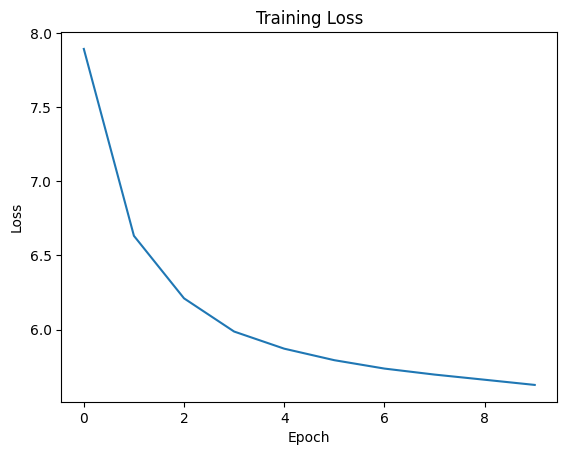

In [66]:
trainer = PersonalizedShowoTrainer(
    concept_name='BaGu',
    model=model,
    tokenizer=tokenizer,
    vq_model=vq_model,
    vision_tower=vision_tower,
    clip_processor=clip_image_processor,
    uni_prompting=uni_prompting,
    config=config,
    device=device
)

# 开始训练
losses = trainer.train(
    train_dataset=train_dataset,
    num_epochs=10
)

# 可选：绘制loss曲线
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()